# This code extracts features from nwb files and saves it to csv

In [1]:
# import standard libraries

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import scipy
import pandas as pd 
import csv
#import math

import h5py
# import feature extractor
import allensdk
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

# Plotting options
%matplotlib inline

# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

matplotlib.rcParams.update({'font.size': 15})


In [2]:

# Change parameters of the Figure size

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

# change the backgroud
#plt.style.use(['seaborn-notebook'])

matplotlib.rcParams.update({'font.size': 15})


In [71]:
path_to_files = './Data/H16.06.008/nwb'
nwb_file_list=list()

for file in os.listdir(path_to_files):
    if file.endswith(".nwb"):
        nwb_file_list.append(os.path.join(file))

# create a dictionary of dictionaries
# to store computed features
files_features={}
files_features_AP={}

# dictionary of dictionaries for firing-rate
files_features_fI={}

# dictionaries to record spikes
voltage_spike=[]
time_spike=[]

# dictionaries to record f-I curves
firing_frequency=[]
input_current=[]

# lists to record the time to spike
time_to_spike_input=[]
time_to_spike_value=[]

In [75]:
l = nwb_file_list[0]

# load nwb as h5py
file_name=path_to_files+str('/')+str(l)
f = h5py.File(file_name,'r')

# get the list of time series, access by names
list_timeseries=f.get('acquisition/timeseries/').keys()

print('Analyzed file')
print(l)
print('\n')

print('There are')
print(len(list_timeseries))
print('Sweeps')

### Action potential properties: Volate deap after AP (fast through-index)


# Extraction of features for all sweeps
sweep_characteristics={}

# load the file
f = h5py.File(file_name,'r')

Analyzed file
16708021.nwb


There are
16
Sweeps


In [142]:

# list of sags
voltage_sag=[]
i = 3

# prepare the feature drict
features_dict={}

voltage_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/data')
current_name=str('stimulus/presentation/Sweep_')+str(i)+str('/data')
rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/starting_time')
stim_amp_name=str('stimulus/presentation/Sweep_')+str(i)+str('/stimulus_amplitude_pa')
stim_name=str('stimulus/presentation/Sweep_')+str(i)+str('/aibs_stimulus_name')

# in mV
voltage=f[voltage_name][()]*1e3    
# in pA
current=f[current_name][()]*1e12        
# extracts the sampling rate for a given recording in Hz
# sampling rate
sampling_rate=f[rate_name].attrs['rate']        

# substact the baseline from the input current, the average of the last 50 ms
last_50_ms_steps=int(0.05*sampling_rate)
current=current - np.mean(current[-last_50_ms_steps:])

# time is in sec
time = np.arange(0, len(voltage)) * (1.0 / int(sampling_rate))

# decimate downsampling step if there are spikes
#            if max(voltage) > 0:
voltage=scipy.signal.decimate(voltage,5)
current=scipy.signal.decimate(current,5)                    
time=scipy.signal.decimate(time,5)

if max(voltage) < 100:
    if min(voltage) > - 150:
        current_amp=f[stim_amp_name][()]

        # record voltage deflection if there is a negative amplitude
        if current_amp<0:
            gradient_current=np.gradient(current)
            signal_max=max(np.gradient(current))
            signal_min=min(np.gradient(current))
            # find the first and second indexes of the current step
            first_ind=np.where(gradient_current == signal_max)[0][0]
            second_ind=np.where(gradient_current == signal_min)[0][0]
            # check for the first and second indexes
            if first_ind>second_ind:
                start_ind=second_ind
                end_ind=first_ind
            elif first_ind<second_ind:
                start_ind=first_ind
                end_ind=second_ind
            # get the average voltage in the middle of the sweep
            voltage_negative_amp=np.mean(
                voltage[
                    int((first_ind+second_ind)/2.0-(0.1*sampling_rate)):int((first_ind+second_ind)/2.0+(0.1*sampling_rate))]
            )  

            voltage_baseline=np.mean(voltage[0:int(0.1*sampling_rate)])
            
            # Fit the voltage sag
        if f[stim_name][()].decode() == 'Long Square':
            if f[stim_amp_name][()] < 0:   
                print('hi')
                start_sag=time[int(len(time)*0.10)]
                end_sag=time[int(len(time)*0.90)]
                sweep = EphysSweepFeatureExtractor(t=time, v=voltage, i=current, start=start_sag, end=end_sag)
                sag_estimate = sweep.estimate_sag()
                if np.isnan(sag_estimate) == False:
                    voltage_sag.append(sag_estimate)

voltage_sag

hi


[0.95048463]

In [141]:
f[stim_name][()].decode() == 'Long Square'

True

In [149]:
# Analyze all nwb files

def analyse_nwb_files(path_to_files):
    
    nwb_file_list=list()

    for file in os.listdir(path_to_files):
        if file.endswith(".nwb"):
            nwb_file_list.append(os.path.join(file))

    # create a dictionary of dictionaries
    # to store computed features
    files_features={}
    files_features_AP={}

    # dictionary of dictionaries for firing-rate
    files_features_fI={}

    # dictionaries to record spikes
    voltage_spike=[]
    time_spike=[]

    # dictionaries to record f-I curves
    firing_frequency=[]
    input_current=[]
    
    # lists to record the time to spike
    time_to_spike_input=[]
    time_to_spike_value=[]

    for l in range(0,len(nwb_file_list)):

        # load nwb as h5py
        file_name=path_to_files+str('/')+str(nwb_file_list[l])
        f = h5py.File(file_name,'r')

        # get the list of time series, access by names
        list_timeseries=f.get('acquisition/timeseries/').keys()

        print('Analyzed file')
        print(nwb_file_list[l])
        print('\n')

        print('There are')
        print(len(list_timeseries))
        print('Sweeps')

        ### Action potential properties: Volate deap after AP (fast through-index)
        

        # Extraction of features for all sweeps
        sweep_characteristics={}

        # load the file
        f = h5py.File(file_name,'r')
        
        # list of sags
        voltage_sag=[]

        for i in range(1,len(list_timeseries)):

            # prepare the feature drict
            features_dict={}

            voltage_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/data')
            current_name=str('stimulus/presentation/Sweep_')+str(i)+str('/data')
            rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/starting_time')
            stim_amp_name=str('stimulus/presentation/Sweep_')+str(i)+str('/stimulus_amplitude_pa')
            stim_name=str('stimulus/presentation/Sweep_')+str(i)+str('/aibs_stimulus_name')

            # in mV
            voltage=f[voltage_name][()]*1e3    
            # in pA
            current=f[current_name][()]*1e12        
            # extracts the sampling rate for a given recording in Hz
            # sampling rate
            sampling_rate=f[rate_name].attrs['rate']        
            
            # substact the baseline from the input current, the average of the last 50 ms
            last_50_ms_steps=int(0.05*sampling_rate)
            current=current - np.mean(current[-last_50_ms_steps:])
            
            # time is in sec
            time = np.arange(0, len(voltage)) * (1.0 / int(sampling_rate))

            # decimate downsampling step if there are spikes
#            if max(voltage) > 0:
            voltage=scipy.signal.decimate(voltage,5)
            current=scipy.signal.decimate(current,5)                    
            time=scipy.signal.decimate(time,5)
            
                    # check for normal spikes
            if max(voltage) < 100:
                if min(voltage) > - 150:
                    current_amp=f[stim_amp_name][()]

                    # record voltage deflection if there is a negative amplitude
                    if current_amp<0:
                        gradient_current=np.gradient(current)
                        signal_max=max(np.gradient(current))
                        signal_min=min(np.gradient(current))
                        # find the first and second indexes of the current step
                        first_ind=np.where(gradient_current == signal_max)[0][0]
                        second_ind=np.where(gradient_current == signal_min)[0][0]
                        # check for the first and second indexes
                        if first_ind>second_ind:
                            start_ind=second_ind
                            end_ind=first_ind
                        elif first_ind<second_ind:
                            start_ind=first_ind
                            end_ind=second_ind
                        # get the average voltage in the middle of the sweep
                        voltage_negative_amp=np.mean(
                            voltage[
                                int((first_ind+second_ind)/2.0-(0.1*sampling_rate)):int((first_ind+second_ind)/2.0+(0.1*sampling_rate))]
                        )      

                        

                    # calculates the voltage baseline at the end of each sweep, after application of the test pulse
                    voltage_baseline=np.mean(voltage[0:int(0.1*sampling_rate)])
                    
                    # Fit the voltage sag
                    if f[stim_name][()].decode() == 'Long Square':
                        if f[stim_amp_name][()] < 0:                        
                            start_sag=time[int(len(time)*0.10)]
                            end_sag=time[int(len(time)*0.90)]
                            sweep = EphysSweepFeatureExtractor(t=time, v=voltage, i=current, start=start_sag, end=end_sag)
                            sag_estimate = sweep.estimate_sag()
                            if np.isnan(sag_estimate) == False:
                                voltage_sag.append(sag_estimate)

                    

                    # FITTING THE TIME CONSTANT
                    # the fit is based on current step injections only!
                    if f[stim_name][()].decode() == 'Long Square':
                        if max(voltage) <= 0:
                            gradient_current=np.gradient(current)
                            signal_max=max(np.gradient(current))
                            signal_min=min(np.gradient(current))
                            # find the first and second indexes of the current step
                            first_ind=np.where(gradient_current == signal_max)[0][0]
                            second_ind=np.where(gradient_current == signal_min)[0][0]
                            # check for the first and second indexes
                            if first_ind>second_ind:
                                start_ind=second_ind
                                end_ind=first_ind
                            elif first_ind<second_ind:
                                start_ind=first_ind
                                end_ind=second_ind

                            # check for zero stimulus amplitude, if not zero, then fit
                            stim_amp = abs(np.mean(current[start_ind:end_ind]))
                            if stim_amp > 10:            
                                voltage_to_fit=voltage[int(start_ind):int(np.round((start_ind + 0.05*sampling_rate)))]
                                # a, inv_tau, y0, we need inv_tau
                                taum=allensdk.ephys.ephys_features.fit_membrane_time_constant(voltage, time, time[int(start_ind)], time[int(np.round((start_ind + 0.05*sampling_rate)))])
                                    # add time const in ms to features
                                if taum[1]:
                                    features_dict['taum']=(1/taum[1])*1000

                    # calculate the timing of the input stimuli, start and end
                    gradient_current=np.gradient(current)
                    signal_max=max(np.gradient(current))
                    signal_min=min(np.gradient(current))
                    # find the first and second indexes of the current step
                    first_ind=np.where(gradient_current == signal_max)[0][0]
                    second_ind=np.where(gradient_current == signal_min)[0][0]
                    # check for the first and second indexes
                    if first_ind>second_ind:
                        start_ind=second_ind
                        end_ind=first_ind
                    elif first_ind<second_ind:
                        start_ind=first_ind
                        end_ind=second_ind
                    #record the start/end time to the dictionary
                    features_dict['stim_start']=time[start_ind]
                    features_dict['stim_end']=time[end_ind]


                    # EXTRACTING SPIKE FEATURES
                    if f[stim_name][()].decode() == 'Long Square':
                        sweep = EphysSweepFeatureExtractor(t=time, v=voltage, i=current, start=0, end=time[-1])
                        sweep.process_spikes()

                        # RECORD FEATURES INTO THE DICTIONARY OF DICTIONARIES
                        all_spike_features=sweep.spike_feature_keys()
                        for j in range(0,len(all_spike_features)):
                            features_dict[all_spike_features[j]]=sweep.spike_feature(all_spike_features[j])
                    
                    # record the current in pA into the dictionary
                    features_dict['current_amp']=current_amp
                    # record the voltage deflection in mV into the dictionary
                    
                    if current_amp<0:
                        features_dict['voltage_negative_deflection']=voltage_negative_amp        
                    # record voltage baseline
                    features_dict['voltage_base']=voltage_baseline

                    # Record features in a dict of dict for various sweeps
                    sweep_characteristics[str('Sweep_')+str(i)]=features_dict


                    if f[stim_name][()].decode() == 'Long Square':
                        # check if there are spikes at all
                        sweep_name=str('Sweep_')+str(i)
                        if 'threshold_index' in sweep_characteristics[sweep_name]:
                            if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents                            
                                # save the sweep if there is one spike (two spike for test)
                                if len(sweep_characteristics[sweep_name]['threshold_index']) <= 2:                                
                                    # record the spike voltage and time trace per spike
                                    spike_ind_start=sweep_characteristics[sweep_name]['threshold_index'][0]-int(0.005*sampling_rate)
                                    spike_ind_end=sweep_characteristics[sweep_name]['threshold_index'][0]+int(0.005*sampling_rate)
                                    # minimal voltage - first ms after the start
                                    min_voltage=np.mean(voltage[spike_ind_start:(spike_ind_start+int(0.001*sampling_rate))])
                                    voltage_spike.append((voltage[spike_ind_start:spike_ind_end]-min_voltage))
    #                                min_time=min(time[spike_ind_start:spike_ind_end])
    #                                time_spike.append((time[spike_ind_start:spike_ind_end]-min_time)*1000)
                                    min_time=np.arange(0, len((voltage[spike_ind_start:spike_ind_end]-min_voltage))) * (1.0 / int(sampling_rate))
                                    time_spike.append(min_time*1000)



        # create the dictionary

        # store features of a file
        nwb_features={}

        ### Passive properties: voltage sag
        
        print('Here are the voltage sug estimates')
        print(voltage_sag)
        nwb_features['Voltage sag'] = np.mean(voltage_sag)
        # sag variance is very low
#        nwb_features['Voltage sag var'] = np.std(voltage_sag)
        
        ### Passive properties: membrane constant

        # Estimate the taum from single pulses

        taum_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
            if 'taum' in sweep_characteristics[sweep_name]:
                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        taum_list=np.array(taum_list)

        # Show taum
        print('Initial taum estimate')
        print(taum_list)
        print('\n')

        # get only taum between 5 and 100 ms
        taum_list=taum_list[np.where( taum_list < 100 )]
        taum_list=taum_list[np.where( taum_list > 5 )]

        print('Outliers removed')
        print(taum_list)

        # compute the values
        mean = np.mean(taum_list)
        sigma = np.std(taum_list)

        print('The average membrane time constant in ms')
        print(np.round(mean,2))

        nwb_features['taum_mean']=mean
        nwb_features['taum_sigma']=sigma

        # plot the taum as a function of sweep number

        taum_list=[]
        sweep_number=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
                if 'taum' in sweep_characteristics[sweep_name]:
                # get only the small taum between 5 and 100 ms to remove artefacts        
                    if sweep_characteristics[sweep_name]['taum'] <100:            
                        if sweep_characteristics[sweep_name]['taum'] >5:
                            string = sweep_name
                            # just gets the first element from the one valued list
                            number=[int(s) for s in string.split('_') if s.isdigit()][0]

                            sweep_number.append(number)
                            # check for NaNs
                            if sweep_characteristics[sweep_name]['taum']:                                                        
                                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        # plot the results

        ### Passive properties: average voltage

        #
        # plot the taum as a function of sweep number
        voltage_base_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:

                # get only the small taum between 5 and 100 ms to remove artefacts        
        #        if sweep_characteristics[sweep_name]['taum'] <100:            
        #            if sweep_characteristics[sweep_name]['taum'] >5:
                        string = sweep_name                
                        voltage_base_list.append(sweep_characteristics[sweep_name]['voltage_base'])

        # compute the values
        mean = np.mean(voltage_base_list)
        sigma = np.std(voltage_base_list)

        print('The average membrane potential in mV')
        print(np.round(mean,2))

        nwb_features['voltage_base_mean']=mean
        nwb_features['voltage_base_sigma']=sigma


        ### Passive properties: input resistance

        # Calculate and plot the input resistance for negative sweeps

        negative_current=[]
        negative_voltage=[]

        for sweep_name in sweep_characteristics:
            # pick up only the responses with the negative voltage deflections
            if bool(sweep_characteristics[sweep_name].get('voltage_negative_deflection')) == True:
                negative_current.append(sweep_characteristics[sweep_name]['current_amp'])
                negative_voltage.append(sweep_characteristics[sweep_name]['voltage_negative_deflection'] -sweep_characteristics[sweep_name]['voltage_base'])


        # create arrays to fit data
        negative_current=np.array(negative_current)/1e3  # convert to nA
        negative_voltage=np.array(negative_voltage)

        # pick up only currents in a certain range to avoid negative fitting
        pos_idx=np.where((np.array(negative_current)>-0.300) & (np.array(negative_current)<0) & (np.array(negative_voltage)< -5 ) )
        negative_current=[negative_current[i] for i in pos_idx[0]]
        negative_voltage=[negative_voltage[i] for i in pos_idx[0]]
        
        # create a linear fit for the data
        if negative_current:
            if negative_voltage:
                A = np.vstack([negative_current, np.ones(len(negative_current))]).T
                m, c = np.linalg.lstsq(A, negative_voltage)[0]
                nwb_features['R_in']=m                
        else:
            nwb_features['R_in']=np.nan
            
        print('Input resistance in MOhm')
        print(nwb_features['R_in'])

        ## Active properties

        ### Active properties: f-I curve

        # Plot the f-I curve

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of input currents
        stim_input=[]
        # list of resulting frequencies
        spike_freq=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # INPUT PROCESSING
            if stimulus_type_name == 'Long Square':
                stimulus_path=str("stimulus/presentation/") +str(sweep_name) +str('/stimulus_amplitude_pa')
                stimulus_value=f[stimulus_path][()] # to get the pA out of A
                # record the input current
                stim_input.append(stimulus_value)

                # SPIKES PROCESSING        
                if 'peak_t' in sweep_characteristics[sweep_name]:

                     stimulus_start_path=str("stimulus/presentation/") +str(sweep_name) +str('/starting_time')
                     all_spikes=sweep_characteristics[sweep_name]['peak_t']
                     num_spikes=len(all_spikes)
                     spike_freq.append(num_spikes/1) # all spikes during the trial

                # if there are no spikes, add 0
                else:
                    spike_freq.append(0)

        ### Active properties: f-I curve slope


        #data for the fit
        
        pos_idx=np.where((np.array(spike_freq)>0.5) & (np.array(stim_input)>0))
        
        input_value=[stim_input[i] for i in pos_idx[0]]
        feature_value=[spike_freq[i] for i in pos_idx[0]]

        #extract the theobase current and minimal frequency
        try:
            min_freq=min(feature_value)
            # get the value of the minimal element
            pos_min=np.argmin(feature_value)
            min_curr=input_value[pos_min]        
            # save the rheobase current and frequency
            nwb_features['Rheobase_current']=min_curr
            nwb_features['Rheobase_freq']=min_freq
        except (ValueError, RuntimeError, TypeError, NameError):
            nwb_features['Rheobase_current']=np.nan
            nwb_features['Rheobase_freq']=np.nan


        # REMOVE NON-UNIQUE VALUES FROM TWO LISTS!
        input_value_unique=[]
        feature_value_unique=[]    
        # convert them to arrays
        input_value_unique=np.array(input_value)
        feature_value_unique=np.array(feature_value)
        # rounding step
        input_value_unique=np.around(input_value_unique,decimals=0)

        # get only unique in input current elemnts
        input_value_unique, idx_unique = np.unique(input_value_unique, return_index=True)
        feature_value_unique=feature_value_unique[idx_unique]
        try:
            
            # correction for nA case
            if max(input_value_unique)<1:
                input_value_unique=input_value_unique*1e12

            # insert zero values until input current
            zero_steps=np.arange(0,min(input_value_unique)-1,1)
            input_value_unique=np.concatenate((zero_steps, input_value_unique), axis=0)
            zero_freq=np.zeros(len(zero_steps))
            feature_value_unique=np.concatenate((zero_freq, feature_value_unique), axis=0)

            # save the f-I curves data
            input_current.append(input_value_unique)
            firing_frequency.append(feature_value_unique)    


            #Make a linear fit
            A = np.vstack([input_value, np.ones(len(input_value))]).T

            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['fI_slope']=m
            
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['fI_slope']=np.nan
                        

        # save fI slope


        ### Active properties: relative average peak voltage

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        voltage_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike

                # check if there are spikes at all
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                voltage_value.append(sweep_characteristics[sweep_name]['peak_v'][0]-sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print(voltage_value)
                                print(input_value)


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(input_value))]).T
        try:
            m, c = np.linalg.lstsq(A, voltage_value)[0]
            nwb_features['AP_height_slope']=m
            nwb_features['AP_height_rheobase']=voltage_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_height_slope']=np.nan
            nwb_features['AP_height_rheobase']=np.nan




        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Average peak voltage')
        print(np.round(voltage_value,2))
        print('\n')
        print('Average peak voltage')
        print(np.round(np.mean(voltage_value),2))

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        width_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                if sweep_characteristics[sweep_name]['width'][0]:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                    width_value.append(sweep_characteristics[sweep_name]['width'][0]*1000)
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print(input_value)
                                print(width_value)


        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(width_value))]).T
            m, c = np.linalg.lstsq(A, width_value)[0]
            nwb_features['AP_width_slope']=m
            nwb_features['AP_width_rheobase']=width_value[input_value.index(min(input_value))]
        except (ValueError, RuntimeError, TypeError, NameError, np.linalg.LinAlgError):
            nwb_features['AP_width_slope']=np.nan
            nwb_features['AP_width_rheobase']=np.nan




        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Average peak width in ms')
        print(np.round(width_value,2))
        print('\n')
        print('Average AP widtj trials in mV')
        print(np.round(np.mean(width_value),2))
        print('\n')
        print('Average threshold std in mV')
        print(np.round(np.std(width_value),2))


        # export to eps
        #plt.savefig('W1_AP_width.eps', format='eps', dpi=300)



        ### Active properties: AP voltage treshold

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        thr_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                thr_value.append(sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print(thr_value)
                                print(input_value)

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(thr_value))]).T
        try:
            m, c = np.linalg.lstsq(A, thr_value)[0]
            nwb_features['AP_thr_slope']=m
            nwb_features['AP_thr_rheobase']=thr_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_thr_slope']=np.nan
            nwb_features['AP_thr_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('AP threshold value in mV')
        print(np.round(thr_value,2))
        print('\n')

        print('Average start in mV')
        print(np.round(np.mean(thr_value),2))
        print('\n')
        print('Average start std in mV')
        print(np.round(np.std(thr_value),2))

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                feature_value.append(sweep_characteristics[sweep_name]['fast_trough_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print(input_value)
                                print(feature_value)

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_through_slope']=m
            nwb_features['AP_through_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_through_slope']=np.nan
            nwb_features['AP_through_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Voltage trough after AP')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in mV')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in mV')
        print(np.round(np.std(feature_value),2))


        ### Action potential properties: AP voltage upstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            feature_value.append(sweep_characteristics[sweep_name]['upstroke_v'][0])

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_upstroke_slope']=m
            nwb_features['AP_upstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_upstroke_slope']=np.nan
            nwb_features['AP_upstroke_rheobase']=np.nan

            
        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Voltage trough after AP in mV/ms')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in mV/ms')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in mV/ms')
        print(np.round(np.std(feature_value),2))


        ### Action potential properties: AP voltage downstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['downstroke_v'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print(feature_value)
                                    print(input_value)


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_downstroke_slope']=m
            nwb_features['AP_downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_downstroke_slope']=np.nan
            nwb_features['AP_downstroke_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Voltage trough after AP in mV/ms')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in mV/ms')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in mV/ms')
        print(np.round(np.std(feature_value),2))


        ### Action potential properties: AP volage upstroke/downstroke ratio

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['upstroke_downstroke_ratio'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print(feature_value)
                                    print(input_value)
                                

        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(feature_value))]).T
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_up/downstroke_slope']=m
            nwb_features['AP_up/downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_up/downstroke_slope']=np.nan
            nwb_features['AP_up/downstroke_rheobase']=np.nan

        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Voltage upstroke/downstroke ratio')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in []')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in []')
        print(np.round(np.std(feature_value),2))

        ### Active properties, spike patterns: adaptation index

        # Plot the average adaptation index as a function of the input current

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        index_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                isis=sweep_characteristics[sweep_name]['peak_t']          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                isis=allensdk.ephys.ephys_features.adaptation_index(isis) # compute the adaptation index
                                index_value.append(isis)                                  # record the index
                                
        # convert not index
        index_value=np.array(index_value)
        #get the nan index value
        nan_index=np.argwhere(np.isnan(index_value))
        # remove elements with the wrong index value
        index_value = index_value[np.isfinite(index_value)]
        # remove the corresponding element in input value if it is needed
        if len(nan_index)>0:
            input_value = [i for j, i in enumerate(input_value) if j not in nan_index]
            
        

        #Make a linear fit        
        x=np.array(input_value)
        y=np.array(index_value)

        # take only positive values
        x=x[np.where(y>0)]
        y=y[np.where(y>0)]


        #Make a linear fit
        A = np.vstack([x, np.ones(len(x))]).T
        try:
            m, c = np.linalg.lstsq(A, y)[0]
            # save the adaptation index
            nwb_features['adaptation_slope']=m
            nwb_features['adaptation_slope_rheobase']=y[np.argmin(x)]
        except (ValueError,RuntimeError, TypeError, NameError):
                nwb_features['adaptation_slope']=np.nan
                nwb_features['adaptation_slope_rheobase']=np.nan

                
        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Adaptation index value')
        print(np.round(index_value,2))
        print('\n')
        print('Average adaptation index over trials')
        print(np.round(np.mean(index_value),2))


        ### Active properties, spike patterns: average interspike interval

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(np.mean(sweep_characteristics[sweep_name]['peak_i'][0]))                
                                    feature_value.append(np.mean(isis))                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['mean_ISI_slope']=coeff[0]
            nwb_features['mean_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['mean_ISI_slope']=np.nan
            nwb_features['mean_ISI_slope_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Average interspike interval in ms')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in []')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in []')
        print(np.round(np.std(feature_value),2))


        ### Active properties, spike patterns: first ISI

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])                
                                    feature_value.append(isis[0])                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['First_ISI_slope']=coeff[0]
            nwb_features['First_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['First_ISI_slope']=np.nan
            nwb_features['First_ISI_slope_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Average interspike interval in ms')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in []')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in []')
        print(np.round(np.std(feature_value),2))


        ### Active properties, spike patterns: first spike delay

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path][()].decode())

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                if (sweep_characteristics[sweep_name]['stim_end'] - sweep_characteristics[sweep_name]['stim_start'])*1000 > 800:
                                    feature_value.append((sweep_characteristics[sweep_name]['peak_t'][0]-sweep_characteristics[sweep_name]['stim_start'])*1000)               
                                    isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                    isis=np.diff(isis)                                        # compute the inter-spike intervals
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print(feature_value)
                                print(input_value)
                      # compute the average value of ISIs
 

        # Make a linear fit
        x=np.array(input_value)
        y=np.array(feature_value)
        
        # record time_to_spike_values
        time_to_spike_input=time_to_spike_input+input_value
        time_to_spike_value=time_to_spike_value+feature_value
        
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['Time_to_spike_slope']=coeff[0]    
            nwb_features['Time_to_spike_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError, np.linalg.LinAlgError):
            nwb_features['Time_to_spike_slope']=np.nan
            nwb_features['Time_to_spike_slope_rheobase']=np.nan


        print('Input current in pA')
        print(np.round(input_value,2))
        print('\n')
        print('Time to 1st spike in ms')
        print(np.round(feature_value,2))
        print('\n')

        print('Mean in ms')
        print(np.round(np.mean(feature_value),2))
        print('\n')
        print('Std in ms')
        print(np.round(np.std(feature_value),2))

        # add first spikes to the dictionary of dictionaries
        files_features_AP['first_spike_voltage']=voltage_spike
        files_features_AP['first_spike_time']=time_spike

        files_features_fI['input_current']=input_current
        files_features_fI['firing_frequency']=firing_frequency


        # record features into the dictionary of dictionaries
        files_features[nwb_file_list[l]]=nwb_features

        
    return files_features, files_features_AP, files_features_fI, time_to_spike_input, time_to_spike_value


In [150]:
# this function creates the list from files features

def matrix_from_dict(n_cells,n_features,label,files_features_dict):
    
    # +1 to add labels
    all_features_matrix=np.zeros((len(files_features_dict.keys()),n_features+1))

    # file_names list
    file_names=[]

    # counter for file names
    k=0
    
    for key in enumerate(files_features_dict.keys()):
        # save the filename
        file_names.append(key[1])
        
        # counter for features
        m=0
        
        # feature name list
        feature_names=[]
        
        for keys in enumerate(files_features_dict[key[1]]):
            # save features to the matrix
            all_features_matrix[k,0]=label
            m=m+1
            all_features_matrix[k,m]=files_features_dict[key[1]][keys[1]]
            feature_names.append(keys[1])
            
        k=k+1

    return all_features_matrix, file_names, feature_names

In [151]:

# H1606008

files_features_H1606008, files_features_AP_H1606008, files_features_fI_H1606008, time_to_spike_input_H1606008, time_to_spike_value_H1606008 = analyse_nwb_files('./Data/H16.06.008/nwb')



Analyzed file
16708021.nwb


There are
16
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in multiply
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/a

Here are the voltage sug estimates
[0.9699102, 1.0106497, 0.95048463, 0.98842883]
Initial taum estimate
[32.27096845 34.16149725 33.76514531 43.21997647         nan 32.74673525
 28.48612628 30.46142394 30.62648721]


Outliers removed
[32.27096845 34.16149725 33.76514531 43.21997647 32.74673525 28.48612628
 30.46142394 30.62648721]
The average membrane time constant in ms
33.22
The average membrane potential in mV
-58.72
Input resistance in MOhm
136.9149017333984
Input current in pA
[124.37 148.79 173.65 198.75 223.19 247.88]


Average peak voltage
[87.91 88.75 86.84 84.51 83.71 84.12]


Average peak voltage
85.97
Input current in pA
[124.37 148.79 173.65 198.75 223.19 247.88]


Average peak width in ms
[1.19 1.09 1.09 1.09 1.19 1.09]


Average AP widtj trials in mV
1.12


Average threshold std in mV
0.05
Input current in pA
[124.37 148.79 173.65 198.75 223.19 247.88]


AP threshold value in mV
[-37.27 -38.23 -38.56 -38.88 -38.44 -40.06]


Average start in mV
-38.57


Average start std 

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[0.9949704, 1.0082772, 0.98763096, 0.97362226]
Initial taum estimate
[20.60128407 20.86739164 23.52723048 23.44952049         nan 26.85116943
 28.93524785 29.54464509 65.66484887]


Outliers removed
[20.60128407 20.86739164 23.52723048 23.44952049 26.85116943 28.93524785
 29.54464509 65.66484887]
The average membrane time constant in ms
29.93
The average membrane potential in mV
-63.94
Input resistance in MOhm
160.54710388183597
Input current in pA
[124.27 149.02 174.18 198.69 223.11]


Average peak voltage
[86.   86.73 86.39 86.85 86.01]


Average peak voltage
86.4
Input current in pA
[124.27 149.02 174.18 198.69 223.11]


Average peak width in ms
[1.38 1.29 1.29 1.29 1.19]


Average AP widtj trials in mV
1.29


Average threshold std in mV
0.06
Input current in pA
[124.27 149.02 174.18 198.69 223.11]


AP threshold value in mV
[-33.22 -34.32 -34.49 -34.98 -35.05]


Average start in mV
-34.41


Average start std in mV
0.66
Input current in pA
[124.27 

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

In [152]:
# show the extracted features

files_features_H1606008


{'16708021.nwb': {'Voltage sag': 0.97986835,
  'taum_mean': 33.217295019417605,
  'taum_sigma': 4.169132443351026,
  'voltage_base_mean': -58.719322,
  'voltage_base_sigma': 0.63678676,
  'R_in': 136.9149017333984,
  'Rheobase_current': 125.0,
  'Rheobase_freq': 1.0,
  'fI_slope': 0.11771428571428566,
  'AP_height_slope': -0.042087698761083425,
  'AP_height_rheobase': 87.911316,
  'AP_width_slope': -0.0002275062317749513,
  'AP_width_rheobase': 1.186263713601754,
  'AP_thr_slope': -0.0172015248982015,
  'AP_thr_rheobase': -37.27209,
  'AP_through_slope': 0.009592211456816284,
  'AP_through_rheobase': -51.29395,
  'AP_upstroke_slope': -0.10526038912113232,
  'AP_upstroke_rheobase': 0.827426,
  'AP_downstroke_slope': -0.1111431173294382,
  'AP_downstroke_rheobase': 46.235542,
  'AP_up/downstroke_slope': -0.0015951190577805005,
  'AP_up/downstroke_rheobase': 4.163227566546022,
  'adaptation_slope': 0.000513534589906343,
  'adaptation_slope_rheobase': 0.004206288367310768,
  'mean_ISI_slop

In [153]:
# H1606013

files_features_H1606013, files_features_AP_H1606013, files_features_fI_H1606013, time_to_spike_input_H1606013, time_to_spike_value_H1606013 = analyse_nwb_files('./Data/H16.06.013/nwb')


Analyzed file
1606013050504.nwb


There are
65
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/

Here are the voltage sug estimates
[1.0142654, 1.0093124, 1.008781, 6.116166, 5.7629557, 6.009306, 5.7828603, 5.194239, 5.422652, 4.5788765, 2.4862664]
Initial taum estimate
[15.37260571 17.16505763 20.08981313 32.77013994 33.94426436 40.6038783
 31.07342062 32.12227022 30.53945873 33.00157937 35.66838834 34.35966026
 35.82284078 45.80756082]


Outliers removed
[15.37260571 17.16505763 20.08981313 32.77013994 33.94426436 40.6038783
 31.07342062 32.12227022 30.53945873 33.00157937 35.66838834 34.35966026
 35.82284078 45.80756082]
The average membrane time constant in ms
31.31
The average membrane potential in mV
-65.8
Input resistance in MOhm
59.906300352809396
Input current in pA
[252.1  302.38 352.71 402.9  453.2  503.76 554.3  604.35 653.98 704.67
 755.18]


Average peak voltage
[ 97.64  97.82  97.85  99.47  99.33  98.71  99.38  99.58 100.15 100.29
 100.37]


Average peak voltage
99.14
Input current in pA
[252.1  302.38 352.71 402.9  453.2  503.76 554.3  604.35 653.98 704.67
 755.18]

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, voltage_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:552: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M,

Here are the voltage sug estimates
[1.0444108, 1.047221, 1.0215158, 1.0303596, 1.1014141, 0.20234022, 1.0413961, 1.037816, 0.9909469, 0.78818977, 2.3557615, 1.0444108, 1.047221, 1.0215158, 1.0303596, 1.1014141, 0.20234022, 1.0413961, 1.037816, 0.9909469, 0.78818977, 2.3557615]
Initial taum estimate
[19.42554658 22.49414744 26.25856515         nan 45.75298763 43.16805139
 25.95460713 27.18889906 19.24483858 20.7837409  18.64483956 49.22647703
 34.62493328 19.42554658 22.49414744 26.25856515         nan 45.75298763
 43.16805139 25.95460713 27.18889906 19.24483858 20.7837409  18.64483956
 49.22647703 34.62493328]


Outliers removed
[19.42554658 22.49414744 26.25856515 45.75298763 43.16805139 25.95460713
 27.18889906 19.24483858 20.7837409  18.64483956 49.22647703 34.62493328
 19.42554658 22.49414744 26.25856515 45.75298763 43.16805139 25.95460713
 27.18889906 19.24483858 20.7837409  18.64483956 49.22647703 34.62493328]
The average membrane time constant in ms
29.4
The average membrane pot

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:838: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:913: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y)[0]


Input current in pA
[197.71 247.14 296.57 346.   395.43 444.85 494.28 197.71 247.14 296.57
 346.   395.43 444.85 494.28]


Average interspike interval in ms
[106.89  46.66  28.74  22.69  19.97  17.05  15.5  106.89  46.66  28.74
  22.69  19.97  17.05  15.5 ]


Mean in []
36.78


Std in []
30.24
Input current in pA
[197.71 247.14 296.57 346.   395.43 444.85 494.28 197.71 247.14 296.57
 346.   395.43 444.85 494.28]


Time to 1st spike in ms
[57.76 33.83 23.82 19.43 16.26 14.41 12.36 57.76 33.83 23.82 19.43 16.26
 14.41 12.36]


Mean in ms
25.41


Std in ms
14.79
Analyzed file
1606013050103.nwb


There are
110
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib

Here are the voltage sug estimates
[0.15353474, 0.13030753, 0.12415971, 0.06680947, 2.9410398, -52.41998, 0.15353474, 0.13030753, 0.12415971, 0.06680947, 2.9410398, -52.41998]
Initial taum estimate
[16.69853123 20.00824953 24.36600837         nan 47.38452403         nan
 16.69853123 20.00824953 24.36600837         nan 47.38452403         nan]


Outliers removed
[16.69853123 20.00824953 24.36600837 47.38452403 16.69853123 20.00824953
 24.36600837 47.38452403]
The average membrane time constant in ms
27.11
The average membrane potential in mV
-59.25
Input resistance in MOhm
41.100131745336775
Input current in pA
[ 98.86 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28  98.86
 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28]


Average peak voltage
[88.35 91.16 90.77 90.59 90.13 89.93 89.65 89.93 90.1  88.35 91.16 90.77
 90.59 90.13 89.93 89.65 89.93 90.1 ]


Average peak voltage
90.07
Input current in pA
[ 98.86 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28  98.86

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28 148.28 197.71
 247.14 296.57 345.99 395.42 444.85 494.28]


Average interspike interval in ms
[36.58 18.91 13.57 11.27 10.45  9.64  8.7   8.65 36.58 18.91 13.57 11.27
 10.45  9.64  8.7   8.65]


Mean in []
14.72


Std in []
8.84
Input current in pA
[ 98.86 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28  98.86
 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28]


Time to 1st spike in ms
[138.15  32.7   19.75  13.72  10.31   8.16   6.82   5.61   4.75 138.15
  32.7   19.75  13.72  10.31   8.16   6.82   5.61   4.75]


Mean in ms
26.66


Std in ms
40.29
Analyzed file
1606013050301.nwb


There are
132
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.

Here are the voltage sug estimates
[0.14264679, 0.11538079, 0.120788716, 0.15252665, -2.6112607, -25.098066, 0.15023172, 0.14065759, 0.13247798, 0.0922049, 0.08934432, 0.16378526, 0.14161085, 0.13198452, 0.1283007, -1.4543581, -28.832895, 0.14264679, 0.11538079, 0.120788716, 0.15252665, -2.6112607, -25.098066, 0.15023172, 0.14065759, 0.13247798, 0.0922049, 0.08934432, 0.16378526, 0.14161085, 0.13198452, 0.1283007, -1.4543581, -28.832895]
Initial taum estimate
[15.45044052 18.3547737  21.15603021         nan 34.56163556         nan
 18.4440205  21.90687865 25.82505754         nan 43.6436526  18.40459065
 23.4862741  29.39269254         nan 49.2187985          nan 15.45044052
 18.3547737  21.15603021         nan 34.56163556         nan 18.4440205
 21.90687865 25.82505754         nan 43.6436526  18.40459065 23.4862741
 29.39269254         nan 49.2187985          nan]


Outliers removed
[15.45044052 18.3547737  21.15603021 34.56163556 18.4440205  21.90687865
 25.82505754 43.6436526  18.404

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[ 98.86 148.28 197.71 247.14 296.57 345.99 395.43 444.85 494.28  98.86
 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28  98.86 148.28
 197.71 247.14 296.57 345.99 395.43 444.85 494.28  98.86 148.28 197.71
 247.14 296.57 345.99 395.42 444.85 494.28]


Voltage trough after AP in mV/ms
[ 34.65  34.78  30.03  30.62  33.51  29.1   30.79  30.5   28.16 -20.22
 -18.08 -13.66 -16.46 -12.98 -14.77 -12.63 -12.77 -14.16  34.65  34.78
  30.03  30.62  33.51  29.1   30.79  30.5   28.16 -20.22 -18.08 -13.66
 -16.46 -12.98 -14.77 -12.63 -12.77 -14.16]


Mean in mV/ms
8.13


Std in mV/ms
23.34
Input current in pA
[ 98.86 148.28 197.71 247.14 296.57 345.99 395.43 444.85 494.28  98.86
 148.28 197.71 247.14 296.57 345.99 395.42 444.85 494.28  98.86 148.28
 197.71 247.14 296.57 345.99 395.43 444.85 494.28  98.86 148.28 197.71
 247.14 296.57 345.99 395.42 444.85 494.28]


Voltage upstroke/downstroke ratio
[5.43 5.25 5.   4.96 4.8  4.8  4.88 4.92 4.88 4.22 4.08 3.86 3.81 3.73
 3.81

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:780: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:838: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:913: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M,

In [154]:
# show the extracted features

files_features_H1606013


{'1606013050504.nwb': {'Voltage sag': 4.035062,
  'taum_mean': 31.31006701540725,
  'taum_sigma': 8.187237285589578,
  'voltage_base_mean': -65.800095,
  'voltage_base_sigma': 4.3124204,
  'R_in': 59.906300352809396,
  'Rheobase_current': 258.04514,
  'Rheobase_freq': 2.0,
  'fI_slope': 0.04615447460687426,
  'AP_height_slope': 0.0055445094188724935,
  'AP_height_rheobase': 97.64255,
  'AP_width_slope': -0.00010741013110649012,
  'AP_width_rheobase': 1.186263713586433,
  'AP_thr_slope': -0.013127689371487975,
  'AP_thr_rheobase': -32.588017,
  'AP_through_slope': 0.003120701324731941,
  'AP_through_rheobase': -49.347763,
  'AP_upstroke_slope': 0.013256671870054368,
  'AP_upstroke_rheobase': -7.34911,
  'AP_downstroke_slope': -0.010223092567606394,
  'AP_downstroke_rheobase': 61.614304,
  'AP_up/downstroke_slope': -0.0006999276769681686,
  'AP_up/downstroke_rheobase': 5.551256350856078,
  'adaptation_slope': -0.00027934990698081806,
  'adaptation_slope_rheobase': 0.22598975154234724,
  

In [155]:
# H1706012

files_features_H1706012, files_features_AP_H1706012, files_features_fI_H1706012, time_to_spike_input_H1706012, time_to_spike_value_H1706012 = analyse_nwb_files('./Data/H17.06.012/nwb')


Analyzed file
1706012210904.nwb


There are
57
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[0.984773, 0.9913868, 0.98014504, 0.9951597]
Initial taum estimate
[10.83748752 12.34918304 13.43451219 14.74396655 16.62953904 18.2847254
 17.69123944 17.40393822 16.25161045 15.50019974]


Outliers removed
[10.83748752 12.34918304 13.43451219 14.74396655 16.62953904 18.2847254
 17.69123944 17.40393822 16.25161045 15.50019974]
The average membrane time constant in ms
15.31
The average membrane potential in mV
-69.94
Input resistance in MOhm
81.96942767531732
Input current in pA
[347.22 396.42 446.06 496.46 545.16 594.59 644.31 693.57 743.39 793.13]


Average peak voltage
[80.78 81.57 82.14 85.03 84.1  85.64 85.66 87.31 87.12 86.06]


Average peak voltage
84.54
Input current in pA
[347.22 396.42 446.06 496.46 545.16 594.59 644.31 693.57 743.39 793.13]


Average peak width in ms
[2.72 2.47 2.47 2.22 2.22 2.22 2.22 1.98 2.22 2.22]


Average AP widtj trials in mV
2.3


Average threshold std in mV
0.19
Input current in pA
[347.22 396.42 446.06 496.46 545.

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[1.0362694, 1.0105922, 1.0419703, 1.0330385]
Initial taum estimate
[11.02539061 14.93710379 17.21486043 17.4530744  34.03887701]


Outliers removed
[11.02539061 14.93710379 17.21486043 17.4530744  34.03887701]
The average membrane time constant in ms
18.93
The average membrane potential in mV
-55.75
Input resistance in MOhm
110.56484436775402
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Average peak voltage
[97.08 89.09 94.79 93.06 88.04]


Average peak voltage
92.41
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Average peak width in ms
[1.48 1.24 1.48 1.48 1.48]


Average AP widtj trials in mV
1.43


Average threshold std in mV
0.1
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


AP threshold value in mV
[-34.66 -34.54 -35.49 -34.85 -34.52]


Average start in mV
-34.81


Average start std in mV
0.36
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Voltage trough after AP
[-48.66 -47.72 -46.15 -45.05 -43.

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[1.0022839, 0.9946195, 1.0136176, 1.0282902, 0.9956685, 1.0135345, 1.02304, 1.0354345, 0.994212, 1.012375, 1.007012, 1.0127585]
Initial taum estimate
[21.55850088 25.57751623 33.45894197 51.49364987 66.40330617 20.3035592
 24.05950494 30.46036296 46.37304742 60.38149917 46.51578814 24.74230006
 23.58405106 29.93049967 39.01598236 63.08035118 50.99992121]


Outliers removed
[21.55850088 25.57751623 33.45894197 51.49364987 66.40330617 20.3035592
 24.05950494 30.46036296 46.37304742 60.38149917 46.51578814 24.74230006
 23.58405106 29.93049967 39.01598236 63.08035118 50.99992121]
The average membrane time constant in ms
38.7
The average membrane potential in mV
-73.3
Input resistance in MOhm
154.9658911754471
Input current in pA
[103.32 152.36 199.83 251.01 299.88 347.77 400.67 451.31 499.63 146.2
 204.93 248.83 304.48 343.98 402.85 449.06 497.06 547.55 145.81 200.52
 254.11 299.69 349.46 398.56 454.51 498.49 546.42 600.07]


Average peak voltage
[ 98.26 

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[103.32 152.36 199.83 251.01 299.88 347.77 400.67 451.31 499.63 146.2
 204.93 248.83 304.48 343.98 402.85 449.06 497.06 547.55 145.81 200.52
 254.11 299.69 349.46 398.56 454.51 498.49 546.42 600.07]


Time to 1st spike in ms
[769.59  76.37  38.8   26.2   20.51  16.31  13.59  11.12   8.65 119.61
  44.24  30.89  22.74  18.29  15.08  12.11  10.38   8.65 150.51  48.69
  31.88  24.22  18.54  15.57  13.35  11.86  11.37  11.12]


Mean in ms
57.15


Std in ms
140.96
Analyzed file
1706012211203.nwb


There are
125
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[1.0117985, 1.0107052, 1.0143381, 1.00913, 1.0064675, 1.0330797, 1.012363, 1.0197603, 0.9946062, 0.9902459, 1.0052367, 1.009446]
Initial taum estimate
[27.92859213 31.93980465 40.54145995 45.44697762 50.10060471 46.50306684
 28.04115974 32.17163687 36.41401588 41.42094218 43.2623797  43.21926633
 27.96557518 30.83508828 38.23747832 39.75019189 42.20344441 42.58559477
 42.69720614]


Outliers removed
[27.92859213 31.93980465 40.54145995 45.44697762 50.10060471 46.50306684
 28.04115974 32.17163687 36.41401588 41.42094218 43.2623797  43.21926633
 27.96557518 30.83508828 38.23747832 39.75019189 42.20344441 42.58559477
 42.69720614]
The average membrane time constant in ms
38.49
The average membrane potential in mV
-65.71
Input resistance in MOhm
149.54838574668491
Input current in pA
[150.58 198.59 247.14 299.75 350.93 400.53 448.61 498.7  556.49 598.98
 649.   697.   752.29 793.02 154.04 193.25 255.46 300.2  350.48 399.02
 449.28 505.37 546.71 599.33 647

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[150.58 198.59 247.14 299.75 350.93 400.53 448.61 498.7  556.49 598.98
 649.   697.   752.29 793.02 154.04 193.25 255.46 300.2  350.48 399.02
 449.28 505.37 546.71 599.33 647.5  200.05 248.68 308.95 345.83 397.98
 443.35 494.55 549.49 600.74 641.96 695.04]


Voltage upstroke/downstroke ratio
[2.67 2.58 2.63 2.74 2.63 2.67 2.74 2.66 2.71 2.79 3.1  3.04 2.74 2.82
 2.74 2.73 2.6  3.08 2.82 2.67 3.21 3.09 3.31 2.95 2.81 2.73 2.86 2.66
 2.8  2.71 2.76 2.59 2.97 3.02 2.71 2.75]


Mean in []
2.81


Std in []
0.18
Input current in pA
[198.59 247.14 299.75 350.93 400.53 448.61 498.7  556.49 598.98 649.
 697.   752.29 793.02 193.25 255.46 300.2  350.48 399.02 449.28 505.37
 546.71 599.33 647.5  200.05 248.68 308.95 345.83 397.98 443.35 494.55
 549.49 600.74 641.96 695.04]


Adaptation index value
[0.41 0.25 0.14 0.07 0.06 0.05 0.04 0.03 0.02 0.03 0.03 0.02 0.02 0.41
 0.3  0.19 0.12 0.1  0.06 0.05 0.04 0.03 0.03 0.06 0.25 0.18 0.09 0.08
 0.06 0.05 0.05 0.05 0.05 0.03]


Averag

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[0.9987653, 1.01932, 1.0086343, 1.0726624, 1.0029968, 0.9957828, 1.0122575, 1.0240933, 1.0061996, 1.0037032, 1.1943942, 1.1639333]
Initial taum estimate
[34.68204837 42.39553481 51.11041922 64.19836722 72.03004739 35.8920306
 44.82853564 48.3616871  64.29763241 69.29560892 34.6217663  41.46850421
 47.71071228 39.26807226 59.95596416 52.44331923]


Outliers removed
[34.68204837 42.39553481 51.11041922 64.19836722 72.03004739 35.8920306
 44.82853564 48.3616871  64.29763241 69.29560892 34.6217663  41.46850421
 47.71071228 39.26807226 59.95596416 52.44331923]
The average membrane time constant in ms
50.16
The average membrane potential in mV
-70.54
Input resistance in MOhm
157.43266026880227
Input current in pA
[100.49 147.32 199.02 250.53 299.6  350.93 396.27 454.48 494.81 552.01
 599.35 650.43 696.07 749.57 799.09  99.21 143.87 204.46 259.52 300.91
 350.1  400.16 450.64 499.78 549.16 599.4  654.81 697.14 752.23 798.77
 149.91 202.51 250.38 299.73 349.47

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[100.49 147.32 199.02 250.53 299.6  350.93 396.27 454.48 494.81 552.01
 599.35 650.43 696.07 749.57 799.09  99.21 143.87 204.46 259.52 300.91
 350.1  400.16 450.64 499.78 549.16 599.4  654.81 697.14 752.23 798.77
 149.91 202.51 250.38 299.73 349.47 396.41 455.77 496.38 549.33 599.91
 647.85 694.45 749.04 798.07]


Adaptation index value
[-0.01  0.03  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.01
  0.01  0.01  0.02 -0.1   0.04  0.04  0.03  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.05  0.05  0.03  0.02  0.03  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03]


Average adaptation index over trials
0.02
Input current in pA
[100.49 147.32 199.02 250.53 299.6  350.93 396.27 454.48 494.81 552.01
 599.35 650.43 696.07 749.57 799.09  99.21 143.87 204.46 259.52 300.91
 350.1  400.16 450.64 499.78 549.16 599.4  654.81 697.14 752.23 798.77
 149.91 202.51 250.38 299.73 349.47 396.41 455.77 496.38 549.33 599.91
 647.85 694.45 749.04 79

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[0.9956017, 0.98333824, 0.9979922, 1.0122349, 1.0028969, 0.990929, 1.0164474, 1.0123612, 1.0035352, 1.0042458, 1.0454146, 0.9841041]
Initial taum estimate
[19.15508816 23.93959924 28.0798788  28.83763418 38.19382229 17.48837326
 22.99755899 25.0502072  28.81009893 31.31494641 33.62761592 18.1090334
 22.11554497 25.75156886 27.47394252 33.42312361 32.15096605]


Outliers removed
[19.15508816 23.93959924 28.0798788  28.83763418 38.19382229 17.48837326
 22.99755899 25.0502072  28.81009893 31.31494641 33.62761592 18.1090334
 22.11554497 25.75156886 27.47394252 33.42312361 32.15096605]
The average membrane time constant in ms
26.85
The average membrane potential in mV
-64.33
Input resistance in MOhm
130.59596758746116
Input current in pA
[101.52 150.75 199.02 249.95 300.46 350.04 399.73 449.57 498.68 551.83
 603.3  655.6  706.45 743.92 150.18 196.39 249.16 302.16 349.83 396.48
 448.03 497.03 551.52 598.77 649.11 694.99 747.91 157.04 202.84 256.12
 298.9  3

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[0.98795456, 0.9991573, 1.0106653, 1.0217824, 0.99422604, 1.020085, 0.9984116, 0.96553797]
Initial taum estimate
[19.90236532 23.1995908  26.89099997 29.34491963 35.42841943 37.54487861
 19.29489544 22.54786075 25.1253454  27.0645795  30.82582394 31.22711404]


Outliers removed
[19.90236532 23.1995908  26.89099997 29.34491963 35.42841943 37.54487861
 19.29489544 22.54786075 25.1253454  27.0645795  30.82582394 31.22711404]
The average membrane time constant in ms
27.37
The average membrane potential in mV
-64.93
Input resistance in MOhm
130.4720925605663
Input current in pA
[153.48 202.63 250.41 305.16 350.99 151.6  192.85 251.76 296.25 358.66
 401.97]


Average peak voltage
[ 94.65  97.5   99.89 103.16  94.23  97.13 101.24  97.52 102.46  94.1
  98.82]


Average peak voltage
98.24
Input current in pA
[153.48 202.63 250.41 305.16 350.99 151.6  192.85 251.76 296.25 358.66
 401.97]


Average peak width in ms
[1.24 1.48 1.24 1.48 1.24 1.48 1.48 1.24 1.48 1

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[1.0212039, 1.0451418, 1.0108974, 1.0096287, 1.0169795, 1.0088466, 1.0214459, 0.978739]
Initial taum estimate
[20.10367412 25.16775248 31.1272856  34.07721839 41.82322561 19.72362753
 23.50008739 27.2283536  30.26328784 34.71771293]


Outliers removed
[20.10367412 25.16775248 31.1272856  34.07721839 41.82322561 19.72362753
 23.50008739 27.2283536  30.26328784 34.71771293]
The average membrane time constant in ms
28.77
The average membrane potential in mV
-57.98
Input resistance in MOhm
160.64629613285842
Input current in pA
[100.33 150.59 204.48 246.56 295.42 346.41 401.05 449.46 498.84 548.11
 100.17 152.46 200.12 249.48 299.29 349.7 ]


Average peak voltage
[88.79 84.95 85.92 89.83 87.57 91.37 89.48 92.89 92.77 88.54 94.11 92.77
 97.25 95.43 97.37 99.26]


Average peak voltage
91.77
Input current in pA
[100.33 150.59 204.48 246.56 295.42 346.41 401.05 449.46 498.84 548.11
 100.17 152.46 200.12 249.48 299.29 349.7 ]


Average peak width in ms
[1.73 1

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[1.0132054, 1.0365549, 1.0233215, 0.981012, 1.0183706, 1.0207112, 1.0323141, 0.98888105]
Initial taum estimate
[23.75810624 26.62786485 28.91025142 28.71399499 31.84749726 34.57696039
 23.24670803 25.45148764 27.02162952 30.59777525 33.94570275 29.36211958]


Outliers removed
[23.75810624 26.62786485 28.91025142 28.71399499 31.84749726 34.57696039
 23.24670803 25.45148764 27.02162952 30.59777525 33.94570275 29.36211958]
The average membrane time constant in ms
28.67
The average membrane potential in mV
-63.27
Input resistance in MOhm
106.18575701235929
Input current in pA
[148.57 199.57 249.19 301.36 342.97 403.92 445.44 506.86 547.1  596.76
 149.26 199.41 252.17 300.8  346.41 398.39 450.53 497.57 547.84 598.64
 647.91 695.05 747.15 798.96]


Average peak voltage
[ 97.78 102.76  97.91  97.9   99.7   95.93  98.59 106.56 105.87 104.48
 101.78 101.11  96.84  93.38 104.39 103.64 104.03 101.04 100.28 101.1
 105.66  99.72 101.51 106.3 ]


Average peak volta

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[0.9644609, 0.9888185, 1.0285901, 1.0209347, 0.97639066, 0.99326265, 1.0533308, 0.98885584]
Initial taum estimate
[11.13149027 13.5100515  15.9939137  22.07454073 39.08218266 12.41854456
 15.83358881 19.87399278 26.01033841 34.67642269]


Outliers removed
[11.13149027 13.5100515  15.9939137  22.07454073 39.08218266 12.41854456
 15.83358881 19.87399278 26.01033841 34.67642269]
The average membrane time constant in ms
21.06
The average membrane potential in mV
-68.21
Input resistance in MOhm
122.46840972363115
Input current in pA
[ 95.97 159.29 201.   250.44 301.69 352.67 392.01 451.19 499.33 556.2
 599.26 651.02 104.19 147.02 200.46 251.77 299.92 349.73 392.4  448.62
 495.48 550.04 604.03 650.35 705.03]


Average peak voltage
[ 91.76  94.6   89.18  91.01  92.52  95.31  95.12  89.28  92.65  94.2
  95.51  97.28  89.35  96.13  95.73  90.59  95.17  93.23 100.16 102.76
  99.76  91.43 100.92  99.9   99.66]


Average peak voltage
94.93
Input current in pA
[ 9

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Here are the voltage sug estimates
[1.0148927, 0.99127495, 0.9938563, 0.9630241, 1.0084287, 1.0177265, 0.9958483, 1.019408, 1.0056845, 0.995695, 0.99890816, 0.9741928]
Initial taum estimate
[14.88691222 18.11540145 22.94870661 32.91551455 33.58518178 14.48707222
 16.29355332 21.45075963 26.4027941  29.62845832 29.96642941 14.65734015
 17.61890334 21.54561332 24.55530161 31.88008899 30.26572275]


Outliers removed
[14.88691222 18.11540145 22.94870661 32.91551455 33.58518178 14.48707222
 16.29355332 21.45075963 26.4027941  29.62845832 29.96642941 14.65734015
 17.61890334 21.54561332 24.55530161 31.88008899 30.26572275]
The average membrane time constant in ms
23.6
The average membrane potential in mV
-66.48
Input resistance in MOhm
128.57603479250827
Input current in pA
[104.24 151.8  197.57 253.51 307.13 343.68 401.56 446.39 493.7  555.35
 598.27 648.53 698.24 749.43 155.37 196.74 251.5  296.63 350.08 396.04
 449.71 499.87 548.73 603.75 650.01 699.07 751.57 795.08 149.9  206.
 254.38 30

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[346.4  547.84 596.76 547.1  598.64 403.92 342.97 506.86 445.44 199.57
 148.57 301.37 249.19 695.05 647.9  398.39 747.15 798.96 149.26 199.41
 252.17 300.8  450.53 497.57]


Voltage trough after AP in mV/ms
[42.24 58.5  43.12 42.65 58.64 54.65 49.51 62.12 57.02 46.01 53.16 56.89
 60.05 57.13 61.39 44.2  46.89 42.02 49.79 64.04 60.55 55.78 61.99 49.  ]


Mean in mV/ms
53.22


Std in mV/ms
7.15
Input current in pA
[346.4  547.84 596.76 547.1  598.64 403.92 342.97 506.86 445.44 199.57
 148.57 301.37 249.19 695.05 647.9  398.39 747.15 798.96 149.26 199.41
 252.17 300.8  450.53 497.57]


Voltage upstroke/downstroke ratio
[2.66 2.42 2.35 2.45 2.43 2.37 2.33 2.56 2.44 2.62 2.52 2.4  2.44 2.41
 2.6  2.38 2.25 2.41 2.65 2.54 2.4  2.4  2.48 2.3 ]


Mean in []
2.45


Std in []
0.11
Input current in pA
[346.4  547.84 596.76 547.1  598.64 403.92 342.97 506.86 445.44 199.57
 301.37 249.19 695.05 647.9  398.39 747.15 798.96 199.41 252.17 300.8
 450.53 497.57]


Adaptation index va

Input current in pA
[251.76 192.85 151.6  401.97 358.66 296.25 153.48 202.63 250.41 305.16
 350.99]


Adaptation index value
[0.05 0.07 0.16 0.03 0.03 0.03 0.16 0.07 0.04 0.04 0.03]


Average adaptation index over trials
0.06
Input current in pA
[251.76 192.85 151.6  401.97 358.66 296.25 153.48 202.63 250.41 305.16
 350.99]


Average interspike interval in ms
[ 63.89  98.91 193.43  36.64  41.91  49.53 166.37  87.17  55.61  44.66
  37.73]


Mean in []
79.62


Std in []
51.24
Input current in pA
[251.76 192.85 151.6  401.97 358.66 296.25 153.48 202.63 250.41 305.16
 350.99]


Average interspike interval in ms
[ 22.49  37.57 125.79  13.1   14.58  18.04  65.74  30.89  19.28  15.57
  13.35]


Mean in []
34.22


Std in []
32.53
Input current in pA
[251.76 192.85 151.6  401.97 358.66 296.25 153.48 202.63 250.41 305.16
 350.99]


Time to 1st spike in ms
[23.48 33.86 72.16 10.87 13.35 17.05 50.42 29.41 19.77 14.83 12.11]


Mean in ms
27.03


Std in ms
18.14
Analyzed file
1706012210504.nwb


The

Here are the voltage sug estimates
[0.9644610459634007, 0.9888194507903554, 1.0285901104717472, 1.0209339003407203, 0.9763913450483233, 0.9932623727035585, 1.053329332599604, 0.9888554845678291]
Initial taum estimate
[19.87391334 15.83359581 12.41855505 13.51007283 15.99382021 11.13148064
 39.08229134 22.07455143 34.67651956 26.01050898]


Outliers removed
[19.87391334 15.83359581 12.41855505 13.51007283 15.99382021 11.13148064
 39.08229134 22.07455143 34.67651956 26.01050898]
The average membrane time constant in ms
21.06
The average membrane potential in mV
-68.21
Input resistance in MOhm
122.46816182784534
Input current in pA
[604.03 550.04 495.48 448.62 705.03 650.35  95.97 159.29 201.   349.73
 392.41 104.19 251.77 299.92 147.02 200.46 451.19 499.33 556.2  599.26
 250.44 301.7  352.67 392.01 651.02]


Average peak voltage
[100.92  91.43  99.76 102.76  99.66  99.9   91.76  94.6   89.18  93.23
 100.16  89.35  90.59  95.17  96.13  95.73  89.28  92.65  94.2   95.51
  91.01  92.52  95.

Here are the voltage sug estimates
[1.0362698551165106, 1.0105925407274245, 1.041970383978797, 1.0330388822234213]
Initial taum estimate
[14.93702243 17.21477811 11.02540795 34.03904757 17.45327657]


Outliers removed
[14.93702243 17.21477811 11.02540795 34.03904757 17.45327657]
The average membrane time constant in ms
18.93
The average membrane potential in mV
-55.75
Input resistance in MOhm
110.56473647098072
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Average peak voltage
[97.08 89.09 94.79 93.06 88.04]


Average peak voltage
92.41
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Average peak width in ms
[1.48 1.24 1.48 1.48 1.48]


Average AP widtj trials in mV
1.43


Average threshold std in mV
0.1
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


AP threshold value in mV
[-34.66 -34.54 -35.49 -34.85 -34.52]


Average start in mV
-34.81


Average start std in mV
0.36
Input current in pA
[ 99.1  148.66 198.78 247.41 297.58]


Voltage trough after A

Here are the voltage sug estimates
[1.0022840208604415, 0.9946188510412733, 1.0136179641659935, 1.0282915586974986, 0.9956684655936427, 1.0135340721905086, 1.0230403583588534, 1.0354339942509687, 0.994211773882484, 1.01237523550039, 1.007011858305958, 1.012761043344081]
Initial taum estimate
[46.51587341 60.38139803 24.74228091 50.99992501 63.08028756 39.01612649
 29.93044883 23.58405653 25.57750251 33.45892671 21.55845598 66.40343569
 51.49344373 46.37294622 24.05949854 30.46033605 20.30353253]


Outliers removed
[46.51587341 60.38139803 24.74228091 50.99992501 63.08028756 39.01612649
 29.93044883 23.58405653 25.57750251 33.45892671 21.55845598 66.40343569
 51.49344373 46.37294622 24.05949854 30.46033605 20.30353253]
The average membrane time constant in ms
38.7
The average membrane potential in mV
-73.3
Input resistance in MOhm
154.9657743436455
Input current in pA
[497.06 449.06 204.93 146.2  402.85 343.98 304.48 248.83 546.42 600.06
 349.46 398.56 454.51 498.49 451.31 499.63 251.01

Input current in pA
[449.28 399.02 546.71 505.37 647.5  599.33 494.55 549.49 308.95 345.83
 397.98 443.35 200.05 248.68 150.58 198.6  247.14 299.74 350.93 400.53
 697.   648.99 793.02 752.29 498.7  448.61 598.98 556.49 641.96 600.74
 695.03 300.2  350.48 154.04 193.24 255.46]


Voltage trough after AP
[-44.63 -45.47 -43.7  -44.21 -41.76 -42.58 -42.41 -42.66 -45.62 -45.44
 -44.84 -44.24 -46.6  -46.21 -50.74 -51.02 -50.87 -50.5  -50.2  -50.4
 -46.9  -47.81 -45.69 -46.64 -49.27 -49.37 -48.85 -48.7  -41.98 -42.59
 -41.41 -46.49 -46.5  -47.41 -47.62 -47.15]


Mean in mV
-46.35


Std in mV
2.84
Input current in pA
[449.28 399.02 546.71 505.37 647.5  599.33 494.55 549.49 308.95 345.83
 397.98 443.35 200.05 248.68 150.58 198.6  247.14 299.74 350.93 400.53
 697.   648.99 793.02 752.29 498.7  448.61 598.98 556.49 641.96 600.74
 695.03 300.2  350.48 154.04 193.24 255.46]


Voltage trough after AP in mV/ms
[-30.96  12.29 -30.02 -27.95   2.71 -15.09  13.71 -20.69   5.09  -9.08
   4.67   7.82 -18.1 

Input current in pA
[600.15 649.54 492.25 549.32 399.97 455.78 299.72 348.2  799.05 742.08
 699.92 753.59 652.44 699.04 551.74 599.24 301.58 393.86 349.62 499.71
 447.7  305.98 799.02 751.19 605.76 548.64 700.52 648.31 400.62 351.19
 499.81 445.36]


Adaptation index value
[0.18 0.12 0.11 0.26 0.27 0.29 0.56 0.49 0.06 0.09 0.07 0.16 0.19 0.14
 0.2  0.18 0.37 0.31 0.37 0.24 0.27 0.51 0.09 0.1  0.12 0.12 0.11 0.15
 0.31 0.38 0.23 0.25]


Average adaptation index over trials
0.23
Input current in pA
[600.15 649.54 492.25 549.32 399.97 455.78 299.72 348.2  253.31 799.05
 742.08 699.92 753.59 652.44 699.04 551.74 599.24 301.58 249.78 393.86
 349.62 499.71 447.7  255.61 305.98 799.02 751.19 605.76 548.64 700.52
 648.31 400.62 351.19 499.81 445.36]


Average interspike interval in ms
[ 94.68  43.99  33.24 107.22  87.98 101.43 109.24 160.8  121.1   52.95
  81.21  86.57  88.21 103.28  53.47  74.71  82.33  81.18 125.05 139.73
  82.63 118.87 137.12  64.26 271.93  57.32  44.84  78.16  66.51  56.71

 0.01 0.01 0.01 0.01]


Average adaptation index over trials
0.01
Input current in pA
[498.49 550.46 396.81 448.6  297.3  342.63 202.5  249.41  99.64 148.88
 142.98  99.57 100.37 644.72 701.53 743.84 302.94 343.25 399.81 449.63
  98.66 144.98 195.26 252.   493.36 595.7  549.22 504.28 442.48 399.39
 350.23 297.79 250.45 194.61 150.63  49.81 599.43 647.59 198.34 249.7
 305.58 348.84 398.56 450.43 497.6  552.47]


Average interspike interval in ms
[ 21.97  20.92  25.08  23.01  30.51  27.52  42.14  34.86  84.07  53.22
  60.22 103.39 106.52  19.75  19.25  18.45  26.46  23.94  22.25  21.24
  66.16  45.51  36.49  31.36  20.    20.34  20.89  22.68  23.5   25.51
  27.73  31.81  35.9   43.97  59.22 163.31  18.89  18.21  43.68  35.7
  30.37  26.97  24.34  22.37  20.9   19.76]


Mean in []
37.4


Std in []
27.84
Input current in pA
[498.49 550.46 396.81 448.6  297.3  342.63 202.5  249.41  99.64 148.88
 142.98  99.57 100.37 644.72 701.53 743.84 302.94 343.25 399.81 449.63
  98.66 144.98 195.26 252.

Input current in pA
[751.35 649.29 698.87 600.26 649.54 251.95 345.37 301.51 445.62 400.3
 544.83 501.45 200.14 148.82 297.78 246.4  499.33 451.48 201.17 250.89
 394.27 296.61 348.14 348.1  602.5  649.84 648.66 601.08 755.41 703.37
 449.23 404.21 548.1  494.26 600.06 549.94 404.07 349.33 506.13 455.36
 201.86 294.33 248.86 553.06]


Adaptation index value
[0.04 0.02 0.02 0.03 0.02 0.15 0.05 0.07 0.03 0.05 0.04 0.04 0.07 0.11
 0.06 0.05 0.02 0.02 0.09 0.1  0.03 0.06 0.06 0.02 0.02 0.02 0.04 0.03
 0.02 0.02 0.04 0.05 0.03 0.05 0.02 0.02 0.02 0.04 0.03 0.03 0.17 0.07
 0.08 0.02]


Average adaptation index over trials
0.05
Input current in pA
[751.35 649.29 698.87 600.26 649.54 251.95 345.37 301.51 445.62 400.3
 544.83 501.45 200.14 148.82 297.78 246.4  499.33 451.48 201.17 250.89
 394.27 296.61 348.14 348.1  602.5  649.84 648.66 601.08 755.41 703.37
 449.23 404.21 548.1  494.26 600.06 549.94 404.07 349.33 506.13 455.36
 201.86 294.33 248.86 553.06]


Average interspike interval in ms
[ 24

In [156]:
#  show extracted features

files_features_H1706012


{'1706012210904.nwb': {'Voltage sag': 0.9878661,
  'taum_mean': 15.312640159863912,
  'taum_sigma': 2.327561875819278,
  'voltage_base_mean': -69.941635,
  'voltage_base_sigma': 1.8700893,
  'R_in': 81.96942767531732,
  'Rheobase_current': 356.60022,
  'Rheobase_freq': 2.0,
  'fI_slope': 0.029779485216409055,
  'AP_height_slope': 0.01415148929650093,
  'AP_height_rheobase': 80.78352,
  'AP_width_slope': -0.0010583719447199978,
  'AP_width_rheobase': 2.7185210103093382,
  'AP_thr_slope': -0.020470442762779754,
  'AP_thr_rheobase': -37.49565,
  'AP_through_slope': 0.003789127757945382,
  'AP_through_rheobase': -51.854385,
  'AP_upstroke_slope': -0.029764291124880757,
  'AP_upstroke_rheobase': 3.2874064,
  'AP_downstroke_slope': 0.13147380371499034,
  'AP_downstroke_rheobase': -22.183985,
  'AP_up/downstroke_slope': -4.807088194271329e-05,
  'AP_up/downstroke_rheobase': 3.675141287932999,
  'adaptation_slope': -0.0006009417657249396,
  'adaptation_slope_rheobase': 0.2794979079497944,
  'm

In [157]:
#  show extracted features

files_features_H1706012


{'1706012210904.nwb': {'Voltage sag': 0.9878661,
  'taum_mean': 15.312640159863912,
  'taum_sigma': 2.327561875819278,
  'voltage_base_mean': -69.941635,
  'voltage_base_sigma': 1.8700893,
  'R_in': 81.96942767531732,
  'Rheobase_current': 356.60022,
  'Rheobase_freq': 2.0,
  'fI_slope': 0.029779485216409055,
  'AP_height_slope': 0.01415148929650093,
  'AP_height_rheobase': 80.78352,
  'AP_width_slope': -0.0010583719447199978,
  'AP_width_rheobase': 2.7185210103093382,
  'AP_thr_slope': -0.020470442762779754,
  'AP_thr_rheobase': -37.49565,
  'AP_through_slope': 0.003789127757945382,
  'AP_through_rheobase': -51.854385,
  'AP_upstroke_slope': -0.029764291124880757,
  'AP_upstroke_rheobase': 3.2874064,
  'AP_downstroke_slope': 0.13147380371499034,
  'AP_downstroke_rheobase': -22.183985,
  'AP_up/downstroke_slope': -4.807088194271329e-05,
  'AP_up/downstroke_rheobase': 3.675141287932999,
  'adaptation_slope': -0.0006009417657249396,
  'adaptation_slope_rheobase': 0.2794979079497944,
  'm

In [158]:
# H1706014TS

files_features_H1706014TS, files_features_AP_H1706014TS, files_features_fI_H1706014TS, time_to_spike_input_H1706014TS, time_to_spike_value_H1706014TS = analyse_nwb_files('./Data/H17.06.014 TS/nwb')


Analyzed file
1706014110204.nwb


There are
145
Sweeps


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Here are the voltage sug estimates
[1.0373423, 1.0228572, 1.0144538, 1.0218517, 1.0285683, 1.0362303, 1.0173357, 1.0359336, 1.0380087, 1.0241932, 1.0138122, 1.0238987, 1.0166383, 1.0164732, 1.0347338, 1.0182527, 1.0518607, 1.0371487, 1.0308392, 1.0333415, 1.0137348, 1.0421282, 1.0144321, 1.0426629]
Initial taum estimate
[        nan  4.81338116 29.85661664 33.41223558 30.32841742 32.02283083
  4.68463112  4.88983286  5.20744914 28.29116922 31.59732504 28.10176288
 32.922744    4.26281829         nan  4.565766    4.95273982 32.1067147
         nan 33.12539999         nan]


Outliers removed
[29.85661664 33.41223558 30.32841742 32.02283083  5.20744914 28.29116922
 31.59732504 28.10176288 32.922744   32.1067147  33.12539999]
The average membrane time constant in ms
28.82
The average membrane potential in mV
-62.93
Input resistance in MOhm
141.5517683393498
Input current in pA
[  0.     0.     0.     0.    49.43  69.2   88.97 108.74 128.51 148.28
 168.05 187.83  39.54  39.54  39.54   0.   

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[  0.     0.     0.     0.    49.43  69.2   88.97 108.74 128.51 148.28
 168.05 187.83  39.54  39.54  39.54   0.     0.     0.    49.43  69.2
  88.97 108.74 128.51 148.28 168.05 187.83  39.54  39.54  39.54   0.
   0.     0.    49.43  69.2   88.97 108.74 128.51 148.28 168.05 187.82
  39.54  39.54  39.54]


Voltage trough after AP in mV/ms
[ -9.01 -25.4   -6.64 -27.78  -4.38 -16.81 -23.69 -15.14 -24.23 -17.36
 -21.77 -17.49  -4.52 -16.63 -25.6  -32.01 -24.19 -31.04 -24.79 -14.39
 -27.52  -9.05 -20.64 -22.5  -10.85 -13.27 -29.38 -29.42 -27.16  -8.37
 -26.37  -3.22 -16.65 -15.93 -15.42 -18.35 -26.27  -1.51 -15.29 -23.98
 -13.39 -11.09 -10.28]


Mean in mV/ms
-18.11


Std in mV/ms
8.17
Input current in pA
[  0.     0.     0.     0.    49.43  69.2   88.97 108.74 128.51 148.28
 168.05 187.83  39.54  39.54  39.54   0.     0.     0.    49.43  69.2
  88.97 108.74 128.51 148.28 168.05 187.83  39.54  39.54  39.54   0.
   0.     0.    49.43  69.2   88.97 108.74 128.51 148.28 168.

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[1.0289292, 1.0533785, 0.95221883, 0.97223264, 0.9614616, 1.0638856, 1.1072041, 1.0523388, 1.0674676, 1.1392996, 1.0318161, 0.9868414, 0.4498505, 1.041086, 1.049118, 1.1110952, 0.96941465, 0.9841955, 1.0599573, 1.0860085, 1.0480825, 0.96224296, 1.9881423, 1.1414189]
Initial taum estimate
[9.56161769e+00 8.96211219e+00 9.52809080e+00 1.09664430e+01
 1.16506854e+01 1.19487846e+01 1.23711716e+01 1.44621253e+01
 3.27140038e+01 2.59658175e+01 2.53984251e+01 5.67130244e+01
 3.20535160e+01 1.40665790e+01 1.98682913e+01 2.02968060e+01
 2.23635558e+01 8.66849424e+00 9.12432058e+00 9.48751121e+00
 1.12080283e+01 2.49817542e+01 1.34944478e+01 1.40109657e+01
 1.63268121e+01 2.85056418e+01 3.50927684e+02 1.86843608e+01
 7.79092129e+01 2.90353180e+01 4.68486526e+01 1.05256790e+01
 1.08382768e+01 1.19118605e+01 1.19364063e+01 1.28979197e+01
 1.41102026e+01 1.30264163e+01 1.16963810e+01 3.48467941e+01
 4.44803905e+01 2.78009645e+01            nan 2.37468805e+01
 3.66

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[128.51 148.28 168.05 187.82 207.6  227.37 247.14 266.91 128.51 128.51
 128.51  88.97 108.74 128.51 148.28 168.05 187.82 207.6  227.37  79.08
  79.08  79.08  49.43  69.2   88.97 108.74 128.51 148.28 168.05 187.82
  88.97  88.97  88.97]


Voltage trough after AP in mV/ms
[-2.180e+00 -1.049e+01 -1.294e+01 -3.300e+00 -2.920e+00 -1.028e+01
 -8.610e+00  4.440e+00  4.000e-01 -1.000e-02  6.600e-01 -1.450e+01
 -1.374e+01 -1.499e+01 -1.260e+00 -1.142e+01  4.870e+00 -1.094e+01
 -9.170e+00  4.760e+00 -9.610e+00 -1.960e+00  4.330e+00 -5.350e+00
 -1.330e+00 -7.810e+00  2.500e-01  1.019e+01 -2.900e-01 -2.500e+00
  1.287e+01  5.890e+00  1.168e+01]


Mean in mV/ms
-2.89


Std in mV/ms
7.56
Input current in pA
[128.51 148.28 168.05 187.82 207.6  227.37 247.14 266.91 128.51 128.51
 128.51  88.97 108.74 128.51 148.28 168.05 187.82 207.6  227.37  79.08
  79.08  79.08  49.43  69.2   88.97 108.74 128.51 148.28 168.05 187.82
  88.97  88.97  88.97]


Voltage trough after AP in mV/ms
[-18.4

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[1.0179445, 0.9929803, 1.0157598, 1.0151066, 1.0167673, 1.011241, 1.0270463, 1.0592042, 1.0194292, 1.018238, 1.0263597, 1.022992, 1.0186281, 1.0165985, 1.0231658, 1.0178238, 1.0275499, 1.0176923, 1.023271, 1.0397431, 1.0192217, 1.0362074, 1.031966, 0.9939012]
Initial taum estimate
[ 9.91263462 10.25097104 11.29370697 12.0445347  12.54892231 12.87131129
 14.2476724  14.44755151 31.34868737 37.21177592         nan 39.85923994
 32.10449809 18.22689764 18.18086634 20.2044846  23.78322742 21.73603303
 20.82045808 28.22971916  9.66890935 10.40584584 10.75354698 11.46122263
 12.16839526 14.13874433 13.58861782 14.50161689 33.76967592 35.74570928
 36.6849486  32.91989859 31.15438508 17.44823136 17.97039937 18.75507362
 20.70505636 24.4172521  21.34173954  9.86324242 10.16363002 10.63653681
 11.29419747 12.34735847 13.03657488 13.35099665 14.06943964 36.00683657
 40.90506308 29.84260825 31.97833063 51.87233801 14.75142967 18.67387818
 17.94299572 18.34496215 2

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[148.28 168.05 187.82 207.59 227.37 247.14 266.91 286.68 237.25 227.37
 197.71 177.94 177.94 168.05 168.05 168.05 168.05 187.82 207.6  227.37
 247.14 266.91 286.68 306.45 326.22 168.05 168.05 168.05 168.05 187.82
 207.6  227.37 247.14 266.91 286.68 306.45 187.82 187.82 187.82]


Voltage trough after AP
[-58.15 -57.38 -57.5  -57.87 -57.44 -57.45 -57.26 -57.14 -57.6  -57.43
 -57.19 -57.18 -57.24 -57.22 -57.43 -57.35 -57.36 -57.23 -56.75 -57.33
 -56.75 -57.42 -57.7  -57.62 -57.28 -57.42 -56.88 -57.24 -55.83 -56.52
 -56.32 -56.23 -56.35 -56.78 -56.38 -56.24 -56.21 -56.43 -56.26]


Mean in mV
-57.06


Std in mV
0.54
Input current in pA
[148.28 168.05 187.82 207.59 227.37 247.14 266.91 286.68 237.25 227.37
 197.71 177.94 177.94 168.05 168.05 168.05 168.05 187.82 207.6  227.37
 247.14 266.91 286.68 306.45 326.22 168.05 168.05 168.05 168.05 187.82
 207.6  227.37 247.14 266.91 286.68 306.45 187.82 187.82 187.82]


Voltage trough after AP in mV/ms
[-15.7    3.75 -21.06 -13.92

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in multiply
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/a

Here are the voltage sug estimates
[1.0190669, 1.0215449, 1.0266141, 1.0093387, 1.0118535, 1.0153282, 1.0110483, 1.0215086, 1.0423199, 1.0362123, 1.0205966, 1.0610363, 1.0764618, 1.0133162, 1.0111427, 1.0662386, 1.0454803, 1.0296713, 1.0287654, 1.0272119, 1.034879, 1.0247222, 1.0961173, 1.011025]
Initial taum estimate
[ 8.53327995  9.19092007  9.69845581 10.3563633  11.2416751  11.7580324
 12.91202873 13.16253473  0.150907   32.50688889 31.78406099 34.71368072
 30.62580067 15.81979238 15.18042169 16.40532211 16.20717871 16.30537543
 16.74121883 16.63453337  8.81088166  9.10108754  9.99316538 10.36640717
 11.02630021 12.0074937  12.74880577 13.29038821 40.05910902 32.07656266
 34.28841956 34.37834455  0.11896585 16.59907352 16.07372867 17.79406187
 18.72085262 20.33721062 17.98247523  8.40182446  8.89018846  9.42963371
  9.96763989 10.79366447 11.40664669 11.25698237 12.30775951 36.79628905
 43.02918733  0.22698389 34.2482777  17.42246784 17.67711254]


Outliers removed
[ 8.53327995  9.

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[128.51 148.28 168.05 187.82 207.6  227.37 247.14 266.91 158.17 158.17
 158.17 168.05 187.82 207.6  227.37 247.14 266.91 286.68 306.45 168.05
 168.05 168.05   0.    88.97 128.51 148.28 168.05 187.82 207.6  227.37
 247.14 266.91 128.51 128.51 128.51]


Voltage trough after AP in mV/ms
[-21.77 -11.77 -16.81  -8.08  -3.14  -5.97 -11.38 -11.55 -18.23 -17.63
 -16.65  -1.46 -22.44  -6.45  -3.01 -18.8  -14.51 -18.48 -15.97 -17.67
 -15.22  -0.43 -15.31  -2.78 -11.42 -16.23   0.23 -22.36  -0.59 -20.8
  -2.13 -19.66   2.23   6.66  -0.75]


Mean in mV/ms
-10.87


Std in mV/ms
8.15
Input current in pA
[128.51 148.28 168.05 187.82 207.6  227.37 247.14 266.91 158.17 158.17
 158.17 168.05 187.82 207.6  227.37 247.14 266.91 286.68 306.45 168.05
 168.05 168.05   0.    88.97 128.51 148.28 168.05 187.82 207.6  227.37
 247.14 266.91 128.51 128.51 128.51]


Voltage trough after AP in mV/ms
[-16.08  -8.73 -17.02 -17.98  -8.89 -17.65 -13.9  -12.47  -5.38  -6.85
 -15.91 -11.15 -12.93  -8.1

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/

Here are the voltage sug estimates
[1.0351985, 1.0127338, 0.98563844, 1.2505076, 1.0251197, 1.0191836, 0.985887, 0.9530514, 1.046438, 0.81494963, 1.1156641, 1.3839823, 0.2974839, 1.1526304]
Initial taum estimate
[16.37381196 21.93802146 21.84825174 16.36063776 33.9051215  24.41424067
 31.97092704 28.01519893 27.47919437 28.3106252  28.54575539 88.64297892
 24.32491911 25.49251406 22.43735987 19.16313387 18.91368031 22.29073621
 20.41705922 32.48620621 25.84005001 29.6212172  33.31351313 23.56476231
 22.34642496 27.04100264 17.98740642]


Outliers removed
[16.37381196 21.93802146 21.84825174 16.36063776 33.9051215  24.41424067
 31.97092704 28.01519893 27.47919437 28.3106252  28.54575539 88.64297892
 24.32491911 25.49251406 22.43735987 19.16313387 18.91368031 22.29073621
 20.41705922 32.48620621 25.84005001 29.6212172  33.31351313 23.56476231
 22.34642496 27.04100264 17.98740642]
The average membrane time constant in ms
27.15
The average membrane potential in mV
-59.28
Input resistance i

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, voltage_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:552: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M,

Input current in pA
[124.97 149.13 173.65 198.89 223.35 247.8  273.72 297.75 321.95 347.49
 371.84 396.78 421.64 124.31 148.6  173.37 198.7  223.29 248.08 273.39
 298.02 322.11 347.31 372.16 396.46 422.17 445.8  471.46 496.45 198.15
 222.96 247.65 273.22]


Voltage upstroke/downstroke ratio
[1.76 1.86 1.9  1.91 1.83 1.91 1.86 1.82 1.81 1.77 1.75 1.82 1.71 2.02
 1.79 1.92 1.87 1.87 1.68 1.75 1.73 1.74 1.63 1.55 1.61 1.74 1.82 1.87
 1.6  2.26 2.17 1.76 1.91]


Mean in []
1.82


Std in []
0.14
Input current in pA
[149.13 173.65 198.89 223.35 247.8  273.72 297.75 321.95 347.49 371.84
 396.78 421.64 148.6  173.37 198.7  223.29 248.08 273.39 298.02 322.11
 347.31 372.16 396.46 422.17 445.8  471.46 496.45 198.15 222.96 247.65
 273.22]


Adaptation index value
[ 0.02 -0.02 -0.01  0.02  0.02  0.01  0.02  0.01  0.01  0.01  0.01  0.01
  0.04 -0.03  0.01  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.27 -0.05  0.02  0.  ]


Average adaptation index over trials
0.02
Inp

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:913: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y)[0]
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window)

Here are the voltage sug estimates
[1.013803, 1.0470734, 1.0092818, 1.0053016, 1.0042263, 1.0320042, 1.0144876, 1.0146286, 0.9949587, 1.0074822, 1.0072263, 1.0284194, 1.0038508, 1.0032818, 1.0005459, 1.0136477, 1.0044504, 0.99287546, 0.97944677, 1.0132531, 0.997917, 0.9960856, 1.0219269, 0.9864748]
Initial taum estimate
[13.79298405 14.54269367 15.16936078 16.56474478 17.84758817 20.4581448
 22.81930391 26.16370753 55.57978449 43.84277932 48.62418872  0.24382456
  0.20950544 43.27887198 41.03479662 42.4545396  13.14278417 13.96153049
 14.18386284 15.2582306  18.65445489 20.49273267 22.78736543 28.75981168
 39.22175918 41.15102363 42.10369114 45.65871601  0.182705   41.33362457
 39.23812632 13.38102652 13.46137576 15.23316622 16.20808728 18.15623981
 19.71435962 22.78845513 26.46011663 41.38472482 47.76263209 50.83334869
 53.83406301 40.52739847 37.26880397 40.68457081 37.27283394]


Outliers removed
[13.79298405 14.54269367 15.16936078 16.56474478 17.84758817 20.4581448
 22.81930391 26

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[ 88.97 108.74 128.51 148.28 168.05 187.82 207.6  227.37  98.86  98.86
  98.86 108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14  98.86
  98.86  98.86 108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14
 108.74 108.74 108.74]


Voltage trough after AP in mV/ms
[-10.52   5.19 -17.99  -8.78  -5.09   3.88   2.91  -0.51   3.32  -5.21
  -1.33   1.26  -3.99  -7.08 -12.48  -2.22 -11.24   0.51  -8.84  -5.65
   0.59 -11.06 -17.81   0.83 -10.46  -9.24 -14.13   1.81   0.34 -16.35
  -9.69  -6.47  -6.76]


Mean in mV/ms
-5.52


Std in mV/ms
6.45
Input current in pA
[ 88.97 108.74 128.51 148.28 168.05 187.82 207.6  227.37  98.86  98.86
  98.86 108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14  98.86
  98.86  98.86 108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14
 108.74 108.74 108.74]


Voltage trough after AP in mV/ms
[ -9.1  -14.63 -14.78  -8.25 -10.46 -13.61 -14.3  -12.65 -12.62  -7.94
  -9.15  -2.49  -8.95  -6.17  -2.28  -6.56  -4.07  -0.97  -7.53  -7.4

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[0.96408606, 1.0098219, 1.0007347, 1.0014026, 1.0029958, 1.041165, 0.87229073, 0.98741907, 1.0663856, 0.9964184, 0.9845871, 1.0160844, 0.9775175, 0.98170125, 1.0326622, 1.0325373, 1.022291, 0.9991122, 0.9952768, 1.0354608, 0.99311674, 0.99046165, 1.0442717, 1.0506365]
Initial taum estimate
[16.4292394  17.94647935 20.21479986 21.27730632 22.33651957 22.03356066
 28.42124423 30.9012242  43.6804591  63.14238011 37.39388705 57.10691344
 79.0128684  32.00372484 31.27832678 25.90975879 23.32171423 17.78675844
 18.99811567 19.21309154 19.00952152 17.9549055  18.20760964 18.87128022
 17.64143783 19.31574285 21.47604806 21.88653054 22.8302682  22.30884012
 57.34397765 56.26918885 35.96958215 61.07236111  0.35284633 23.33759166
 20.9920642  21.04088109 20.21184019 19.83520209 17.63427376 17.94304108
 17.74479115 18.84342691 19.20890699 21.01098443 21.30986879 20.54070899
 21.52126213 24.16343958 43.66914114  0.32811513 37.24898202 33.16667065
 28.85485698 22.0

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14 128.51 118.63
 118.63 177.94 187.82 177.94 168.05 168.05 168.05 168.05 187.82 207.6
 227.37 247.14 266.91 286.68 306.45 326.22 177.94 177.94 177.94 187.82
 207.6  227.37 247.14 266.91 286.68 306.45 326.22 187.82 187.82 187.82]


Voltage trough after AP
[-55.71 -55.66 -55.7  -55.37 -54.77 -55.1  -55.03 -55.12 -55.07 -54.36
 -55.24 -54.44 -55.02 -54.08 -54.48 -55.28 -54.78 -55.1  -56.11 -55.75
 -55.92 -55.95 -55.77 -55.94 -55.74 -55.61 -53.86 -53.79 -53.69 -56.35
 -56.2  -56.07 -56.42 -56.25 -56.68 -56.23 -55.39 -56.42 -55.72 -55.83]


Mean in mV
-55.4


Std in mV
0.76
Input current in pA
[108.74 128.51 148.28 168.05 187.82 207.6  227.37 247.14 128.51 118.63
 118.63 177.94 187.82 177.94 168.05 168.05 168.05 168.05 187.82 207.6
 227.37 247.14 266.91 286.68 306.45 326.22 177.94 177.94 177.94 187.82
 207.6  227.37 247.14 266.91 286.68 306.45 326.22 187.82 187.82 187.82]


Voltage trough after AP in mV/ms
[ 6.440e+0

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_wind

Here are the voltage sug estimates
[1.114155, 1.1715343, 0.9576028, 0.9677079, 1.0500696, 0.92249393, 1.1392783, 0.9993066, 0.98639876, 1.0005728, 0.98693013, 0.9838883, 1.0117146, 1.0468625, 0.9947172, 0.9197979, 0.9864015, 1.0050764, 1.0252545, 0.96706474, 1.0580679, 0.94607556, 0.94760936, 1.0814955]
Initial taum estimate
[ 10.47767189  11.49888866  10.00124692  15.22209689   9.60413055
  13.83075492  15.28105401  16.64147413  17.85054522  23.83932759
  41.23545391 149.09842686  19.5370131   24.88190278  21.80252459
  27.62505521  21.28352928  23.38614573  26.43457183  19.81869261
  18.72813138  19.42768032  19.98412307  14.4580772   15.07753253
  14.63357792  15.9348932   16.12127652  13.47852906  19.00080353
  17.35486903  47.43711353   0.15411148  33.21236696  45.97733353
          nan  21.03436616  18.97725389  21.02770263  19.37761423
  19.88066389  19.45906058  20.44238557  17.27441299  14.56526641
  17.01012764  18.10141739  14.23155     14.89079528  12.24928262
  12.81966816

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[207.6  227.37 247.14 266.91 286.68 306.45 326.22 345.99 365.76 385.54
 207.6  207.6  217.48 217.48 217.48 227.37 247.14 266.91 286.68 306.45
 326.22 345.99 365.76 247.14 247.14 247.14 266.91 286.68 306.45 326.22
 345.99 365.76 385.53 405.31 276.79 276.79 276.79]


Voltage trough after AP
[-55.19 -55.06 -54.99 -55.08 -54.32 -54.55 -54.17 -54.3  -54.16 -54.1
 -55.26 -55.09 -55.3  -55.34 -55.28 -55.87 -55.82 -55.85 -56.23 -56.23
 -55.91 -55.92 -54.92 -55.35 -55.46 -55.4  -56.37 -56.82 -56.96 -57.11
 -56.4  -56.33 -56.04 -56.24 -56.63 -56.83 -56.62]


Mean in mV
-55.61


Std in mV
0.84
Input current in pA
[207.6  227.37 247.14 266.91 286.68 306.45 326.22 345.99 365.76 385.54
 207.6  207.6  217.48 217.48 217.48 227.37 247.14 266.91 286.68 306.45
 326.22 345.99 365.76 247.14 247.14 247.14 266.91 286.68 306.45 326.22
 345.99 365.76 385.53 405.31 276.79 276.79 276.79]


Voltage trough after AP in mV/ms
[-13.62   4.99 -10.94   6.05   5.52 -10.12 -16.4  -10.37 -13.87  -5.28


/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in multiply
  return y0 + a * np.exp(-inv_tau * x)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/a

Here are the voltage sug estimates
[1.0424436, 1.249174, 1.0297625, 0.91090864, 0.9963333, 0.9940802, 1.0408686, 1.1467654, 0.95700186, 0.99955946, 1.0331969, 1.000134, 1.0070288, 0.99845314, 0.93486637, 1.0558506, 0.9999688, 0.998892, 1.0083712, 1.1295202, 0.9568584, 0.98393637, 1.008593, 0.96272093]
Initial taum estimate
[11.27348541 11.96959691  7.13740256 12.31685208 14.37155599 16.60829834
 18.03869548 16.34677224 26.79278906 35.6509115  26.07890466 33.87397982
 37.98019784 16.9899668  19.42331424 19.61154169 19.13769413 20.23969077
 21.58662392 22.79894507 19.63645907 19.53918143 20.4560129  19.29532187
 11.80941963 12.65298175 13.48584318 14.73066862 14.59532357 13.89897155
 13.23439423 13.76123099 39.38080399 31.31768783 29.24063898 30.60880482
 28.5660172  16.16859844 16.3903349  15.64680904 15.66941006 16.06459894
 15.60676749 16.7086228  16.64831687 16.21989152 17.16381826 16.50555103
 13.54173124 13.59889    15.02047326 14.61550405 17.66333373 16.24460611
 17.94040697 13.72

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[207.6  227.37 247.14 266.91 286.68 306.45 326.22 346.   217.48 217.48
 227.37 227.37 227.37 266.91 286.68 306.45 326.22 346.   365.76 385.53
 405.31 257.02 257.02 257.02 266.91 286.68 306.45 326.22 345.99 365.76
 385.54 405.31 266.91 266.91 266.91]


Voltage trough after AP in mV/ms
[-13.29  -1.92  -9.65  -7.52 -15.88  -8.41  -1.69 -22.25 -11.79   3.62
 -15.03  -6.31 -11.3    0.62  -8.   -19.03 -12.9  -20.62   0.88  -2.39
   6.06   3.33   3.21  -0.55  -3.56  -3.07 -19.91   7.3   -1.69 -19.21
  -2.44 -17.23 -13.49 -17.81  -9.2 ]


Mean in mV/ms
-7.75


Std in mV/ms
8.3
Input current in pA
[207.6  227.37 247.14 266.91 286.68 306.45 326.22 346.   217.48 217.48
 227.37 227.37 227.37 266.91 286.68 306.45 326.22 346.   365.76 385.53
 405.31 257.02 257.02 257.02 266.91 286.68 306.45 326.22 345.99 365.76
 385.54 405.31 266.91 266.91 266.91]


Voltage trough after AP in mV/ms
[ 29.81  25.28  26.6   26.02  28.42  24.99  22.32 -19.81  29.53  23.26
  30.88  27.36  29.45  23.37

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/ankit.sharma/miniconda3/envs/jaya3/lib

Here are the voltage sug estimates
[0.97028035, 0.9917519, 0.97713107, 1.0046911, 0.9731262, 1.0298338, 1.0123967, 1.0765363, 1.0658199, 1.0202848, 1.2070172, 0.9771406, 1.0094273, 0.2559519, 0.8899073, 10.815182, 1.0099492, 1.1471097, 0.9702908, 1.0001943, 0.99534094, 1.0004514, 0.98180073, 1.0529363, 1.0201913, 1.0367486, 1.0268905, 1.0484343, 1.314739, 1.0410749, 1.1409078, 0.2255453, 2.1447964, 1.0723242, 0.9556234, 1.0147356, 1.0006382, 0.99508095, 1.0060648, 1.0178465, 1.0219568, 1.0068367, 1.0130627, 0.9897729, 1.0176775, 0.9612355, 1.0463101, 0.4282997, 1.0347365, 1.238199, 2.7449424, 0.9729764, 0.98626167, 0.99563974]
Initial taum estimate
[21.18041761 22.21956212 24.88053101 43.8625976          nan 49.81371329
 39.27629735 46.95855558 23.46531374 34.06587508 52.88885322 63.80803956
 47.27182857 73.1253005  47.6572222 ]


Outliers removed
[21.18041761 22.21956212 24.88053101 43.8625976  49.81371329 39.27629735
 46.95855558 23.46531374 34.06587508 52.88885322 63.80803956 47.271

/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, negative_voltage)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:452: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, feature_value)[0]
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_94032/682954967.py:500: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

Input current in pA
[  0.     0.     0.     0.     0.     0.     9.89  29.66  49.43  69.2
  88.97 108.75 128.53 148.26   9.89   9.89   9.89   0.     0.     0.
   0.     0.     0.     0.     0.     9.89  29.66  49.43  69.2   88.97
 108.75 128.51 148.21  14.83  14.83  14.83   0.     0.     0.     0.
   0.    29.66  49.43  69.2   88.97 108.75 128.49 148.26 168.02 187.93
 128.51  24.71  24.71  24.71]


Voltage trough after AP in mV/ms
[  3.05 -15.19  -0.99 -13.96 -11.35   2.73  -7.64  -7.79  -2.69 -11.23
 -10.91 -15.56  -9.58 -15.14 -16.07 -18.96  -0.22 -14.51  -9.58 -17.25
 -23.51  -4.78 -20.4    1.38   1.24 -19.57  -4.51  -9.33  -8.51 -15.72
  -5.6   -4.99 -13.71 -12.82 -13.1   -5.8  -11.58  -0.49  -1.11 -16.63
  -9.85   1.79  -1.58 -18.14 -15.5  -13.09   3.59  -2.34 -16.46  -6.38
  -6.17   0.86  -0.62 -11.64]


Mean in mV/ms
-8.85


Std in mV/ms
7.04
Input current in pA
[  0.     0.     0.     0.     0.     0.     9.89  29.66  49.43  69.2
  88.97 108.75 128.53 148.26   9.89   9.89   9.8

/Users/ankit.sharma/miniconda3/envs/jaya3/lib/python3.9/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


KeyboardInterrupt: 

Input current in pA
[ 49.43  39.54 128.51 108.74  88.97  69.2   39.54 187.83 168.05 148.28
  39.54  39.54  69.2   88.97  49.43   0.     0.     0.     0.     0.
   0.     0.    39.54  39.54  39.54 187.82 168.05 148.28 128.51 108.74
  39.54  39.54 108.74 128.51  69.2   88.97 187.83 148.28 168.05  49.43
   0.     0.     0.  ]


Voltage upstroke/downstroke ratio
[2.45 2.41 2.15 2.45 2.49 2.48 2.35 2.24 2.49 2.26 2.36 2.33 2.54 2.44
 2.47 2.29 2.56 2.31 2.44 2.59 2.45 2.4  2.26 2.22 2.2  2.48 2.42 2.49
 2.55 2.39 2.3  2.53 2.67 2.65 2.63 2.56 2.62 2.65 2.65 2.38 2.26 2.21
 2.34]


Mean in []
2.43


Std in []
0.14
Input current in pA
[128.51 108.74  88.97  69.2  187.83 168.05 148.28  69.2   88.97  49.43
   0.     0.   187.82 168.05 148.28 128.51 108.74 108.74 128.51  69.2
  88.97 187.83 148.28 168.05  49.43]


Adaptation index value
[ 0.05  0.05  0.05  0.08  0.02  0.02  0.04  0.05  0.03  0.4   0.02 -0.03
  0.01  0.01  0.08  0.08  0.02  0.01  0.02  0.04  0.03  0.02  0.01  0.02
  0.25]


Avera

Input current in pA
[ 98.86 286.73 306.49 247.15 266.96 187.82 168.05  69.2  148.28 128.51
 108.74  88.97  98.86  79.08 237.24 227.38 207.6  148.28 128.51 187.82
 168.05  69.2  108.74  88.97 207.6  227.36 247.15 266.93 286.67 306.47
 326.28 345.99]


Time to 1st spike in ms
[ 8.9   3.16  2.97  3.66  3.16  5.44  5.93 17.89  6.82  7.81  9.39 13.35
  9.98 16.51  3.56  3.66  4.05  5.44  6.62  4.25  5.34 15.82  8.4  10.68
  4.75  4.45  3.86  3.66  3.56  3.36  3.16  2.87]


Mean in ms
6.64


Std in ms
4.15
Analyzed file
1706014110302.nwb


There are
114
Sweeps
Here are the voltage sug estimates
[1.0194554892022147, 1.0005047078698512, 0.9985808441444339, 0.9972149388802843, 1.0053744552863393, 1.0322472350042213, 0.9639146969588624, 1.0056221931953966]
Initial taum estimate
[ 9.36541408 43.6142149  40.37949889 20.17775131 26.69737329 37.28633901
 15.40437102 13.37510549 41.27655902 15.7656605  11.33107297 10.26652571
 12.85245902 12.34712039 27.09713987 21.67098831 27.25578363]


Outliers re

Input current in pA
[177.94 177.94 177.94 326.22 286.68 306.45 168.05 148.28 128.51 108.74
 247.14 227.37 207.6  187.83 187.83 207.6  177.94 187.83 168.05 168.05
 168.05 187.83 326.22 306.45 286.68 266.91 247.14 227.37 187.83 187.83
 266.91 247.14 187.83 168.05 227.37 207.6  177.94 128.51 118.63 118.63]


Average peak width in ms
[0.89 0.89 0.89 0.79 0.79 0.79 0.89 0.89 0.89 0.89 0.79 0.79 0.79 0.89
 0.79 0.79 0.89 0.89 0.89 0.89 0.89 0.79 0.79 0.79 0.69 0.79 0.79 0.79
 0.79 0.79 0.79 0.89 0.79 0.89 0.89 0.89 0.99 0.89 0.89 0.79]


Average AP widtj trials in mV
0.84


Average threshold std in mV
0.06
Input current in pA
[177.94 177.94 177.94 326.22 286.68 306.45 168.05 148.28 128.51 108.74
 247.14 227.37 207.6  187.83 187.83 207.6  177.94 187.83 168.05 168.05
 168.05 187.83 326.22 306.45 286.68 266.91 247.14 227.37 187.83 187.83
 266.91 247.14 187.83 168.05 227.37 207.6  177.94 128.51 118.63 118.63]


AP threshold value in mV
[-36.08 -36.67 -36.46 -41.42 -39.94 -41.01 -37.62 -38.32 -37

Input current in pA
[326.22 345.99 286.68 306.45 266.91 405.31 385.54 365.76 257.02 257.02
 257.02 217.48 217.48 227.37 227.37 227.37 286.68 306.45 266.91 405.31
 266.91 345.99 326.22 385.54 365.76 266.91 266.91 207.6  227.37 247.14
 266.91 286.68 306.45 326.22 345.99]


Average peak voltage
[74.71 73.77 75.38 73.95 73.24 73.13 74.67 74.91 70.72 70.29 70.24 72.02
 73.72 73.92 72.79 71.   77.38 74.9  76.61 75.32 68.99 76.25 74.96 74.86
 75.29 71.51 71.42 74.16 77.32 76.78 77.66 75.84 76.28 76.41 74.52]


Average peak voltage
74.14
Input current in pA
[326.22 345.99 286.68 306.45 266.91 405.31 385.54 365.76 257.02 257.02
 257.02 217.48 217.48 227.37 227.37 227.37 286.68 306.45 266.91 405.31
 266.91 345.99 326.22 385.54 365.76 266.91 266.91 207.6  227.37 247.14
 266.91 286.68 306.45 326.22 345.99]


Average peak width in ms
[0.79 0.79 0.79 0.79 0.89 0.79 0.79 0.79 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.79 0.89 0.79 0.79 0.79 0.79 0.79 0.79 0.79 0.79 0.79
 0.89 0.79 0.79 0.79 0.79

Input current in pA
[108.75 128.49  69.2   88.97  29.66  49.43 128.51 187.93 168.02 148.25
  24.71  24.71  24.71 148.21 108.75 128.51  69.2   88.97  29.66  49.43
   9.89   0.     0.     0.     0.    14.83  14.83  14.83 128.53 148.26
  88.97 108.75   9.89   9.89   9.89  69.2   49.43  29.66   9.89   0.
   0.     0.     0.  ]


Average peak width in ms
[0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.99 0.99 0.89 0.89 0.89 0.89 0.89 0.89 0.79 0.89 0.89 0.99 0.89 0.89
 0.89 0.99 0.89 0.89 0.89 0.99 0.99 0.89 0.99 0.99 0.89 0.89 0.89 0.89
 0.79]


Average AP widtj trials in mV
0.9


Average threshold std in mV
0.05
Input current in pA
[108.75 128.49  69.2   88.97  29.66  49.43 128.51 187.93 168.02 148.25
  24.71  24.71  24.71 148.21 108.75 128.51  69.2   88.97  29.66  49.43
   9.89   0.     0.     0.     0.    14.83  14.83  14.83 128.53 148.26
  88.97 108.75   9.89   9.89   9.89  69.2   49.43  29.66   9.89   0.
   0.     0.     0.  ]


AP threshold value in mV
[-42.

Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 227.37 207.6  365.76 247.14
 247.14 247.14 207.6  207.6  217.48 217.48 217.48 306.45 326.22 266.91
 286.68 276.79 276.79 365.76 345.99 405.31 385.54 276.79 385.54 227.37
 247.14 266.91 286.68 306.45 326.22 345.99 365.76]


Average peak voltage
[81.86 79.18 81.2  81.73 77.74 80.53 79.13 79.46 81.31 79.26 77.81 78.93
 75.78 76.19 76.   76.   75.08 81.18 81.08 79.53 80.86 82.25 80.41 82.75
 83.03 83.66 83.38 81.01 80.53 80.82 79.16 80.32 79.8  78.37 80.63 79.66
 79.21]


Average peak voltage
79.86
Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 227.37 207.6  365.76 247.14
 247.14 247.14 207.6  207.6  217.48 217.48 217.48 306.45 326.22 266.91
 286.68 276.79 276.79 365.76 345.99 405.31 385.54 276.79 385.54 227.37
 247.14 266.91 286.68 306.45 326.22 345.99 365.76]


Average peak width in ms
[0.79 0.79 0.89 0.89 0.99 0.89 0.89 0.89 0.79 0.89 0.89 0.89 0.99 0.89
 0.99 0.99 0.89 0.89 0.79 0.89 0.89 0.89 0.79 0.89 0.89

 0.89 0.89 0.89 0.99 0.89]


Average AP widtj trials in mV
0.95


Average threshold std in mV
0.06
Input current in pA
[ 98.86 227.37  98.86  98.86 108.74 128.51 168.05 148.28 207.6  187.83
 108.74  98.86  98.86  98.86 187.83 207.6  227.37 247.14 247.14 227.37
 108.74 168.05 148.28 128.51 108.74 187.83 207.6   88.97 148.28 168.05
 108.74 128.51 108.74]


AP threshold value in mV
[-30.35 -32.24 -30.66 -30.39 -32.44 -33.15 -33.93 -33.56 -34.54 -33.62
 -28.11 -29.92 -29.16 -29.44 -30.99 -30.97 -30.89 -31.38 -33.56 -34.34
 -28.44 -30.88 -30.67 -30.51 -30.7  -32.79 -32.25 -32.01 -32.79 -32.54
 -32.81 -33.1  -28.68]


Average start in mV
-31.57


Average start std in mV
1.72
Input current in pA
[ 98.86 227.37  98.86  98.86 108.74 128.51 168.05 148.28 207.6  187.83
 108.74  98.86  98.86  98.86 187.83 207.6  227.37 247.14 247.14 227.37
 108.74 168.05 148.28 128.51 108.74 187.83 207.6   88.97 148.28 168.05
 108.74 128.51 108.74]


Voltage trough after AP
[-49.44 -50.06 -49.57 -49.59 -51.43 -50.

Input current in pA
[168.05 168.05 168.05 158.17 158.17 286.68 286.68 187.83 168.05 148.28
 128.51 266.91 247.14 227.37 207.6  168.05 187.83 306.45 286.68 266.91
 247.14 227.37 207.6  177.94 177.94 177.94 266.91 247.14 187.83 168.05
 227.37 207.6  148.28 148.28 148.28 158.17 158.17 158.17]


Voltage trough after AP in mV/ms
[ 35.59  35.82  30.14  37.9   35.8   32.77  37.34 -14.53 -18.9  -11.73
  34.45  30.41 -17.97 -21.62 -12.98  29.07 -14.56  27.84  30.51  30.34
  33.63  36.11  26.72  28.1   30.53 -12.71  32.16  34.87  29.53  28.63
  34.04  31.62  35.77  36.01  39.15  37.99 -15.73  35.64]


Mean in mV/ms
21.52


Std in mV/ms
20.97
Input current in pA
[168.05 168.05 168.05 158.17 158.17 286.68 286.68 187.83 168.05 148.28
 128.51 266.91 247.14 227.37 207.6  168.05 187.83 306.45 286.68 266.91
 247.14 227.37 207.6  177.94 177.94 177.94 266.91 247.14 187.83 168.05
 227.37 207.6  148.28 148.28 148.28 158.17 158.17 158.17]


Voltage upstroke/downstroke ratio
[2.87 2.91 2.72 2.92 2.8  2.81 2.

Input current in pA
[158.17 158.17 158.17 266.91 286.68 227.37 207.6  108.74 187.83 168.05
 148.28 128.51 207.6  227.37 227.37 247.14 266.91 286.68 306.45 326.22
 345.99 247.14 227.37 168.05 148.28 207.6  187.83 227.37 227.37 227.37
 128.51 247.14 128.51 118.63 128.51 128.51]


Voltage trough after AP in mV/ms
[-14.72  -6.6   -7.68  -8.3   -6.42 -18.6  -19.07 -11.46 -13.66  -9.21
 -12.79  -7.07 -19.28 -18.63 -11.81  33.83 -12.22 -19.58 -10.05 -14.67
 -23.09 -11.   -15.93 -10.62 -11.69 -16.26 -15.98  34.02  36.17 -13.97
  -6.84 -16.23 -16.96 -16.44 -16.9   -5.58]


Mean in mV/ms
-9.31


Std in mV/ms
13.95
Input current in pA
[158.17 158.17 158.17 266.91 286.68 227.37 207.6  108.74 187.83 168.05
 148.28 128.51 207.6  227.37 227.37 247.14 266.91 286.68 306.45 326.22
 345.99 247.14 227.37 168.05 148.28 207.6  187.83 227.37 227.37 227.37
 128.51 247.14 128.51 118.63 128.51 128.51]


Voltage upstroke/downstroke ratio
[2.77 2.68 2.44 2.68 2.81 2.79 2.83 2.74 2.62 2.41 2.64 2.63 2.65 2.79
 2.8

Input current in pA
[118.63 227.37 207.6  187.83 168.05 118.63 247.14 138.4  168.05 187.83
 168.05 148.28 148.28 128.51 266.91 207.6  227.37 247.14 138.4  138.4
 128.51 148.28 108.74 138.4  286.68 138.4  138.4  227.37 207.6  266.91
 247.14 187.83 118.63]


Voltage upstroke/downstroke ratio
[2.61 2.56 2.75 2.77 2.68 2.54 2.45 2.46 2.66 2.72 2.56 2.61 2.52 2.57
 2.62 2.66 2.46 2.61 2.51 2.55 2.75 2.72 2.76 2.53 2.39 2.57 2.59 2.64
 2.67 2.37 2.45 2.58 2.45]


Mean in []
2.59


Std in []
0.11
Input current in pA
[227.37 207.6  187.83 168.05 247.14 168.05 187.83 168.05 148.28 148.28
 266.91 207.6  227.37 247.14 128.51 148.28 108.74 286.68 227.37 207.6
 266.91 247.14 187.83]


Adaptation index value
[ 0.02  0.04  0.04  0.05  0.03  0.09  0.05  0.05 -0.33  0.03  0.02  0.05
  0.04  0.03  0.05  0.05 -0.1   0.03  0.04  0.05  0.04  0.03  0.07]


Average adaptation index over trials
0.02
Input current in pA
[227.37 207.6  187.83 168.05 247.14 168.05 187.83 168.05 148.28 148.28
 266.91 207.6  227.3

Input current in pA
[158.17 286.68 266.91 168.05 148.28 128.51 247.14 227.37 207.6  187.83
 207.6  227.37 168.05 187.83 168.05 306.45 286.68 266.91 247.14 266.91
 247.14 187.83 168.05 227.37 207.6 ]


Average interspike interval in ms
[909.37   8.3    7.71  21.35  50.32 458.39   8.01   8.01   9.79  13.25
  13.25  11.47 214.12  34.8  454.34   8.11   7.71   8.6   10.18   8.8
  10.28  30.25 612.9   14.73  18.58]


Mean in []
118.1


Std in []
230.07
Input current in pA
[158.17 158.17 158.17 286.68 266.91 168.05 148.28 128.51 108.74 247.14
 227.37 207.6  187.83 207.6  227.37 168.05 187.83 168.05 168.05 168.05
 306.45 286.68 266.91 247.14 266.91 247.14 187.83 168.05 227.37 207.6
 148.28 128.51 128.51 128.51]


Time to 1st spike in ms
[ 41.82  51.11 123.37   7.71   7.12  22.34  27.48  36.97  68.51   9.09
   9.79  10.97  14.73  18.09  15.62  42.21  22.64  45.08  35.98  43.4
   7.51   8.2    9.    11.86   8.5   10.18  21.06  35.79  13.54  18.78
  46.46  49.72  47.85  57.63]


Mean in ms
29.42


In [25]:
# show the extracted features

files_features_H1706014TS


{'1706014110201.nwb': {'AP_downstroke_rheobase': 36.184864618383514,
  'AP_downstroke_slope': -0.012469064289820012,
  'AP_height_rheobase': 80.73762207351683,
  'AP_height_slope': 0.017356279490853346,
  'AP_thr_rheobase': -21.64187414031042,
  'AP_thr_slope': -0.0290160518609609,
  'AP_through_rheobase': -46.54545682038473,
  'AP_through_slope': -0.005787507516365143,
  'AP_up/downstroke_rheobase': 2.0196171520107695,
  'AP_up/downstroke_slope': -0.0007322173518385622,
  'AP_upstroke_rheobase': -17.107769905645263,
  'AP_upstroke_slope': -0.031664340751409635,
  'AP_width_rheobase': 1.2356913742079811,
  'AP_width_slope': -0.0007071946357853264,
  'First_ISI_slope': -0.011600605921508767,
  'First_ISI_slope_rheobase': 93.66540570199481,
  'R_in': 52.763397818762556,
  'Rheobase_current': 131.18939,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.018407676689563703,
  'Time_to_spike_slope_rheobase': 690.998613198589,
  'Voltage sag': 1.0056057243756193,
  'adaptation_slope': -0.0001

In [26]:

# H1706015
files_features_H1706015, files_features_AP_H1706015, files_features_fI_H1706015, time_to_spike_input_H1706015, time_to_spike_value_H1706015 = analyse_nwb_files('./Data/H17.06.015/nwb')


Analyzed file
1706015210301.nwb


There are
47
Sweeps
Here are the voltage sug estimates
[1.014473392894347, 0.9745709773431631, 0.9239555528189236, 0.9481883525435335, 1.0468151786502788, 0.9993589627847195, 1.04678198909863, 0.9739246238452864, 1.085102131009216]
Initial taum estimate
[16.55984774 15.7678809  13.95478913 11.91513543 11.98967655 11.31290074
 14.83090054 16.8465753  13.73323831 18.9423903  18.3213781  16.45080078
 18.58849262 13.1824874  24.45821898 23.98878849 21.92378234 20.10114936
 20.35535147 19.47568055 22.06597092]


Outliers removed
[16.55984774 15.7678809  13.95478913 11.91513543 11.98967655 11.31290074
 14.83090054 16.8465753  13.73323831 18.9423903  18.3213781  16.45080078
 18.58849262 13.1824874  24.45821898 23.98878849 21.92378234 20.10114936
 20.35535147 19.47568055 22.06597092]
The average membrane time constant in ms
17.37
The average membrane potential in mV
-64.07
Input resistance in MOhm
18.313054890527575
Input current in pA
[742.97 595.31 544.73 49

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:345: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:449: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:497: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni


[742.97 595.31 544.73 495.87 446.09 743.09 693.3  644.2  347.18 395.97
 298.26 445.98 495.16 545.08 594.35 644.09 693.87]


Average interspike interval in ms
[ 15.08  17.79  19.77  20.76  31.39  12.36  14.09  15.32  98.86  46.21
 253.07 420.63  86.    42.26  26.69  22.24  20.76]


Mean in []
68.43


Std in []
104.89
Input current in pA
[742.97 595.31 544.73 495.87 446.09 743.09 693.3  644.2  347.18 395.97
 298.26 445.98 495.16 545.08 594.35 644.09 693.87]


Time to 1st spike in ms
[ 20.27  19.52  20.76  21.01  28.67  13.35  14.58  17.55  53.88  37.32
 104.29  79.08  49.43  36.33  29.41  25.95  23.73]


Mean in ms
35.01


Std in ms
23.82
Analyzed file
1706015210302.nwb


There are
198
Sweeps
Here are the voltage sug estimates
[0.9917594640929497, 1.0157870142177388, 1.0200885504167525, 0.6827757910701574, 0.9974197059633164, 0.9925563868403526, 1.003925336608303, 0.9812869036466079, 1.0044196268651235, 0.996295531948089, 0.9631329781828909, 0.975041261823374, 1.0272778783665784, 1.0102

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in less



[ 79.08 187.83 168.05 148.28 128.51  79.08  79.08 227.37 207.6  128.51
 148.28 168.05 187.83 108.74 207.6  227.37 266.91 247.14 108.74  98.86
  98.86  98.86 187.83 207.6  227.37 108.74 108.74 168.05 148.28 128.51
 108.74  88.97  88.97 108.74]


Average peak width in ms
[0.99 0.99 0.99 0.99 0.99 1.09 0.99 0.99 0.99 1.09 1.19 1.19 1.09 1.19
 1.09 1.19 1.09 1.09 1.09 1.09 0.99 0.99 0.99 0.99 0.99 1.09 1.09 0.99
 0.99 1.09 1.09 0.99 0.99 0.99]


Average AP widtj trials in mV
1.05


Average threshold std in mV
0.07
Input current in pA
[ 79.08 187.83 168.05 148.28 128.51  79.08  79.08 227.37 207.6  128.51
 148.28 168.05 187.83 108.74 207.6  227.37 266.91 247.14 108.74  98.86
  98.86  98.86 187.83 207.6  227.37 108.74 108.74 168.05 148.28 128.51
 108.74  88.97  88.97 108.74]


AP threshold value in mV
[-47.35 -47.63 -47.69 -46.97 -46.66 -46.13 -47.62 -48.12 -48.07 -47.98
 -47.61 -45.99 -46.99 -48.83 -48.62 -48.35 -48.29 -48.97 -49.49 -48.74
 -49.24 -48.03 -48.65 -48.31 -49.89 -49.47 -49.24 -

Input current in pA
[247.14 227.37 266.91 148.28 168.05 148.28 128.51 128.51 247.14 187.83
 207.6  227.37 187.83 207.6  148.28 168.05 108.74 128.51 207.6  187.83
 247.14 227.37 168.05]


Adaptation index value
[ 0.02  0.02  0.02  0.02  0.06  0.07 -0.51  0.12  0.03  0.03  0.03  0.03
  0.04  0.03  0.06  0.04  0.    0.04  0.04  0.04  0.03  0.02  0.07]


Average adaptation index over trials
0.01
Input current in pA
[247.14 227.37  98.86 266.91 148.28 168.05 148.28 128.51 108.74 128.51
 247.14 187.83 207.6  227.37 187.83 207.6  148.28 168.05 108.74 128.51
 108.74 108.74 207.6  187.83 247.14 227.37 168.05]


Average interspike interval in ms
[ 32.38  39.73 212.54  38.46 124.04  83.01 170.7  396.61 405.6  214.1
  45.86  83.17  68.56  53.14  58.93  47.78  95.56  74.13 199.52 118.12
 207.2  468.08  50.04  64.76  36.91  43.02 118.75]


Mean in []
131.51


Std in []
118.34
Input current in pA
[247.14 227.37  98.86 266.91 148.28 168.05 148.28 128.51 108.74 128.51
 247.14 187.83 207.6  227.37 187.8

Analyzed file
1706015210901.nwb


There are
192
Sweeps
Here are the voltage sug estimates
[1.0205765276993346, 1.0089446343047137, 0.9957338177881926, 1.0405322610688492, 1.006567287292114, 1.019614291663712, 1.034335812324094, 1.0173595552543375, 1.0215092881362544, 1.0142492584287768, 1.00626342526617, 0.9826359783268858, 1.0242293798000623, 1.0349353614394154, 1.0099871647145136, 0.9999478649595628, 1.0160708377175496, 1.0276752341253959, 1.0125492708430257, 1.046591283315636, 1.0033493326500091, 1.0174401197938292, 1.154607085669021, 1.0010215482118967]
Initial taum estimate
[28.25653012 24.3913543  24.9632371  23.28084715 19.40872211 19.63248267
 10.46334587 11.83176164 12.73396146 11.74019575 14.04505965 14.28304543
 23.1578002  25.57280355 31.65094855 27.05357696 32.85494285 20.35614847
 22.4477879  22.57493398 28.41388404 24.97128524 24.56913604 32.45317141
 15.35593677 16.45179113 15.91340233 36.65299842 26.5438289  41.25276245
 21.86979399 21.21090654 35.12584618 16.02924398 

Input current in pA
[128.51 128.51 207.6  187.83 168.05 148.28 266.91 247.14 227.37 227.37
 266.91 187.83 207.6  148.28 168.05 207.6  168.05 187.83 286.68 306.45
 128.51 247.14 158.17 158.17 158.17 247.14 227.37 286.68 266.91 138.4
 138.4  138.4 ]


Average peak voltage
[94.7  94.64 92.43 92.32 93.47 93.9  92.69 92.49 92.83 92.37 90.95 92.54
 91.98 92.83 92.3  89.9  92.35 93.9  90.63 89.61 93.9  92.31 93.15 92.89
 92.99 93.21 92.4  91.25 90.21 94.16 93.87 94.07]


Average peak voltage
92.6
Input current in pA
[128.51 128.51 207.6  187.83 168.05 148.28 266.91 247.14 227.37 227.37
 266.91 187.83 207.6  148.28 168.05 207.6  168.05 187.83 286.68 306.45
 128.51 247.14 158.17 158.17 158.17 247.14 227.37 286.68 266.91 138.4
 138.4  138.4 ]


Average peak width in ms
[1.09 1.09 0.99 1.09 1.09 1.09 0.99 0.99 1.09 1.09 1.09 1.09 1.09 1.09
 1.19 1.09 1.09 1.09 0.99 0.99 1.09 0.99 1.19 1.19 1.09 0.99 1.09 1.09
 1.09 1.09 1.09 1.09]


Average AP widtj trials in mV
1.08


Average threshold std in mV

Input current in pA
[266.91 247.14 227.37 207.6  128.51 128.51 128.51 148.28 168.05 187.83
 207.6  227.37 266.91 247.14 286.68 138.4  138.4  158.17 158.17 247.14
 266.91 286.68 138.4  168.05 187.83 207.6  227.37 158.17 148.28 168.05
 187.83 128.51 148.28]


Voltage upstroke/downstroke ratio
[3.21 3.16 3.62 3.64 3.8  3.73 3.76 3.4  3.68 3.7  3.49 3.63 3.72 3.75
 3.23 3.55 3.57 3.63 3.57 3.55 3.64 3.42 3.5  3.38 3.58 3.87 3.43 3.65
 3.49 3.24 3.8  3.87 3.96]


Mean in []
3.58


Std in []
0.2
Input current in pA
[266.91 247.14 227.37 207.6  168.05 187.83 207.6  227.37 266.91 247.14
 286.68 247.14 266.91 286.68 168.05 187.83 207.6  227.37 148.28 168.05
 187.83 128.51 148.28]


Adaptation index value
[ 0.05  0.06  0.08  0.08  0.2   0.09  0.1   0.1   0.06  0.08  0.05  0.06
  0.05  0.05  0.1   0.08  0.11  0.08  0.09  0.09  0.09 -0.02  0.08]


Average adaptation index over trials
0.08
Input current in pA
[266.91 247.14 227.37 207.6  168.05 187.83 207.6  227.37 266.91 247.14
 286.68 138.4  138.

Input current in pA
[128.51 128.51 168.05 148.28 128.51 108.74 207.6  247.14 187.83 148.28
 168.05 266.91 286.68 227.37 286.68 227.37 207.6  266.91 247.14 148.28
 128.51 187.83 168.05 118.63 118.63 187.83 207.6  227.37 247.14 266.91
 118.63]


Average interspike interval in ms
[266.91 487.55  95.88 120.42 181.79 439.41 104.41  69.83 127.69 253.22
 180.87  62.28  51.48  88.71  41.86  63.61  77.63  47.64  51.46 169.14
 216.59  99.37 115.72 651.06 331.36  78.68  67.8   54.34  47.19  41.9
 408.57]


Mean in []
164.33


Std in []
150.14
Input current in pA
[128.51 128.51 168.05 148.28 128.51 108.74 207.6  247.14 187.83 148.28
 168.05 266.91 286.68 227.37 286.68 227.37 207.6  266.91 247.14 148.28
 128.51 187.83 168.05 118.63 118.63 187.83 207.6  227.37 247.14 266.91
 118.63]


Average interspike interval in ms
[266.91 487.55  40.93  75.23 153.62 439.41  43.    19.67  75.62 222.33
 122.58  18.09  14.14  28.17  13.64  18.98  28.77  14.93  19.28 111.31
 196.72  47.35  57.63 651.06 331.36  25.9 

Analyzed file
1706015210906.nwb


There are
223
Sweeps
Here are the voltage sug estimates
[1.0175316114341086, 1.0061361643582205, 1.0203457995579532, 1.010216462530518, 0.9944690261220904, 1.0080302586497887, 0.9983600738800747, 1.0334724734296468, 1.0315351143006655, 1.0096644129442391, 1.0058680427814282, 1.0155504632433265, 1.009137037081366, 0.9954653437717977, 0.982995859526618, 0.9995922782355843]
Initial taum estimate
[35.77005597 35.86308284 34.93680694 33.88288283 31.41905698 37.50367033
 15.79184646 15.80867617 14.41558183 15.01860771 33.56207037 33.0056537
 15.71698135 14.8820985  14.25366039 13.49502238 36.38866097 35.43145388
 16.63465022 16.28700603 20.93682971 20.18488632 19.19045447 19.74612263
 21.0578155  21.13024412 20.88144237 20.92719276 26.14467048 23.08059161
 21.49068686 23.72712045 11.99485248 12.72287963 13.88479273 13.00587966
 12.36681233 11.60560819 24.89258584 28.85687071 39.69487149 36.19693957
 20.91517453 21.46045898 20.70437677 21.51208666 22.20559107

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Here are the voltage sug estimates
[0.9998422389011402, 1.004583761481866, 1.0017543315860309, 1.0010974362214233, 0.9921966727396379, 0.9999871284920898, 0.9941825661224915, 1.0014628782286543, 1.0186603078822956, 1.0081501319716906, 0.9989212766035531, 1.007795445713862, 1.001823666182963, 1.0066995453659475, 1.011712077919299, 1.0091097659686714, 1.014409957085424, 1.01495897213066, 1.012352327521692, 1.007166622931046, 0.9969491187218964, 0.9876543381028078, 1.0175641516812173, 0.9992686996872799]
Initial taum estimate
[3.33444901e+01 3.05000321e+01 9.03658587e+00 1.28677169e+01
 1.19776977e+01 1.03858475e+01 9.67757487e+00 1.51916787e+01
 1.42546179e+01 3.18565647e+01 2.49465639e+01 1.45336659e+01
 1.64146755e+01 1.17018805e+01 1.31154214e+01 1.01493559e+01
 1.10322603e+01 8.61045905e+00 9.22616968e+00 2.61913645e-03
 3.49439677e+01 3.45142940e+01 2.25898205e+01 1.65420124e+01
 3.23736623e+01 3.30949930e+01 3.29486962e+01 2.62525672e+01
 2.44744787e+01 2.69561505e+01 8.14434382e+0

Here are the voltage sug estimates
[1.0020157604106126, 0.9937635441824219, 0.9933654804224069, 0.9999834487795978, 1.0022116841671354, 1.0221995769869374, 1.0204764044807093, 1.0048655534246855, 0.9925189207279839, 0.9985911704904, 1.003003684192631, 1.020839710611513, 0.996674289695972, 1.0164617848732063, 1.0067394997497736, 0.9987658081369319, 1.0013872199518945, 1.004943796758959, 1.0081223321201596, 0.9987437645534059, 1.0126435689102873, 1.0175092854118946, 1.0135316765168807, 1.0087599333691317]
Initial taum estimate
[29.29018245 34.61221257 31.09366432 27.78942286 24.5542429   7.22260651
  7.70296736  8.39805187  8.81769787 25.18713121  9.88555021 10.52318822
 12.67111909 11.84463988  0.15949186 30.38682016 26.05668913 27.85518148
 30.61434586 28.76142004 25.56756922 21.4667337  23.58109831 25.14468919
  0.18583413 32.3807074  31.2381787  32.45133224  0.16255823 30.08958378
 23.50169422 22.29936124 21.93337777 21.39549768 35.41423271 12.81388145
 12.02688564 10.63515927  9.748

Voltage trough after AP
[-45.61 -45.74 -45.23 -45.43 -45.21 -45.29 -46.1  -46.13 -46.3  -46.12
 -46.37 -46.57 -46.42 -47.28 -46.73 -46.17 -46.1  -45.93 -47.2  -44.62
 -45.85 -44.89 -45.4  -44.4  -44.5  -41.79 -40.9  -39.73 -39.83 -44.03
 -42.93 -42.44 -42.32 -44.36 -39.07 -38.5  -44.46 -46.16 -46.18 -46.12
 -43.94 -46.25 -45.73 -37.41 -38.22 -46.24 -46.47 -45.59 -45.66 -45.55
 -45.3  -44.63 -43.96 -43.83]


Mean in mV
-44.5


Std in mV
2.41
Input current in pA
[399.47 349.6  299.62 250.84 198.7  150.93 699.07 647.55 749.27 150.02
 199.81 249.87 298.52 251.76 299.93 349.26 348.98 399.64 200.16 501.49
 449.52 597.73 548.83 798.64 750.63 450.05 499.53 547.95 599.03 250.02
 299.71 348.46 399.83 698.96 651.22 701.49 649.16 450.76 100.43 149.17
 200.23 399.79 497.6  798.71 747.54 599.   549.1  449.43 498.93 549.07
 599.15 648.56 699.96 748.  ]


Voltage trough after AP in mV/ms
[ -7.4   -9.3  -18.4    3.77 -16.99  10.19 -33.18 -26.46 -16.58 -17.67
   7.28 -39.02 -28.85  -0.77 -27.05 -30.32  

Analyzed file
1706015211202.nwb


There are
247
Sweeps
Here are the voltage sug estimates
[1.0055145057247985, 0.9978191619585712, 1.0162630446378378, 1.017100769038723, 1.0042589249351537, 1.0042587968661285, 1.0134867562764356, 1.0109105355387913, 0.9799520285272664, 0.9925151315861365, 1.004198810411246, 0.9922654599704472, 0.9949254272870005, 0.9948810365317362, 1.0067681890992075, 1.016007708498122]
Initial taum estimate
[14.03786268 17.59667929 16.205229   19.68729807 24.5189142  31.2935168
 23.17482499 30.4740056  17.98226895 34.01463225 37.88269615 42.65453799
 14.2956128  17.32232318 24.01878264 28.80000893 34.22906188 39.09153686
 32.3324848  28.72803604 22.67509042 38.78939172 32.82494796]


Outliers removed
[14.03786268 17.59667929 16.205229   19.68729807 24.5189142  31.2935168
 23.17482499 30.4740056  17.98226895 34.01463225 37.88269615 42.65453799
 14.2956128  17.32232318 24.01878264 28.80000893 34.22906188 39.09153686
 32.3324848  28.72803604 22.67509042 38.78939172 32.8

Input current in pA
[748.39 199.41 250.27 649.13 698.99 351.12 299.15 450.35 399.29 649.77
 597.82 451.48 497.57 547.34 601.49 249.94 298.64 351.11 399.6  549.05
 648.85 701.55 500.86 749.38 799.22 549.84 148.79 199.72 600.18 743.8
 299.53 249.92 397.69 350.93 199.86 700.73 498.93 449.18]


Average peak voltage
[106.93 100.55  91.42 104.7  104.18  99.63  99.88 107.08 102.24  96.54
 102.7  107.75 102.43 106.82 106.3  102.04 105.83  97.56  96.67 107.03
 100.66 106.58 106.59 106.51  98.87  99.53  95.88  96.59 107.03 106.88
  99.76  95.4  100.86 109.46 102.12 104.4  108.69 100.16]


Average peak voltage
102.48
Input current in pA
[748.39 199.41 250.27 649.13 698.99 351.12 299.15 450.35 399.29 649.77
 597.82 451.48 497.57 547.34 601.49 249.94 298.64 351.11 399.6  549.05
 648.85 701.55 500.86 749.38 799.22 549.84 148.79 199.72 600.18 743.8
 299.53 249.92 397.69 350.93 199.86 700.73 498.93 449.18]


Average peak width in ms
[1.24 1.24 1.24 1.24 1.24 1.24 1.24 0.99 1.24 1.24 1.24 1.24 1.24 1.2

In [27]:
# show extracted features
files_features_H1706015

{'1706015210301.nwb': {'AP_downstroke_rheobase': 55.6735163988141,
  'AP_downstroke_slope': -0.006868718790612289,
  'AP_height_rheobase': 71.9155402621595,
  'AP_height_slope': 0.010042547162308863,
  'AP_thr_rheobase': -16.24202386334539,
  'AP_thr_slope': -0.007616691956273248,
  'AP_through_rheobase': -39.359462727504415,
  'AP_through_slope': 0.0029015681260957057,
  'AP_up/downstroke_rheobase': 2.3892278727015217,
  'AP_up/downstroke_slope': -0.0006963034412033046,
  'AP_upstroke_rheobase': 1.1546103848343772,
  'AP_upstroke_slope': -0.037540015213742436,
  'AP_width_rheobase': 1.4828296429862942,
  'AP_width_slope': -0.0005353454968698457,
  'First_ISI_slope': -0.006406446853331859,
  'First_ISI_slope_rheobase': 253.06959225880496,
  'R_in': 18.313054890527575,
  'Rheobase_current': 357.40686,
  'Rheobase_freq': 2,
  'Time_to_spike_slope': -0.003933689807668312,
  'Time_to_spike_slope_rheobase': 104.29235149602167,
  'Voltage sag': 1.001463462332011,
  'adaptation_slope': -0.000

In [28]:
# H1806366

files_features_H1806366, files_features_AP_H1806366, files_features_fI_H1806366, time_to_spike_input_H1806366, time_to_spike_value_H1806366 = analyse_nwb_files('./Data/H18.06.366/nwb')


Analyzed file
1806366990101.nwb


There are
208
Sweeps
Here are the voltage sug estimates
[1.0389679192319283, 1.026549000086617, 1.0294445868203141, 1.0391640592133582, 1.0236941717791488, 1.0211326110882488, 1.0273679707426449, 1.0382886499837929, 1.036207680196522, 1.0343935578583323, 1.046608113496439, 1.0190445209811898, 1.026329016446932, 1.0341747476532075, 1.027315349491958, 1.0340303426711486, 1.0513854957925366, 1.0346444272715392, 1.0522934929113645, 1.0243755331389797, 1.0230722628851385, 1.0256366279390632, 1.0283493440074032, 1.003833433269177]
Initial taum estimate
[31.96667695 30.64556961         nan 46.33084889 13.32761778 15.12588115
 12.94233778 13.16895793 11.9408057  12.38601969 13.05097738 13.82811265
 30.39187094 28.57477198 12.69938024 11.99690192 11.20870481 10.88570279
 14.12862511 15.89383509 13.29672232 13.02377274 16.63096872 15.82345263
 14.84200167 14.11587803 17.09707541 16.91459252 16.65070275 16.68133766
 16.85813841 17.85126793 15.14611264 15.64689452

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in less
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:345: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:449: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:497: FutureWarning: `rcond` parameter will change to the default of mac

Input current in pA
[365.76 375.65 405.31 365.76 385.54 326.22 345.99 365.76 365.76 286.68
 286.68 405.31 326.22 345.99 365.76 385.54 306.45 405.31 266.91 306.45
 286.68 345.99 326.22 385.54 365.76 345.99 345.99]


Average peak width in ms
[1.06 1.06 0.99 1.04 1.01 1.19 1.09 1.09 1.11 1.09 1.09 1.01 1.06 1.04
 1.04 0.99 1.11 0.99 1.21 1.04 1.11 0.99 1.04 1.01 1.01 1.09 1.09]


Average AP widtj trials in mV
1.06


Average threshold std in mV
0.06
Input current in pA
[365.76 375.65 405.31 365.76 385.54 326.22 345.99 365.76 365.76 286.68
 286.68 405.31 326.22 345.99 365.76 385.54 306.45 405.31 266.91 306.45
 286.68 345.99 326.22 385.54 365.76 345.99 345.99]


AP threshold value in mV
[-36.9  -36.56 -38.07 -37.03 -37.91 -35.77 -36.69 -36.92 -36.66 -37.18
 -37.14 -39.   -36.65 -38.16 -37.8  -38.13 -37.19 -39.18 -35.38 -36.26
 -35.89 -38.26 -37.16 -38.75 -38.73 -36.01 -35.31]


Average start in mV
-37.21


Average start std in mV
1.07
Input current in pA
[365.76 375.65 405.31 365.76 385.54 3

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:612: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:666: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:721: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

Input current in pA
[365.76 375.65 405.31 365.76 385.54 326.22 345.99 365.76 365.76 286.68
 286.68 405.31 326.22 345.99 365.76 385.54 306.45 405.31 266.91 306.45
 286.68 345.99 326.22 385.54 365.76 345.99 345.99]


Voltage upstroke/downstroke ratio
[5.68 5.58 5.43 5.57 5.58 5.9  5.72 5.64 5.74 5.66 5.57 5.43 5.52 5.4
 5.44 5.46 5.6  5.32 5.79 5.62 5.87 5.42 5.6  5.44 5.53 5.6  5.69]


Mean in []
5.58


Std in []
0.14
Input current in pA
[405.31 385.54 405.31 365.76 385.54 405.31 385.54 365.76]


Adaptation index value
[ 0.17  0.07  0.17 -0.42  0.31  0.25  0.15  0.17]


Average adaptation index over trials
0.11
Input current in pA
[405.31 385.54 405.31 365.76 385.54 405.31 345.99 385.54 365.76]


Average interspike interval in ms
[363.03 452.97 164.87 396.97 254.56 220.31 564.41 189.21 255.31]


Mean in []
317.96


Std in []
126.81
Input current in pA
[405.31 385.54 405.31 365.76 385.54 405.31 345.99 385.54 365.76]


Average interspike interval in ms
[300.52 419.2   32.03 564.54  51.63 

Input current in pA
[365.76 385.54 425.08 425.08 365.76 385.54 405.31 425.08 405.31 425.08
 385.54 385.54 494.28 494.28 494.28 365.76 365.76 405.31 415.19 444.85
 345.99 306.45 326.22 326.22 326.22 326.22]


Voltage trough after AP in mV/ms
[-12.55 -12.29  34.42  33.4  -14.61 -15.68 -13.81  32.31  33.23  35.73
 -15.42 -16.38 -22.1  -20.02  36.97 -10.26 -10.57 -13.14  36.13  35.25
  -9.58  37.84  36.13  37.78  36.53  35.77]


Mean in mV/ms
10.58


Std in mV/ms
25.07
Input current in pA
[365.76 385.54 425.08 425.08 365.76 385.54 405.31 425.08 405.31 425.08
 385.54 385.54 494.28 494.28 494.28 365.76 365.76 405.31 415.19 444.85
 345.99 306.45 326.22 326.22 326.22 326.22]


Voltage upstroke/downstroke ratio
[4.15 3.99 4.89 4.94 5.23 5.14 5.09 4.92 4.78 4.79 5.18 5.11 4.98 5.03
 5.05 4.1  4.06 4.   4.97 4.94 4.22 5.52 5.73 5.65 5.8  5.31]


Mean in []
4.91


Std in []
0.52
Input current in pA
[385.54 385.54 405.31 385.54 405.31 306.45 326.22 326.22 326.22 326.22]


Adaptation index value
[-0

Analyzed file
1806366990301.nwb


There are
195
Sweeps
Here are the voltage sug estimates
[1.0224601276648908, 1.0094852223211443, 1.0214266557168223, 1.0016456968215195, 1.0114959143480868, 0.9878656311625041, 1.0041751718827807, 1.012595035959046, 1.0393297952038085, 1.0229211499462356, 1.0096846276776206, 1.0209834916091536, 1.003846670356468, 1.034132893134356, 1.0230854719915932, 1.014683820441932, 1.0236553928494654, 1.0133951937927532, 1.0154113414207473, 1.0317305602739915, 1.02368479004918, 1.0131490053300474, 1.0211037532815241, 1.0000664384708087]
Initial taum estimate
[23.94220341 21.34690455 20.66855373 20.30079485 20.30226704 25.47085903
 24.70042062 21.65517278 21.63356921 31.40878933 17.02965888 19.73999539
 18.94362756 13.70263105 14.73591633 14.04706332 20.5053891  20.70579314
 17.70737076 17.12752929 21.51862062 18.33224143 19.99362589 19.54496229
 37.06678925 37.21906244 34.62711451 31.92315051 16.14320383 15.58983839
  0.12395203 18.34157668 33.78994936 35.79810246

Analyzed file
1806366990302.nwb


There are
204
Sweeps
Here are the voltage sug estimates
[1.024706393311042, 1.025107519148981, 1.011438856298651, 1.0053496812538256, 1.0189369444819665, 1.004627589450592, 1.0231639179774892, 1.039278841781922, 1.0257581235245692, 1.0230972893400991, 1.0017276596177314, 0.9961822570081018, 1.0121749648316052, 0.9983526817611628, 1.0218460542710393, 1.0167488637802966, 1.0190797568543037, 0.9859740396693021, 1.0068606256867543, 1.0640688852639995, 1.039375719532722, 1.039324411266341, 1.013745860417913, 0.9931260188248713]
Initial taum estimate
[19.29411498 19.10622946 18.65392219 19.38490429 19.18405291 21.83861816
 21.45368632 21.48032611 38.67250629 39.31114481 38.36800635 21.59239978
 21.57347986 21.2461169  22.94620016 18.17471442 18.55618867 12.7514488
 14.1999054  17.4161208  16.2453351  19.9256372  21.11170628 15.86817482
 16.44305419 12.78345794 14.50507092 14.18273515 15.05764165 11.63465177
 12.33122387 11.99193434 11.5160874  15.19298503 15

Analyzed file
1806366990303.nwb


There are
199
Sweeps
Here are the voltage sug estimates
[1.8778870209009404, 1.0233705251720522, 1.011476191472224, 1.0095186440977246, 1.3134464682946094, 1.0084768588669735, 0.8276713410371246, 0.9846474394826533, 1.0004500946483104, 1.017120879128948, 1.0113113567790197, 1.0101195586741074, 1.0135859868191113, 1.0104355213147878, 1.0196982065920897, 1.0153297334339824, 1.0154509381205703, 1.0297629978975107, 1.0187463460891522, 1.0186679518349189, 1.0202961347250183, 0.9933072789295451, 1.0252700749119876, 1.0045742091862482, 1.00186383625602]
Initial taum estimate
[16.42062972 18.14889886 18.50918153 20.81227294 32.88660208 46.76655661
 36.63071891 18.79339606 19.93318595 21.29396562 25.57133434 19.71487954
 35.48908174 39.23246864 18.27242231 18.09240713 20.8350439  19.98072212
 17.48568728 16.68899993 35.74074573  0.21473664 38.75483417 36.33330829
 18.63106957 19.66482399 20.42956264 20.15109658 20.11643787 18.37390256
 19.80109747 18.57380946 3

Here are the voltage sug estimates
[1.0467026088777267, 1.0308551894096085, 1.0307566638028534, 1.034982529017005, 1.0242803182864524, 1.0298071550383512, 1.0155502767576137, 0.9756257203284839, 1.0522012745029834, 1.034972528695432, 1.0325876984778437, 1.0066721468409654, 1.042265840246778, 1.0231994050012005, 1.0081808031378199, 1.0429250756848873, 1.0455637994254416, 1.019932984752698, 1.027414202096551, 1.0257472357387276, 1.032003075955646, 1.0194736238245792, 1.0263350546312033, 1.0304423368643676]
Initial taum estimate
[18.35817235 21.17305452 20.35664212 30.19796957 17.73421866 17.43794011
 17.11632445 11.90371794 12.42115035 12.01698739 19.08002573 18.76769592
 14.95719173 14.15306394 37.31803693 34.8395339  18.57042271 18.94253653
 14.390344   15.51863531 36.35863635 33.03126204 13.6885619  12.89993545
 32.08733415 16.7665091  33.84060304 31.44827502 17.41737595 17.79527419
 14.45443074 13.84744426 13.05436796 12.69641246 12.59470344 12.19801158
 11.84718292 17.98502604 15.62

Here are the voltage sug estimates
[1.0221064749370543, 1.0221574398240185, 1.03874429655154, 1.0080903552743892, 1.01405096085496, 1.0143766894519697, 1.02016785099327, 1.0013509189299081, 1.026035516800666, 1.0204463477850263, 1.0201112665214411, 1.0013961296852554, 1.0103763609807719, 1.0314425532824298, 1.0095044796775583, 1.0435733687632378, 1.0279012647821537, 1.0085174944387203, 1.0022888526045952, 1.0102487162794511, 1.023929973605515, 0.988116894270676, 1.009303783253422, 1.012335681222507]
Initial taum estimate
[15.56525706 17.39930705 16.99074218 17.41041883 32.26089451 29.45765793
 15.18717855 13.63138558 14.3657421  34.26279612 37.36167361 15.39075867
 15.48921288 19.79413149 20.00172338 46.08564203 36.17598116 16.64446258
 17.50591216 17.66348393 18.98033951 14.95026598 14.60430658 43.28856605
 15.62337547 15.81034358 16.39919621 14.57937088 13.46345216 17.14968774
 16.23434006 15.81510955 14.90565417 14.06322513 13.8383238  13.35547225
 14.09290458 15.71201588 14.9482828

Input current in pA
[405.31 365.76 385.54 326.22 345.99 286.68 306.45 247.14 266.91 286.68
 266.91 168.05 247.14 227.37 207.6  187.83 217.48 217.48 217.48 187.83
 187.83 187.83 266.91 306.45 286.68 266.91 326.22 345.99 365.76 385.54
 405.31 266.91 266.91 227.37 207.6  306.45 326.22 345.99 365.76 385.54
 405.31]


Time to 1st spike in ms
[ 16.41  18.51  17.3   21.06  19.47  24.49  22.61  31.88  27.11  23.43
  26.07 105.26  28.47  34.3   41.3   53.88  67.39  66.68  84.22 105.48
 105.13 102.91  66.73  34.2   45.99  52.96  28.69  26.34  22.76  21.06
  19.2   77.87  52.81  44.04  58.25  22.04  20.22  18.63  17.42  17.13
  16.16]


Mean in ms
41.61


Std in ms
27.52
Analyzed file
1806366990403.nwb


There are
155
Sweeps
Here are the voltage sug estimates
[0.9668974152518357, 1.1271685036778714, 1.0713344314802602, 0.9351718770448028, 1.122813164002264, 0.9934650279432379, 0.951434521333381, 0.8536796215678083, 1.0533678095822676, 1.005977741478921, 1.0199552707369108, 1.0075387831074423, 1.0

Input current in pA
[257.02 257.02 257.02 405.31 365.76 385.54 326.22 345.99 227.37 227.37
 227.37 227.37 326.22 306.45 286.68 266.91 365.76 345.99 385.54 405.31
 276.79 276.79 276.79 306.45 286.68 266.91 247.14 405.31 247.14 266.91
 286.68 306.45 326.22 345.99 365.76 385.54]


Average peak voltage
[86.78 87.63 86.3  86.44 87.71 87.75 87.16 88.74 87.79 88.07 88.12 88.82
 86.05 85.92 86.5  84.76 87.34 85.43 86.54 86.45 85.1  85.62 84.62 87.63
 88.21 87.34 88.09 90.16 88.74 90.72 89.96 88.95 89.59 89.87 90.19 90.78]


Average peak voltage
87.66
Input current in pA
[257.02 257.02 257.02 405.31 365.76 385.54 326.22 345.99 227.37 227.37
 227.37 227.37 326.22 306.45 286.68 266.91 365.76 345.99 385.54 405.31
 276.79 276.79 276.79 306.45 286.68 266.91 247.14 405.31 247.14 266.91
 286.68 306.45 326.22 345.99 365.76 385.54]


Average peak width in ms
[1.14 1.09 1.11 0.94 0.96 0.96 0.96 0.94 1.11 1.11 1.16 1.16 0.99 1.04
 1.04 1.11 0.96 1.01 0.94 0.94 1.14 1.11 1.11 1.01 0.99 1.04 1.09 0.94
 1.06

Input current in pA
[227.37 227.37 227.37 385.54 405.31 345.99 365.76 247.14 227.37 207.6
 217.48 217.48 345.99 326.22 306.45 286.68 266.91 247.14 385.54 365.76
 405.31 257.02 257.02 257.02 326.22 306.45 247.14 227.37 286.68 266.91
 217.48 266.91 286.68 306.45 326.22 345.99 365.76 385.54 405.31]


Average peak width in ms
[1.09 1.09 1.09 0.99 0.89 0.99 0.99 0.99 0.99 0.99 1.09 0.99 0.99 0.99
 0.99 0.99 0.99 1.09 0.99 0.89 0.89 0.99 1.09 1.19 0.99 0.99 0.99 1.09
 0.99 0.99 1.09 0.99 0.99 0.89 0.89 0.89 0.89 0.89 0.89]


Average AP widtj trials in mV
0.99


Average threshold std in mV
0.07
Input current in pA
[227.37 227.37 227.37 385.54 405.31 345.99 365.76 247.14 227.37 207.6
 217.48 217.48 345.99 326.22 306.45 286.68 266.91 247.14 385.54 365.76
 405.31 257.02 257.02 257.02 326.22 306.45 247.14 227.37 286.68 266.91
 217.48 266.91 286.68 306.45 326.22 345.99 365.76 385.54 405.31]


AP threshold value in mV
[-33.29 -33.59 -33.73 -34.4  -36.57 -33.98 -35.05 -36.22 -34.78 -34.75
 -33.33 -3

Input current in pA
[385.54 405.31 345.99 365.76 306.45 326.22 266.91 286.68 266.91 266.91
 266.91 405.31 385.54 266.91 266.91 266.91 247.14 266.91 286.68 306.45
 326.22 345.99 365.76 385.54 405.31 247.14 227.37 276.79 276.79 276.79
 345.99 365.76 207.6  227.37 247.14 266.91 286.68 306.45 326.22]


Average peak voltage
[79.04 77.66 79.58 79.07 79.62 79.91 79.32 80.13 79.61 79.7  79.93 80.38
 80.84 79.85 79.89 80.71 78.27 79.87 79.7  79.27 78.02 79.18 77.9  77.95
 77.27 80.72 78.96 78.74 77.83 78.28 80.33 79.73 81.57 81.49 81.82 81.17
 80.63 80.65 80.84]


Average peak voltage
79.63
Input current in pA
[385.54 405.31 345.99 365.76 306.45 326.22 266.91 286.68 266.91 266.91
 266.91 405.31 385.54 266.91 266.91 266.91 247.14 266.91 286.68 306.45
 326.22 345.99 365.76 385.54 405.31 247.14 227.37 276.79 276.79 276.79
 345.99 365.76 207.6  227.37 247.14 266.91 286.68 306.45 326.22]


Average peak width in ms
[1.29 1.29 1.29 1.29 1.19 1.29 1.19 1.29 1.29 1.38 1.29 1.09 1.09 1.19
 1.29 1.29 1.29

Input current in pA
[453.41 503.81 302.29 352.48 402.99 453.42 503.83 554.32 603.94 252.1
 302.28 352.6  402.94 654.95 703.96 202.17 755.8  755.28 604.05 553.99
 704.74 654.04]


AP threshold value in mV
[-41.43 -40.03 -39.26 -39.05 -40.38 -44.94 -48.97 -45.09 -46.21 -39.96
 -39.74 -42.27 -43.43 -48.04 -47.36 -41.61 -47.87 -44.75 -42.58 -41.04
 -44.4  -42.69]


Average start in mV
-43.23


Average start std in mV
3.02
Input current in pA
[453.41 503.81 302.29 352.48 402.99 453.42 503.83 554.32 603.94 252.1
 302.28 352.6  402.94 654.95 703.96 202.17 755.8  755.28 604.05 553.99
 704.74 654.04]


Voltage trough after AP
[-51.53 -51.34 -51.09 -51.04 -51.27 -55.84 -56.2  -55.5  -55.34 -54.31
 -54.19 -54.96 -54.96 -55.91 -55.31 -53.36 -56.07 -52.05 -51.66 -51.61
 -52.23 -51.58]


Mean in mV
-53.52


Std in mV
1.92
Input current in pA
[453.41 503.81 302.29 352.48 402.99 453.42 503.83 554.32 603.94 252.1
 302.28 352.6  402.94 654.95 703.96 202.17 755.8  755.28 604.05 553.99
 704.74 654.04]


V

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:337: RuntimeWarning: invalid value encountered in less



[402.42 452.48 302.27 352.37 452.58 502.68 553.31 603.44 251.68 301.83
 352.27 402.53 653.51 704.22 754.79 704.66 654.05 603.98 553.75 503.19
 200.98 754.67  10.16  30.52  20.37]


Average peak width in ms
[9.9000e-01 9.9000e-01 1.1900e+00 9.9000e-01 8.9000e-01 9.9000e-01
 8.9000e-01 9.9000e-01 1.0900e+00 1.0900e+00 9.9000e-01 9.9000e-01
 8.9000e-01 9.9000e-01 9.9000e-01 9.9000e-01 8.9000e-01 9.9000e-01
 9.9000e-01 9.9000e-01 1.0900e+00 8.9000e-01 9.8905e+02        nan
 9.9000e-01]


Average AP widtj trials in mV
nan


Average threshold std in mV
nan
Input current in pA
[402.42 452.48 302.27 352.37 452.58 502.68 553.31 603.44 251.68 301.83
 352.27 402.53 653.51 704.22 754.79 704.66 654.05 603.98 553.75 503.19
 200.98 754.67  10.16  30.52  20.37]


AP threshold value in mV
[-29.33 -28.72 -30.03 -29.26 -32.22 -31.89 -31.03 -32.47 -32.49 -33.57
 -33.43 -30.32 -37.57 -32.88 -27.15 -27.63 -29.15 -29.92 -30.14 -29.08
 -32.85 -35.36 -78.56 -72.74 -70.88]


Average start in mV
-36.35


Averag

Input current in pA
[704.22 754.69 603.44 653.53 502.65 553.15 402.52 452.57 301.85 351.88
 251.63 453.13 503.81 553.87 604.06 252.09 302.29 352.58 403.04 654.04
 704.69 201.61 755.1 ]


Adaptation index value
[0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.03 0.02 0.03 0.02 0.03 0.03 0.03
 0.03 0.04 0.03 0.03 0.03 0.03 0.03 0.07 0.03]


Average adaptation index over trials
0.03
Input current in pA
[ 40.7  704.22 754.69 603.44 653.53 502.65 553.15 402.52 452.57 301.85
 351.88 251.63 453.13 503.81 553.87 604.06 252.09 302.29 352.58 403.04
 654.04 704.69 201.61 755.1 ]


Average interspike interval in ms
[987.56  40.3   38.39  45.79  42.71  52.82  49.59  62.89  57.08  93.06
  73.06 105.08  46.79  43.68  40.18  38.13  83.34  68.34  57.83  51.6
  36.44  35.39 118.92  34.31]


Mean in []
95.97


Std in []
187.24
Input current in pA
[ 40.7  704.22 754.69 603.44 653.53 502.65 553.15 402.52 452.57 301.85
 351.88 251.63 453.13 503.81 553.87 604.06 252.09 302.29 352.58 403.04
 654.04 704.69 201.61 755.1 ]

Input current in pA
[603.9  654.05 503.21 553.89 402.96 452.94 302.09 352.37 754.84 704.41
  91.51  30.53  20.36 453.29 503.81 554.07 604.15 252.15 302.27 352.45
 403.05 654.06 704.74  81.34  50.85  61.    71.2  151.56 201.95 755.07
 302.15  40.69]


Voltage trough after AP
[-55.28 -55.43 -55.41 -55.07 -54.95 -55.16 -53.47 -54.64 -54.66 -55.02
  46.25 -63.51 -55.61 -58.59 -58.9  -59.46 -60.33 -57.42 -57.67 -58.16
 -58.23 -60.8  -61.44  15.91 -10.86  -7.82   0.39 -56.25 -56.83 -62.15
 -52.98 -14.16]


Mean in mV
-45.55


Std in mV
26.01
Input current in pA
[603.9  654.05 503.21 553.89 402.96 452.94 302.09 352.37 754.84 704.41
  91.51  30.53  20.36 453.29 503.81 554.07 604.15 252.15 302.27 352.45
 403.05 654.06 704.74  81.34  50.85  61.    71.2  151.56 201.95 755.07
 302.15  40.69]


Voltage trough after AP in mV/ms
[-20.2  -27.38 -22.4  -32.53 -29.01 -10.   -19.57  -8.81 -29.24  -5.54
 -57.6  -45.55 -44.22 -12.4  -34.53 -12.6   -7.85  -5.28  -7.22 -22.15
 -25.86  -2.14  -9.27 -55.37 -49

Input current in pA
[ 69.2   88.97  29.66  49.43  39.54 326.22 306.45 286.68 266.91 405.3
 385.54 365.76 346.   168.05 148.28 128.51 108.74 247.14 227.37 207.6
 187.83 286.68 266.91 385.54 405.31 306.45 326.22 345.99 365.76  29.66
  29.66  29.66  29.66  29.66  19.77  29.66  39.54 187.83 168.05 148.28
 128.51 108.74  88.97  69.2   49.43 227.37 207.6  227.37 247.14 108.74
 128.51  69.2   88.97 187.83 207.6  148.28 168.05 405.3  247.14 266.91
 286.68 306.45 326.22 345.99 365.76 385.54  49.43  19.77  19.77  19.77
  39.54  39.54]


AP threshold value in mV
[-40.23 -41.49 -38.73 -39.67 -39.76 -42.41 -43.12 -42.92 -42.12 -44.21
 -43.49 -42.44 -43.65 -41.9  -39.86 -41.5  -41.44 -40.63 -42.35 -41.26
 -41.55 -42.82 -42.37 -43.65 -43.79 -42.95 -43.09 -42.96 -43.11 -39.58
 -38.58 -39.9  -39.57 -39.23 -39.4  -39.61 -39.31 -41.73 -41.21 -42.11
 -41.68 -40.12 -39.72 -39.53 -39.02 -42.18 -42.26 -40.43 -41.9  -39.84
 -40.08 -39.84 -39.29 -40.48 -42.32 -40.89 -40.28 -42.61 -42.55 -42.64
 -42.52 -42.66 -

Input current in pA
[ 69.2   88.97 326.22 306.45 286.68 266.91 405.3  385.54 365.76 346.
 168.05 148.28 128.51 108.74 247.14 227.37 207.6  187.83 286.68 266.91
 385.54 405.31 306.45 326.22 345.99 365.76 187.83 168.05 148.28 128.51
 108.74  88.97  69.2  227.37 207.6  227.37 247.14 108.74 128.51  69.2
  88.97 187.83 207.6  148.28 168.05 405.3  247.14 266.91 286.68 306.45
 326.22 345.99 365.76 385.54]


Time to 1st spike in ms
[28.27 20.76  5.34  5.73  6.52  6.72  3.95  4.35  4.75  5.04 13.15 15.22
 16.31 18.98 10.58 11.17 11.57 12.75  8.5   9.39  7.02  6.82  8.8   8.3
  8.2   7.22  9.39 10.38  9.19 11.76 16.61 20.27 25.11  6.52  8.8   8.4
  7.41 19.28 14.04 40.33 26.1   9.59  8.7  12.65 10.78  3.95  6.13  6.23
  4.65  5.24  5.14  4.65  4.45  4.35]


Mean in ms
10.84


Std in ms
7.11
Analyzed file
1806366990702.nwb


There are
151
Sweeps
Here are the voltage sug estimates
[1.0338962582379956, 1.0414588135103593, 0.9835050359706974, 1.0003013894321007, 0.9300117612878196, 0.959227578611469

Here are the voltage sug estimates
[0.9979501413468941, 0.9439092091391217, 0.9975876194169233, 0.9769451141078817, 1.069338194088236, 1.0452774297676173, 0.9448776365499387, 0.9060622318832571, 1.0363351841536257, 1.0084724597262298, 0.9693935896896747, 0.937900269863593, 1.1814246079603385, 1.0170264147585903, 0.947719512025543, 1.0993980818527391, 1.0704660980898977, 1.0287173039815214, 1.127319000606922, 0.9669499868078946, 0.9068114750563836, 0.731154780034882, 1.2008487913911639, 0.6530720783966334, 0.9717851928883916, 1.0043045417351342, 0.9524346157711124, 1.0050497216246677, 1.192769701513674, 0.9795329664491883, 0.9340190410343147, 0.9531599288158487]
Initial taum estimate
[3.12247398e+01 3.51125006e+01 3.01965682e+01 3.16890345e+01
 2.00761983e+01 2.37099016e+01 2.43429332e+01 2.61133801e+01
 4.51605771e+01 2.65132654e+01 2.22749296e+01 2.08870741e+01
 2.76041253e+01 2.69717317e+01 3.19209580e+01 3.05910203e+01
 2.86999946e+01 3.14167832e+01 4.36325549e+01 4.93241222e+01
 2.

Here are the voltage sug estimates
[1.0690126591454554, 1.0298695204140564, 1.004101944685121, 1.0994389881805453, 1.001662615727379, 1.024949932240859, 1.1024952739933418, 0.8682519669245734, 1.1178802284506995, 1.0586862606736107, 0.8895480732047921, 1.1054650385694718, 0.9258893683196671, 0.8416341939953809, 1.0142198689577104, 0.7634743117586799, 1.051837848454322, 1.1355269460125215, 1.063366018069254, 0.9954085928723032, 1.0093108177343446, 1.0340109960571833, 0.9810874668101189, 0.6948729410952492, 0.9874633540935536, 0.9675492045967782, 1.0715739220467493, 1.057682596004671, 1.2310020025872883, 1.111227224236933, 0.8733818815065358, 0.7363809500731744]
Initial taum estimate
[ 13.31449639  10.91793206  11.05821826  12.14830261  14.63646982
  14.84714985  11.3039358   13.9886302   15.14257097   7.20237034
  20.77752159  22.41603081  15.84923893  71.42761938  17.3206979
  19.75437466  17.65637257  20.65951175  10.30852007  10.46369692
  11.82148811  11.26711043   9.47918809   8.45

Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 207.6  227.37 168.05 187.83
 405.31 385.54 365.76 207.6  207.6  207.6  365.76 345.99 405.31 385.54
 148.28 306.45 326.22 168.05 187.83 207.6  227.37 247.14 266.91 286.68]


Average peak voltage
[77.59 76.   75.61 76.39 77.08 76.76 77.62 78.45 77.86 79.46 75.97 76.4
 76.94 76.37 76.05 76.69 81.59 80.42 80.68 79.44 79.1  81.13 81.41 82.32
 82.42 80.44 82.2  82.77 81.52 81.53]


Average peak voltage
78.94
Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 207.6  227.37 168.05 187.83
 405.31 385.54 365.76 207.6  207.6  207.6  365.76 345.99 405.31 385.54
 148.28 306.45 326.22 168.05 187.83 207.6  227.37 247.14 266.91 286.68]


Average peak width in ms
[0.99 1.09 1.09 0.99 0.99 0.99 1.09 1.09 1.09 0.99 0.99 0.99 0.99 1.09
 1.09 1.09 0.89 0.99 0.89 0.99 1.09 0.99 0.99 1.09 0.99 0.99 1.09 0.99
 0.89 0.89]


Average AP widtj trials in mV
1.01


Average threshold std in mV
0.07
Input current in pA
[326.22 345.99 286.68 30

Input current in pA
[306.45 286.68 345.99 326.22 385.54 365.76 405.31 247.14 266.91 207.6
 227.37]


Average interspike interval in ms
[ 72.04  79.01  60.64  64.33  49.98  53.02  46.21 116.89  93.35 417.02
 165.11]


Mean in []
110.69


Std in []
102.45
Input current in pA
[306.45 286.68 345.99 326.22 385.54 365.76 405.31 247.14 266.91 207.6
 227.37]


Average interspike interval in ms
[12.26 13.54 12.06 12.55 10.58 10.48 10.18 18.09 14.53 26.69 20.56]


Mean in []
14.68


Std in []
4.9
Input current in pA
[168.05 168.05 168.05 306.45 286.68 345.99 326.22 385.54 365.76 158.17
 405.31 247.14 266.91 168.05 187.83 207.6  227.37]


Time to 1st spike in ms
[190.3  114.47 154.51  36.87  40.73  31.83  34.4   26.59  28.77 160.05
  24.71  51.8   45.47 146.4   99.84  72.46  58.23]


Mean in ms
77.5


Std in ms
53.61
Analyzed file
1806366990803.nwb


There are
210
Sweeps
Here are the voltage sug estimates
[0.9863561701851381, 0.9856860457575177, 0.983673493958279, 1.0062507761279997, 1.0163001714

Here are the voltage sug estimates
[1.0083098131734283, 1.0141900785362845, 0.9676978506115619, 1.009210787135146, 0.9810907567417011, 1.0110486681450999, 0.9886628475665497, 1.0172684269282464]
Initial taum estimate
[18.30730783 14.70863518 19.64502247 21.15771766 19.36735886 17.94632419]


Outliers removed
[18.30730783 14.70863518 19.64502247 21.15771766 19.36735886 17.94632419]
The average membrane time constant in ms
18.52
The average membrane potential in mV
-58.0
Input resistance in MOhm
182.71295241126785
Input current in pA
[4.5315e+02 5.5347e+02 5.0368e+02 6.0410e+02 2.0171e+02 5.0310e+01
 5.5384e+02 5.0338e+02 4.5278e+02 4.0248e+02 7.0532e+02 6.5491e+02
 6.0475e+02 1.5107e+02 1.0060e+02 2.5180e+02 4.0268e+02 3.5245e+02
 3.0204e+02 3.0182e+02 3.5269e+02 4.0000e-02 5.0260e+01 2.0177e+02
 2.5213e+02 1.0071e+02 1.5098e+02]


Average peak voltage
[87.07 87.26 86.99 97.09 86.37 87.58 91.62 91.09 91.43 92.34 98.28 90.12
 91.68 87.85 87.4  86.44 86.88 86.74 87.45 92.48 92.66 85.81 93

Input current in pA
[ 61.73  50.83  87.59  71.79 453.29 503.81 553.99 604.36 252.22 302.29
 352.72 403.05 654.1  704.74 201.93 755.41  30.53  40.69  30.51  40.69
  50.83  61.01  71.8 ]


Voltage trough after AP in mV/ms
[-89.12 -83.92 -10.65 -77.37  -6.56   0.26  -7.56 -25.03  -5.74 -29.35
   2.13 -17.62  -5.99   5.94 -22.82   1.58 -77.04 -81.08 -75.58 -79.18
 -81.15 -83.56 -90.81]


Mean in mV/ms
-40.88


Std in mV/ms
37.0
Input current in pA
[ 61.73  50.83  87.59  71.79 453.29 503.81 553.99 604.36 252.22 302.29
 352.72 403.05 654.1  704.74 201.93 755.41  30.53  40.69  30.51  40.69
  50.83  61.01  71.8 ]


Voltage trough after AP in mV/ms
[-19.55  -2.13  17.96   8.8   41.09  38.62  40.36  44.87  43.29  37.68
  40.07  44.08  39.4   36.06  48.63  36.93 -43.69 -34.34 -43.02 -34.63
  -0.2  -20.27   1.49]


Mean in mV/ms
13.98


Std in mV/ms
31.68
Input current in pA
[ 61.73  50.83  87.59  71.79 453.29 503.81 553.99 604.36 252.22 302.29
 352.72 403.05 654.1  704.74 201.93 755.41  30.53  40

In [29]:
# show extracted features
files_features_H1806366

{'1806366990101.nwb': {'AP_downstroke_rheobase': -24.784031067405856,
  'AP_downstroke_slope': 0.23035030777112447,
  'AP_height_rheobase': 90.34555794565529,
  'AP_height_slope': 0.007212507183682438,
  'AP_thr_rheobase': -35.37534747998768,
  'AP_thr_slope': -0.017823569276060332,
  'AP_through_rheobase': -55.64085618646528,
  'AP_through_slope': 0.002088261571208664,
  'AP_up/downstroke_rheobase': 5.794217865867062,
  'AP_up/downstroke_slope': -0.0022295012055324826,
  'AP_upstroke_rheobase': 6.2561408082922085,
  'AP_upstroke_slope': -0.02519967594555083,
  'AP_width_rheobase': 1.2109775202702178,
  'AP_width_slope': -0.000999999931603628,
  'First_ISI_slope': -0.018036738549434092,
  'First_ISI_slope_rheobase': 564.4143894339829,
  'R_in': 68.28077724826427,
  'Rheobase_current': 369.998170990371,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.006702795908941091,
  'Time_to_spike_slope_rheobase': 86.79496172374112,
  'Voltage sag': 1.0310959547898744,
  'adaptation_slope': 0.00

In [ ]:
# one file from H1806368

files_features_H1806368, files_features_AP_H1806368, files_features_fI_H1806368, time_to_spike_input_H1806368, time_to_spike_value_H1806368 = analyse_nwb_files('./Data/H18.06.368/nwb')


Input current in pA
[405.31 365.76 385.54 326.22 345.99 286.68 306.45 227.37 207.6  187.83
 168.05 237.25 345.99 326.22 306.45 286.68 266.91 385.54 365.76 405.31
 266.91 247.14 405.31 247.14 266.91 286.68 306.45 326.22 345.99 365.76
 385.54]


Average interspike interval in ms
[ 58.84  70.01  64.35 103.45 103.58 194.12 151.81 110.6  178.63 202.55
 802.61 797.47 105.56 158.48 136.29 276.93 198.2   64.55  77.57  57.44
  49.63 472.82  31.22 112.93  85.04  66.41  58.81  49.88  43.82  36.63
  32.7 ]


Mean in []
159.77


Std in []
189.62
Input current in pA
[405.31 365.76 385.54 326.22 345.99 286.68 306.45 227.37 207.6  187.83
 168.05 237.25 345.99 326.22 306.45 286.68 266.91 385.54 365.76 405.31
 266.91 247.14 405.31 247.14 266.91 286.68 306.45 326.22 345.99 365.76
 385.54]


Average interspike interval in ms
[ 11.57  14.04  11.17  16.9   16.21  27.68  18.49  20.07  36.18  68.51
 802.61 797.47  14.93  16.31  19.97  43.89 198.2   11.66  13.74  10.78
  49.63 472.82   9.98  19.38  15.92  15.0

Analyzed file
1806368990301.nwb


There are
132
Sweeps
Here are the voltage sug estimates
[1.0351918678918335, 1.0030860797711403, 1.0401063255704084, 1.0134291899378594, 1.0110359685591368, 1.014837645919026, 1.0153653616056693, 1.0372249064443422, 1.0232397123751586, 1.002472439646698, 1.0086201884256705, 1.0304117836925535, 1.0224486918956752, 0.9818661967361293, 1.0151670819621539, 0.9783825648908056]
Initial taum estimate
[32.81791559 38.24775802 11.54752462 12.47154492 38.34029908 47.42397008
 26.82264237 36.58720671 11.45123483 10.92679929 12.26846237 42.35243984
 44.73933415 44.08704649 47.69609243 21.0261821  16.75859017 16.14339953
 14.44005172 13.84980769 13.46159382 40.94756512 37.08415338 39.57093244
 41.76027648 41.77319411 19.56439746 42.31303666 34.65809634 13.5568948
 12.57093177 15.88537364 15.39752377]


Outliers removed
[32.81791559 38.24775802 11.54752462 12.47154492 38.34029908 47.42397008
 26.82264237 36.58720671 11.45123483 10.92679929 12.26846237 42.35243984
 4

Input current in pA
[385.54 365.76 266.91 247.14 227.37 207.6  345.99 326.22 306.45 286.68
 207.6  227.37 128.51 148.28 168.05 187.83 168.05 187.83 128.51 148.28
 108.74 118.63 326.22 118.63 118.63 266.91 247.14 306.45 286.68 405.31
 108.74 108.74 108.74]


AP threshold value in mV
[-44.93 -43.93 -40.39 -39.46 -39.95 -39.69 -43.7  -42.63 -43.78 -43.37
 -38.85 -39.96 -38.41 -38.92 -39.31 -39.5  -39.72 -39.26 -38.46 -38.76
 -38.4  -38.55 -40.83 -38.32 -39.73 -41.12 -39.23 -42.74 -40.3  -44.84
 -36.7  -36.35 -38.34]


Average start in mV
-40.25


Average start std in mV
2.22
Input current in pA
[385.54 365.76 266.91 247.14 227.37 207.6  345.99 326.22 306.45 286.68
 207.6  227.37 128.51 148.28 168.05 187.83 168.05 187.83 128.51 148.28
 108.74 118.63 326.22 118.63 118.63 266.91 247.14 306.45 286.68 405.31
 108.74 108.74 108.74]


Voltage trough after AP
[-55.44 -54.9  -54.81 -55.18 -54.96 -55.27 -55.32 -55.42 -55.71 -55.57
 -53.5  -53.27 -54.93 -55.62 -55.46 -53.49 -56.14 -55.92 -56.82 -56.

Input current in pA
[365.76 345.99 385.54 405.31 247.14 227.37 286.68 266.91 326.22 306.45
 365.76 345.99 405.31 385.54]


Average interspike interval in ms
[197.59 328.69 139.37 145.28 164.14 455.82 102.53 123.99  78.14  91.93
  59.73  70.28  52.84  55.86]


Mean in []
147.59


Std in []
110.92
Input current in pA
[365.76 345.99 385.54 405.31 247.14 227.37 286.68 266.91 326.22 306.45
 365.76 345.99 405.31 385.54]


Average interspike interval in ms
[ 60.8  146.21  45.37  37.76  68.11 144.33  42.31  49.53  30.35  35.29
  25.01  27.38  21.55  23.13]


Mean in []
54.08


Std in []
39.52
Input current in pA
[326.22 365.76 345.99 247.14 247.14 247.14 355.88 355.88 355.88 385.54
 405.31 247.14 227.37 286.68 266.91 326.22 306.45 365.76 345.99 405.31
 385.54 207.6 ]


Time to 1st spike in ms
[ 78.19  43.3   56.94 101.92 113.49  99.65  71.47  82.45  77.7   39.25
  35.69  56.25  76.32  43.69  47.94  36.48  38.85  30.84  33.31  27.48
  29.85 121.69]


Mean in ms
61.03


Std in ms
28.43
Analyzed 

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in less



[286.68 266.91 247.14  88.97  88.97  88.97 118.63 118.63 286.68 118.63
 207.6  227.37 247.14 266.91 187.83 168.05 148.28 128.51 108.74 207.6
 227.37  88.97 108.74 168.05 187.83 128.51 148.28]


AP threshold value in mV
[-42.62 -41.84 -41.8  -39.4  -39.53 -38.18 -38.53 -39.34 -42.2  -38.84
 -40.87 -41.08 -40.47 -41.88 -40.54 -39.86 -39.06 -39.12 -39.87 -40.6
 -40.69 -38.39 -39.41 -39.84 -39.59 -39.85 -39.51]


Average start in mV
-40.11


Average start std in mV
1.18
Input current in pA
[286.68 266.91 247.14  88.97  88.97  88.97 118.63 118.63 286.68 118.63
 207.6  227.37 247.14 266.91 187.83 168.05 148.28 128.51 108.74 207.6
 227.37  88.97 108.74 168.05 187.83 128.51 148.28]


Voltage trough after AP
[-57.64 -56.44 -57.72 -57.34 -58.03 -57.42 -56.33 -56.15 -57.7  -57.51
 -57.88 -56.47 -56.94 -57.38 -58.32 -57.78 -58.13 -57.91 -57.48 -57.71
 -57.6  -58.05 -58.12 -57.29 -56.19 -56.56 -57.5 ]


Mean in mV
-57.39


Std in mV
0.63
Input current in pA
[286.68 266.91 247.14  88.97  88.97  88.



Voltage trough after AP in mV/ms
[ 2.13 11.13 -7.71 -8.78  9.18 -3.99 14.9  -5.27 14.42  2.67  3.71 -3.
 -3.61 -7.86  9.32 -6.09  5.84 -3.56 11.78 -8.58 16.49 -4.5   9.18  5.93
 -2.38 -8.5  13.72  6.85 -4.88  4.11 -7.33 -8.61 -3.24 15.22 13.05 -0.35
  7.33  2.34  5.84  4.14 -3.61 -3.43  1.16  9.66  6.01  3.07 -7.69  7.41
  6.62 -6.66  5.57 -3.69 13.33 -2.42 -3.29 -2.07 -4.1  -0.39  7.14]


Mean in mV/ms
1.93


Std in mV/ms
7.35
Input current in pA
[108.74 108.74 108.74 405.31 365.76 385.54 306.45 286.68 187.83 168.05
 148.28 128.51 266.91 247.14 227.37 207.6  108.74 148.28 207.6  227.37
  98.86  98.86 128.51 148.28  88.97 108.74 168.05 187.83 385.54 365.76
 345.99 326.22 306.45 286.68 266.91 247.14 405.31  88.97 108.74 128.51
 108.74 108.74 108.74 345.99 326.22 266.91 247.14 306.45 286.68 187.83
 168.05 227.37 207.6   98.86 326.22 345.99 365.76 385.54 405.31]


Voltage trough after AP in mV/ms
[-5.74  1.61 -2.02 32.59 34.45 19.39 31.53 28.88 37.32 41.85 41.37 44.46
 37.83 30.85 33.95

Input current in pA
[385.54 405.31 345.99 365.76 306.45 326.22 266.91 286.68 227.37 247.14
 286.68 266.91 247.14 227.37 207.6  227.37 227.37 227.37 227.37 227.37
 227.37 227.37 247.14 227.37 286.68 266.91 227.37 227.37 306.45 326.22
 345.99 365.76 385.54 405.31 227.37 306.45 326.22 345.99 365.76 385.54
 405.31]


Average peak width in ms
[0.99 0.99 0.99 0.99 0.99 0.99 0.99 1.09 0.99 0.99 0.99 1.09 1.09 1.09
 1.09 1.09 0.99 1.09 1.09 1.09 1.09 1.09 0.99 1.09 1.09 1.09 1.09 1.09
 1.09 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 1.09 0.99 0.99 0.99]


Average AP widtj trials in mV
1.03


Average threshold std in mV
0.05
Input current in pA
[385.54 405.31 345.99 365.76 306.45 326.22 266.91 286.68 227.37 247.14
 286.68 266.91 247.14 227.37 207.6  227.37 227.37 227.37 227.37 227.37
 227.37 227.37 247.14 227.37 286.68 266.91 227.37 227.37 306.45 326.22
 345.99 365.76 385.54 405.31 227.37 306.45 326.22 345.99 365.76 385.54
 405.31]


AP threshold value in mV
[-36.19 -36.73 -35.65 -36.65 -35.24 -36

Input current in pA
[286.68 266.91 247.14 227.37 207.6  227.37 227.37 227.37 227.37  98.86
  98.86  98.86 227.37 227.37 306.45 326.22 345.99 365.76 385.54 405.31
 227.37 306.45 326.22 227.37 247.14 266.91 286.68 148.28 168.05 187.83
 207.6  108.74 108.74 385.54 247.14 108.74 385.54 405.31 365.76 345.99
 266.91 286.68 227.37 345.99 365.76 306.45 326.22 207.6  187.83 128.51
 108.74 168.05 148.28  88.97 227.37 227.37 227.37  88.97  88.97  88.97
 405.31 306.45 326.22 345.99 365.76 385.54 405.31 385.54 405.31 345.99
 365.76 306.45 326.22 266.91 286.68 227.37 247.14 207.6  187.83  88.97
  69.2  168.05 148.28 128.51 108.74 405.31 385.54 365.76 345.99 326.22
 306.45 286.68 266.91 247.14 227.37 247.14 227.37 286.68 266.91 128.51
 108.74  88.97]


Average peak voltage
[86.1  85.86 84.52 86.62 84.63 83.74 84.11 83.97 81.6  87.3  86.83 87.13
 80.9  82.5  79.83 79.18 78.92 78.72 78.94 80.15 82.88 86.32 86.46 86.69
 87.6  86.68 87.77 87.63 87.86 87.69 87.36 87.08 86.71 86.14 77.94 86.37
 83.24 82.26

3.33


Std in []
0.86
Input current in pA
[286.68 266.91 247.14  98.86  98.86  98.86 306.45 326.22 345.99 365.76
 385.54 405.31 306.45 326.22 227.37 247.14 266.91 286.68 148.28 168.05
 187.83 207.6  108.74 108.74 385.54 247.14 108.74 385.54 405.31 365.76
 345.99 266.91 286.68 227.37 345.99 365.76 306.45 326.22 207.6  187.83
 128.51 108.74 168.05 148.28  88.97  88.97 405.31 306.45 326.22 345.99
 365.76 385.54 405.31 385.54 405.31 345.99 365.76 306.45 326.22 266.91
 286.68 207.6  187.83  88.97 168.05 148.28 128.51 108.74 405.31 385.54
 365.76 345.99 326.22 306.45 286.68 266.91 247.14 227.37 247.14 286.68
 266.91 128.51 108.74]


Adaptation index value
[ 0.71  0.51  0.91 -0.33  0.    0.21  0.36  0.27  0.17  0.21  0.11  0.12
  0.01  0.01  0.02  0.02  0.02  0.02  0.03  0.03  0.02  0.02  0.07  0.03
  0.01  0.01  0.12  0.01  0.01  0.01  0.01  0.01  0.01  0.02  0.01  0.01
  0.01  0.01  0.02  0.02  0.04  0.03  0.02  0.03  0.06 -0.03  0.01  0.34
  0.31  0.3   0.19  0.18  0.18  0.13  0.1   0.26  

Input current in pA
[207.6  227.37 187.83 227.37 266.91 247.14 227.37 207.6  187.83 168.05
 306.45 286.68 266.91 247.14 385.54 365.76 345.99 326.22 405.31 217.48
 207.6  207.6  207.6  187.83 187.83 187.83 306.45 326.22 207.6  227.37
 247.14 266.91 286.68 365.76 345.99 405.31 385.54 227.37 227.37 286.68
 306.45 326.22 345.99 365.76 385.54 405.31]


Voltage trough after AP in mV/ms
[-20.15   2.65  -3.1    5.26  -1.06  -7.22 -13.08 -18.98   6.54  -9.98
  -3.67 -22.59 -16.67  -5.93 -20.14   7.98  -5.11 -20.88  -9.41 -24.11
  -2.44 -19.6  -14.54   2.34 -17.87   5.53 -22.55 -15.31 -16.08 -17.45
 -15.     3.3  -24.03  -6.31   0.33 -18.19  -0.03   8.72 -15.72 -26.81
 -12.89 -17.38  -6.15 -12.68 -19.43  -2.32]


Mean in mV/ms
-10.05


Std in mV/ms
9.9
Input current in pA
[207.6  227.37 187.83 227.37 266.91 247.14 227.37 207.6  187.83 168.05
 306.45 286.68 266.91 247.14 385.54 365.76 345.99 326.22 405.31 217.48
 207.6  207.6  207.6  187.83 187.83 187.83 306.45 326.22 207.6  227.37
 247.14 266.91

Input current in pA
[ 88.97  88.97  88.97 326.22 306.45 207.6  187.83 168.05 148.28 286.68
 266.91 247.14 227.37 207.6  247.14 306.45 326.22 207.6  227.37  88.97
 128.51 148.28 168.05 187.83  88.97 108.74 187.83 128.51 148.28 168.05
 266.91 286.68  88.97  88.97  88.97 405.31 385.53 365.76 345.99 108.74
 128.51  88.97 227.37 405.3  345.99 326.22 385.53 365.77 266.91 247.14
 306.45 286.68 108.74 345.99 365.76 385.53 405.31  79.08  79.08  79.08]


Voltage trough after AP
[-51.84 -52.18 -52.33 -48.22 -49.25 -49.95 -50.4  -50.91 -51.17 -49.09
 -49.39 -49.26 -49.63 -49.43 -48.48 -48.65 -48.27 -50.51 -49.59 -51.07
 -51.77 -51.31 -51.05 -51.04 -52.19 -51.98 -49.67 -51.37 -51.13 -49.96
 -48.73 -48.66 -50.96 -50.75 -50.33 -47.08 -47.35 -47.79 -47.62 -52.69
 -51.82 -52.94 -49.17 -48.28 -49.3  -48.83 -48.05 -49.17 -48.73 -49.15
 -49.15 -48.42 -51.36 -48.3  -48.92 -48.31 -47.69 -51.34 -51.14 -52.24]


Mean in mV
-49.92


Std in mV
1.51
Input current in pA
[ 88.97  88.97  88.97 326.22 306.45 207.6  

Input current in pA
[108.74 108.74 108.74 385.54 405.31 247.14 227.37 128.51 108.74  88.97
 207.6  187.83 168.05 148.28 148.28 207.6  227.37  98.86  98.86  98.86
 148.28 168.05 108.74 128.51 168.05 187.83 385.54 365.76 345.99 326.22
 306.45 286.68 266.91 247.14 405.31 128.51 138.4  138.4  138.4  365.76
 345.99 286.68 266.91 326.22 306.45 207.6  187.83 247.14 227.37 266.91
 286.68 306.45 326.22 345.99 365.76 385.54 405.31]


Average peak voltage
[89.62 90.25 89.69 87.24 90.87 93.83 92.52 91.9  91.49 94.48 92.19 93.82
 93.34 93.12 84.92 81.46 83.17 93.55 94.58 94.36 90.73 92.57 92.71 90.49
 84.22 80.99 82.11 80.71 81.69 80.81 80.83 80.86 80.64 82.21 83.62 86.34
 86.29 84.98 85.59 90.45 88.2  91.04 89.69 89.61 87.46 90.84 90.92 90.22
 87.5  93.98 91.28 90.44 93.24 90.48 92.19 91.18 93.24]


Average peak voltage
88.72
Input current in pA
[108.74 108.74 108.74 385.54 405.31 247.14 227.37 128.51 108.74  88.97
 207.6  187.83 168.05 148.28 148.28 207.6  227.37  98.86  98.86  98.86
 148.28 168.

Input current in pA
[108.74 108.74 108.74 385.54 405.31 247.14 227.37 128.51 108.74  88.97
 207.6  187.83 168.05 148.28 148.28 207.6  227.37  98.86  98.86  98.86
 148.28 168.05 108.74 128.51 168.05 187.83 385.54 365.76 345.99 326.22
 306.45 286.68 266.91 247.14 405.31 128.51 138.4  138.4  138.4  365.76
 345.99 286.68 266.91 326.22 306.45 207.6  187.83 247.14 227.37 266.91
 286.68 306.45 326.22 345.99 365.76 385.54 405.31]


Time to 1st spike in ms
[385.63 320.79 980.35   6.72   5.54  13.64  15.82  43.2   72.26 160.34
  21.06  22.34  25.7   33.91  73.84  27.68  19.47 967.69 564.56 543.61
  43.5   32.72 277.09  71.37  46.76  38.55   8.11   9.49  10.38  12.55
  14.33  15.03  16.71  18.88   7.12 301.01 184.07 116.75 101.92   6.92
   7.71  10.97  11.76   8.7    9.98  20.86  28.27  14.04  19.87  11.47
  10.87   9.19   8.01   7.22   6.52   5.73   5.14]


Mean in ms
102.35


Std in ms
207.34
Analyzed file
1806368990501.nwb


There are
130
Sweeps
Here are the voltage sug estimates
[1.0270406265

Analyzed file
1806368990502.nwb


There are
132
Sweeps
Here are the voltage sug estimates
[1.0532527959689977, 1.0262589082522622, 1.0225802316898907, 1.0263991179969014, 1.0357118680307191, 1.031309774531421, 1.0262230425200378, 1.0325666733078334, 1.0388084166460179, 1.0316456708859212, 1.0345720580943176, 1.01816499000994, 0.9883747489171506, 1.0195675389811034, 1.0466582034998497, 1.052723111590532]
Initial taum estimate
[22.96349028 29.02232967 25.15609203 23.16110102 21.70627746 27.89948749
 35.22939922 20.14470663 22.05416566 21.39990119 35.75996783 35.11895166
 41.54263853  0.16789785 40.81368107 19.14330356 17.92931281 17.08408515
 16.72218093 16.30836741 16.08046343 14.92320005 13.76983916 35.18691318
 22.90453484 19.81076964 41.78199826 18.42957166 18.8894816  40.25582215
 44.50763039 43.43119536 30.94777996 17.42497005 15.29908309 13.71794002
 15.38375888 14.55856352 24.50053096 31.46854904 22.17503033]


Outliers removed
[22.96349028 29.02232967 25.15609203 23.16110102 21.

Input current in pA
[ 49.43 306.45 286.68 266.91 247.14  49.43 365.77 345.99 326.22  49.43
  49.43 286.68 306.45 326.22 207.6  227.37 247.14 266.91 187.83 168.05
 148.28 128.51 108.74  88.97  69.2   49.43 207.6  227.37  88.97 108.74
  49.43  69.2  168.05 187.83 128.51 148.28  49.43  49.43  49.43]


AP threshold value in mV
[-41.1  -44.33 -45.09 -44.39 -44.42 -40.79 -44.93 -45.2  -45.12 -40.73
 -41.1  -46.29 -47.03 -45.61 -44.8  -44.73 -44.79 -45.19 -44.69 -44.83
 -42.86 -43.08 -43.16 -42.94 -42.61 -41.97 -43.96 -43.59 -41.81 -42.3
 -40.31 -41.05 -43.74 -44.07 -42.62 -43.37 -41.66 -40.54 -39.94]


Average start in mV
-43.35


Average start std in mV
1.79
Input current in pA
[ 49.43 306.45 286.68 266.91 247.14  49.43 365.77 345.99 326.22  49.43
  49.43 286.68 306.45 326.22 207.6  227.37 247.14 266.91 187.83 168.05
 148.28 128.51 108.74  88.97  69.2   49.43 207.6  227.37  88.97 108.74
  49.43  69.2  168.05 187.83 128.51 148.28  49.43  49.43  49.43]


Voltage trough after AP
[-54.14 -49.63

Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 207.6  227.37 168.05 187.83
 108.74 108.74 365.76 108.74 306.45 286.68 345.99 326.22 385.54 365.76
 118.63 405.31 108.74 108.74 148.28 128.51 108.74 247.14 266.91 128.51
 148.28 168.05 187.83 207.6  227.37]


Voltage trough after AP in mV/ms
[29.87 31.4  29.06 29.98 31.06 32.53 32.53 31.75 33.02 31.62 36.09 33.59
 32.8  40.34 27.26 34.79 32.   30.63 30.17 32.98 38.09 34.12 36.53 40.76
 38.01 33.63 36.62 34.48 35.12 39.78 40.29 37.12 37.75 30.63 32.19]


Mean in mV/ms
33.96


Std in mV/ms
3.45
Input current in pA
[326.22 345.99 286.68 306.45 247.14 266.91 207.6  227.37 168.05 187.83
 108.74 108.74 365.76 108.74 306.45 286.68 345.99 326.22 385.54 365.76
 118.63 405.31 108.74 108.74 148.28 128.51 108.74 247.14 266.91 128.51
 148.28 168.05 187.83 207.6  227.37]


Voltage upstroke/downstroke ratio
[2.63 2.69 2.65 2.7  2.64 2.66 2.9  2.74 3.02 2.99 2.9  3.27 2.66 3.18
 2.82 2.73 2.76 2.85 2.91 2.83 3.3  2.79 3.24 3.05 3.3  3.43 3


Std in ms
45.72
Analyzed file
1806368990603.nwb


There are
136
Sweeps
Here are the voltage sug estimates
[1.041625403929766, 1.0277078350793698, 1.0227115179117907, 1.029946519793317, 1.0630501143524802, 1.0288438496289414, 1.03771997572982, 0.9927496615261788, 1.0587673540630063, 1.0309655790005157, 1.016915316710604, 1.065675699654701, 1.0305547784507085, 1.0366578206729287, 1.0271312518348437, 1.0823700043692697]
Initial taum estimate
[25.54116324 16.98503892 17.48943626 37.28734681 33.83601425 35.56592271
 39.6176152  12.20365064 13.25743338 13.76909713 14.39600998  9.59693433
 14.24588038 11.70048893 12.37253185 12.49115743 11.99198234 20.21688227
 15.47240251 34.89898911 36.4718431  18.12229998 19.37241222 44.94992401
 31.75211095 13.35966767 11.84336003 12.52317737 12.51210299 10.09653924
 10.26743461 11.068519   11.40771277 22.25611236 20.51537555 19.3871804
 25.62428333]


Outliers removed
[25.54116324 16.98503892 17.48943626 37.28734681 33.83601425 35.56592271
 39.6176152  

Input current in pA
[108.74 108.74 405.31 365.76 385.54 326.22 345.99 286.68 306.45 247.14
 227.37 128.51 108.74  88.97 207.6  187.83 168.05 148.28 108.74  88.97
  88.97  88.97 227.37 207.6  187.83 168.05 148.28 128.51 108.74  88.97
 266.91 247.14  98.86 286.68 306.45 326.22 345.99 365.76 385.54 405.31
 266.91 247.14 187.83 168.05 227.37 207.6  108.74 148.28 128.51  98.86
  98.86  98.86 266.91 286.68 306.45 326.22 345.99 365.76 385.54 405.31]


Average peak voltage
[84.17 82.26 85.15 85.24 85.47 83.4  85.16 85.27 84.64 93.62 92.7  93.92
 93.84 94.11 93.44 92.14 91.8  93.1  84.74 91.59 90.48 92.43 87.86 87.79
 87.76 88.57 84.29 85.46 87.24 89.09 86.98 86.24 84.6  87.16 83.99 84.85
 85.36 85.13 85.92 85.6  84.03 83.86 82.15 84.02 86.19 83.25 86.07 83.69
 86.76 82.63 82.99 91.29 93.88 94.19 94.22 93.87 92.09 92.26 91.19 93.78]


Average peak voltage
87.92
Input current in pA
[108.74 108.74 405.31 365.76 385.54 326.22 345.99 286.68 306.45 247.14
 227.37 128.51 108.74  88.97 207.6  187.83 1

Analyzed file
1806368990605.nwb


There are
188
Sweeps
Here are the voltage sug estimates
[1.019005201805495, 1.010334657459001, 1.0055519654993155, 1.0031025755273673, 1.0130040729136187, 1.001888885895193, 1.0042635105748132, 1.0036137443178816, 1.0457146527594212, 1.0165317970357437, 1.0193526637477992, 1.0210215946076386, 1.005248658418374, 1.0157530931879106, 1.0480061143159358, 1.000003417827813, 1.0377728678980043, 1.0041397348671455, 1.0094446434782363, 1.006807345190354, 1.0188706729470625, 1.02212189667274, 1.0209281122482232, 1.0222259583463182]
Initial taum estimate
[23.68791023 36.12055083 27.56827114  8.88695076  9.90195292  9.12165755
 13.48502447 12.44239947 37.71251715  0.19360754 37.28481816 39.63274336
 11.34190816 10.28674851 34.90835776 53.77684379 39.67505712 38.58233349
 39.62522731 40.50387662 15.18014343 13.07640817 12.44326156 11.57215072
 10.35110206 10.0005169   9.14855336  7.99017798 38.30329005 14.76867689
  0.20018058 11.6756582  13.67786351 37.32424016  

Input current in pA
[ 69.2   69.2   69.2  385.51 405.29 266.91 247.14 148.28 128.51 108.74
  88.97 227.37 207.6  187.83 168.05 128.51 148.28  79.08  79.08 148.28
 168.05  69.2   88.97 108.74 128.51  88.97 108.74 306.45 286.68 266.91
 247.14 227.37 207.6  187.83 168.05 345.99 326.22  69.2  365.76 385.51
 405.29 365.76 345.99 286.68 266.91 326.22 306.45 207.6  187.83 247.14
 227.37  79.08 286.68 306.45 326.22 345.99 365.76 385.53 405.31]


Time to 1st spike in ms
[126.34 154.31 137.71   3.76   3.56   7.02   7.91  15.92  22.44  28.37
  47.45   8.5    9.79  11.37  13.25  17.99  14.33  93.52 111.41  15.12
  11.76 223.02  38.75  24.71  18.09  49.72  25.01   5.24   5.44   6.23
   6.72   7.32   8.4    9.69  12.85   4.25   4.75 163.61   3.95   3.76
   3.56   3.95   4.45   5.54   6.03   4.75   4.94   9.     9.69   6.62
   7.61  88.97   6.33   5.93   5.54   5.14   4.45   4.45   4.05]


Mean in ms
28.38


Std in ms
46.74


In [31]:
# show extracted features

files_features_H1806368


{'1806368990101.nwb': {'AP_downstroke_rheobase': -15.011799279020483,
  'AP_downstroke_slope': 0.04585484315385112,
  'AP_height_rheobase': 82.06740187985088,
  'AP_height_slope': -0.005612675442263553,
  'AP_thr_rheobase': -37.60027601265834,
  'AP_thr_slope': -0.013147513355877624,
  'AP_through_rheobase': -53.426285730083585,
  'AP_through_slope': 0.02350610377097899,
  'AP_up/downstroke_rheobase': 2.8770916766696613,
  'AP_up/downstroke_slope': -0.0009691865847703922,
  'AP_upstroke_rheobase': -3.544786704827426,
  'AP_upstroke_slope': 0.002704546332416966,
  'AP_width_rheobase': 1.0874083827800973,
  'AP_width_slope': -0.00010111404368651654,
  'First_ISI_slope': -0.015692373053103677,
  'First_ISI_slope_rheobase': 183.27774373940338,
  'R_in': 195.35163624748185,
  'Rheobase_current': 69.99860413525738,
  'Rheobase_freq': 3,
  'Time_to_spike_slope': -0.014689207074863427,
  'Time_to_spike_slope_rheobase': 252.5753156539199,
  'Voltage sag': 1.0214775419096849,
  'adaptation_slope

# Plot WG1 and WG4 time-to-spike plots

In [159]:

WG1_time_to_spike_input=time_to_spike_input_H1606008+time_to_spike_input_H1706014TS+time_to_spike_input_H1706015+time_to_spike_input_H1806366
WG1_time_to_spike_value=time_to_spike_value_H1606008+time_to_spike_value_H1706014TS+time_to_spike_value_H1706015+time_to_spike_value_H1806366

WG4_time_to_spike_input=time_to_spike_input_H1606013+time_to_spike_input_H1706012+time_to_spike_input_H1806368
WG4_time_to_spike_value=time_to_spike_value_H1606013+time_to_spike_value_H1706012+time_to_spike_value_H1806368

# take only elements with time to spike > 0
WG1_time_to_spike_input=np.array(WG1_time_to_spike_input)
WG1_time_to_spike_value=np.array(WG1_time_to_spike_value)
WG4_time_to_spike_input=np.array(WG4_time_to_spike_input)
WG4_time_to_spike_value=np.array(WG4_time_to_spike_value)

# take only positive time to spike
idx_wg1=np.where((WG1_time_to_spike_value>0) & (WG1_time_to_spike_value<1000))[0]
idx_wg4=np.where((WG4_time_to_spike_value>0) & (WG4_time_to_spike_value<1000))[0]


# set elements to be positive only
WG1_time_to_spike_value=WG1_time_to_spike_value[idx_wg1]
WG1_time_to_spike_input=WG1_time_to_spike_input[idx_wg1]

WG4_time_to_spike_value=WG4_time_to_spike_value[idx_wg4]
WG4_time_to_spike_input=WG4_time_to_spike_input[idx_wg4]

print(len(WG1_time_to_spike_input))
print(len(WG1_time_to_spike_value))

print(len(WG4_time_to_spike_input))
print(len(WG4_time_to_spike_value))

# perform the exponential fit
WG1_coeff=np.polyfit(WG1_time_to_spike_input, np.log(WG1_time_to_spike_value), 1, w=np.sqrt(WG1_time_to_spike_value),cov=True)
WG4_coeff=np.polyfit(WG4_time_to_spike_input, np.log(WG4_time_to_spike_value), 1, w=np.sqrt(WG4_time_to_spike_value),cov=True)


NameError: name 'time_to_spike_input_H1706014TS' is not defined

# Estimate the confidence intervals of fits

In [33]:
# uncertanty of the coefficients

np.sqrt(WG1_coeff[1])

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.00030154,        nan],
       [       nan, 0.06798717]])

In [34]:
# tau value for WG1

WG1_coeff[0][0]

-0.005427171791829953

In [35]:
# uncertanty of the coefficients

np.sqrt(WG4_coeff[1])

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.00022795,        nan],
       [       nan, 0.04332738]])

In [36]:
# tau value for WG4

WG4_coeff[0][0]

-0.00943996094278304

## WG1 Time to spike

Text(0,0.5,'Time to spike (ms)')

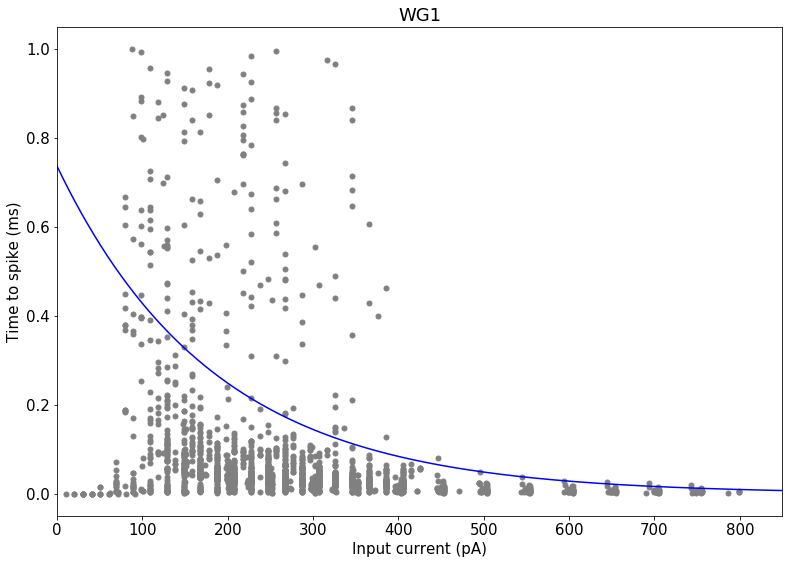

In [37]:
x=WG1_time_to_spike_input
y=WG1_time_to_spike_value

# normalise time to spike
time_to_spike_max=max(y)
y=y/time_to_spike_max

all_x=np.linspace(0,850,850)

plt.plot(x,y,'.',markersize=10,c='grey')
plt.plot(all_x[np.argsort(all_x)], (np.exp(WG1_coeff[0][1]) * np.exp(WG1_coeff[0][0] * all_x[np.argsort(all_x)]))/time_to_spike_max, label='Fitted line',c='blue')
#plt.ylim([-10,1100])
plt.xlim([0, 850])

plt.title('WG1')
plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')

#plt.savefig('WG1_model_time_to_spike.eps', format='eps', dpi=300)



## WG4 Time to spike

Text(0,0.5,'Time to spike (ms)')

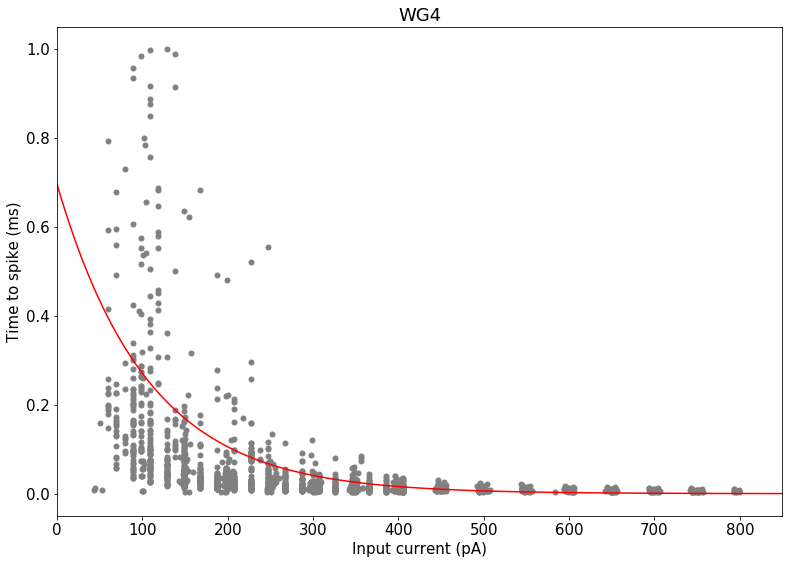

In [38]:
x=WG4_time_to_spike_input
y=WG4_time_to_spike_value

# normalise time to spike
time_to_spike_max=max(y)
y=y/time_to_spike_max


all_x=np.linspace(0,850,850)

plt.plot(x,y,'.',markersize=10,c='grey')
plt.plot(all_x[np.argsort(all_x)], (np.exp(WG4_coeff[0][1]) * np.exp(WG4_coeff[0][0] * all_x[np.argsort(all_x)]))/time_to_spike_max, label='Fitted line',c='red')
#plt.ylim([-10,1100])
plt.xlim([0, 850])

plt.title('WG4')
plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')

#plt.savefig('WG4_model_time_to_spike.eps', format='eps', dpi=300)


# Plot WG1 and WG4 f-I curves

## plot all WG1 f-I curves

In [39]:
# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0


(-10, 500)

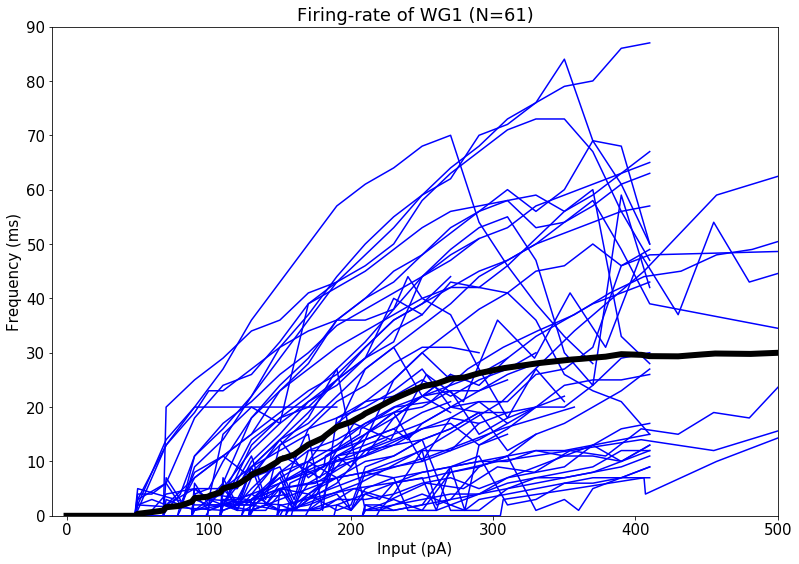

In [40]:

N_total=len(files_features_fI_H1606008['input_current'])+len(files_features_fI_H1706015['input_current'])+len(files_features_fI_H1706014TS['input_current'])+len(files_features_fI_H1806368['input_current'])

# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0

# H1606008
for i in range(len(files_features_fI_H1606008['input_current'])):
    input_cell=files_features_fI_H1606008['input_current'][i]
    frequency_cell=files_features_fI_H1606008['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='blue')
    

# H1706015    
for i in range(len(files_features_fI_H1706015['input_current'])):
    input_cell=files_features_fI_H1706015['input_current'][i]
    frequency_cell=files_features_fI_H1706015['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='blue')

    
# H1706014TS    
for i in range(len(files_features_fI_H1706014TS['input_current'])):
    input_cell=files_features_fI_H1706014TS['input_current'][i]
    frequency_cell=files_features_fI_H1706014TS['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='blue')


                                                                                                                     
# H1806368
for i in range(len(files_features_fI_H1806368['input_current'])):
    input_cell=files_features_fI_H1806368['input_current'][i]
    frequency_cell=files_features_fI_H1806368['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='blue')



# add mean to the comparison
plt.plot(input_interp,frequency_interp_sum/N_total,c='black',linewidth=6.0)

input_interp_wg1=input_interp
frequency_interp_wg1=frequency_interp_sum/N_total                                                                                                                                                                                                                 

# data    
plt.title('Firing-rate of WG1 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (ms)')
plt.ylim((0,90))
plt.xlim((-10,500))

#plt.savefig('WG1_fI.eps', format='eps', dpi=300)

## plot all WG4 f-I curves

(-10, 500)

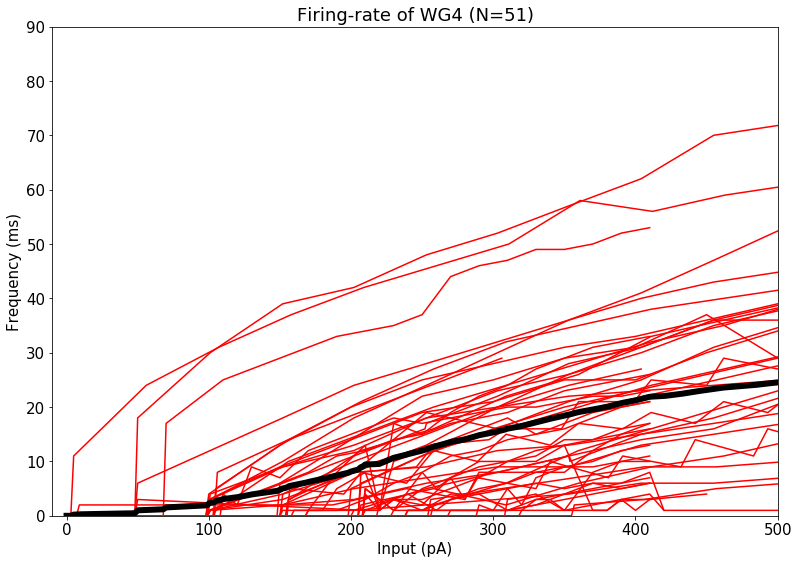

In [41]:

N_total=len(files_features_fI_H1706012['input_current'])+len(files_features_fI_H1606013['input_current'])+len(files_features_fI_H1806366['input_current'])

# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0


# H1606013
for i in range(len(files_features_fI_H1606013['input_current'])):
    input_cell=files_features_fI_H1606013['input_current'][i]
    frequency_cell=files_features_fI_H1606013['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='red')
    

# H1706012 
for i in range(len(files_features_fI_H1706012['input_current'])):
    input_cell=files_features_fI_H1706012['input_current'][i]
    frequency_cell=files_features_fI_H1706012['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='red')

    

# H1806366 
for i in range(len(files_features_fI_H1806366['input_current'])):
    input_cell=files_features_fI_H1806366['input_current'][i]
    frequency_cell=files_features_fI_H1806366['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='red')



# add mean to the comparison
plt.plot(input_interp,frequency_interp_sum/N_total,c='black',linewidth=6.0)


input_interp_wg4=input_interp
frequency_interp_wg4=frequency_interp_sum/N_total                                                                                                                                                                                                                 



# data    
plt.title('Firing-rate of WG4 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (ms)')
plt.ylim((0,90))
plt.xlim((-10,500))

#plt.savefig('WG4_fI.eps', format='eps', dpi=300)


## plot the averaged WG1 and WG4 curves

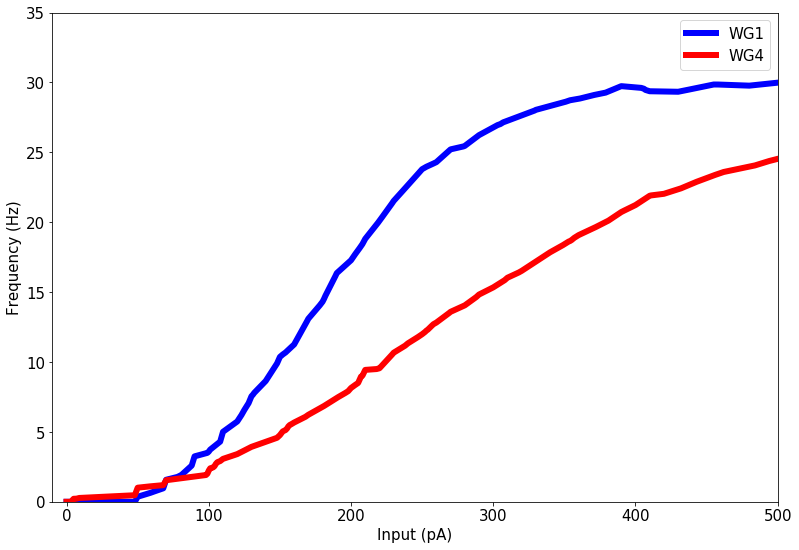

In [42]:

plt.plot(input_interp_wg1,frequency_interp_wg1,c='blue',linewidth=6.0)
plt.plot(input_interp_wg4,frequency_interp_wg4,c='red',linewidth=6.0)

# data    
#plt.title('Firing-rate of WG4 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (Hz)')
plt.ylim((0,35))
plt.xlim((-10,500))
plt.legend(['WG1','WG4'])

#plt.savefig('WG1_WG4_fI_average.eps', format='eps', dpi=300)


# Plot the first spike of WG1 cells

In [162]:
# hard coded sampling rate, from an arbitrary file

f = h5py.File('./Data/H17.06.015/nwb/1706015210301.nwb','r')
i=10
rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/starting_time')
sampling_rate=f[rate_name].attrs['rate']   

print(sampling_rate)

20000.0


(-25, 122)

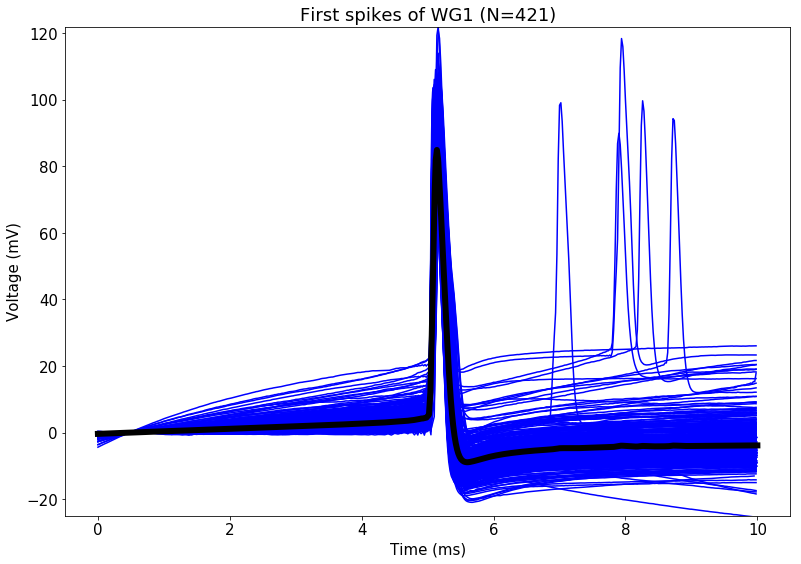

In [44]:

# plot all WG1 spikes
N_total=len(files_features_AP_H1606008['first_spike_voltage'])+len(files_features_AP_H1706015['first_spike_voltage'])+len(files_features_AP_H1706014TS['first_spike_voltage'])+len(files_features_AP_H1806368['first_spike_voltage'])

# empty vectors for interpolation, set up the same for all experimental groups
spike_voltage_interp=np.arange(0,10,1/sampling_rate)
spike_voltage_interp_sum=np.arange(0,10,1/sampling_rate)*0


# H1606008
for i in range(len(files_features_AP_H1606008['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1606008['first_spike_voltage'][i]
    spike_time=files_features_AP_H1606008['first_spike_time'][i]

    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp

    plt.plot(spike_time,spike_voltage,c='blue')
    
    
# H1706015    
for i in range(len(files_features_AP_H1706015['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1706015['first_spike_voltage'][i]
    spike_time=files_features_AP_H1706015['first_spike_time'][i]
    
    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp
    
    plt.plot(spike_time,spike_voltage,c='blue')

    
# H1706014TS    
for i in range(len(files_features_AP_H1706014TS['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1706014TS['first_spike_voltage'][i]
    spike_time=files_features_AP_H1706014TS['first_spike_time'][i]

    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp

    plt.plot(spike_time,spike_voltage,c='blue')

    
# H1806368
for i in range(len(files_features_AP_H1806368['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1806368['first_spike_voltage'][i]
    spike_time=files_features_AP_H1806368['first_spike_time'][i]

    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp

    plt.plot(spike_time,spike_voltage,c='blue')


# add mean to the comparison
plt.plot(spike_voltage_interp,spike_voltage_interp_sum/N_total,c='black',linewidth=6.0)
    
# data    
plt.title('First spikes of WG1 (N=' +str(N_total) +str(')'))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.ylim((-25,122))

#plt.savefig('WG1_first_spike.eps', format='eps', dpi=300)


# Plot the first spike of WG4 cells

(-25, 122)

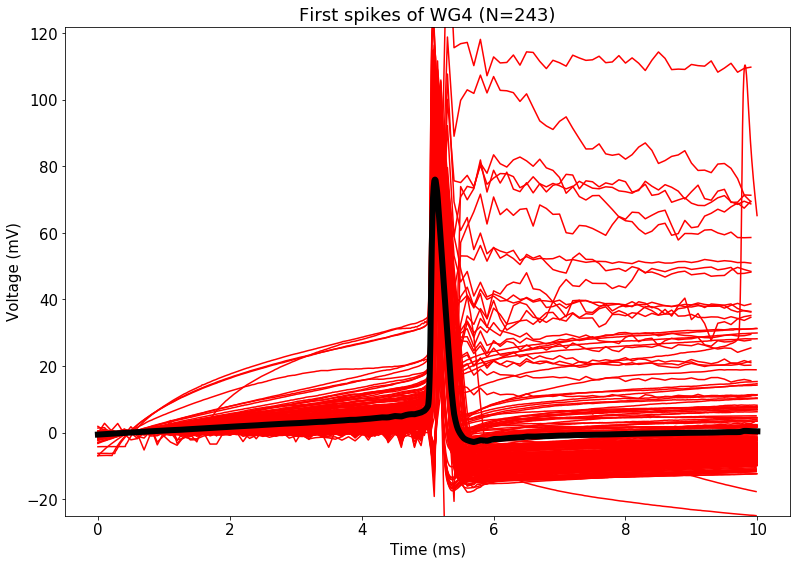

In [45]:
# plot all WG4 spikes

N_total=len(files_features_AP_H1606013['first_spike_voltage'])+len(files_features_AP_H1706012['first_spike_voltage'])+len(files_features_AP_H1806366['first_spike_voltage'])

# empty vectors for interpolation, set up the same for all experimental groups
spike_voltage_interp=np.arange(0,10,1/sampling_rate)
spike_voltage_interp_sum=np.arange(0,10,1/sampling_rate)*0


# H1606013
for i in range(len(files_features_AP_H1606013['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1606013['first_spike_voltage'][i]
    spike_time=files_features_AP_H1606013['first_spike_time'][i]
    
    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp

    
    plt.plot(spike_time,spike_voltage,c='red')
    
# H1706012    
for i in range(len(files_features_AP_H1706012['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1706012['first_spike_voltage'][i]
    spike_time=files_features_AP_H1706012['first_spike_time'][i]
    
    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp
    
    plt.plot(spike_time,spike_voltage,c='red')
    
    
# H1806366
for i in range(len(files_features_AP_H1806366['first_spike_voltage'])):
    spike_voltage=files_features_AP_H1806366['first_spike_voltage'][i]
    spike_time=files_features_AP_H1806366['first_spike_time'][i]

    # interpolate the voltage
    spike_time_interp=np.interp(spike_voltage_interp,spike_time,spike_voltage)

    # sum up all interpolated values
    spike_voltage_interp_sum=spike_voltage_interp_sum+spike_time_interp

    plt.plot(spike_time,spike_voltage,c='red')


# add mean to the comparison
plt.plot(spike_voltage_interp,spike_voltage_interp_sum/N_total,c='black',linewidth=6.0)

    
# data    
plt.title('First spikes of WG4 (N=' +str(N_total) +str(')'))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.ylim((-25,122))

#plt.savefig('WG4_first_spike.eps', format='eps', dpi=300)


# Create the data matrix based on dictionaries

In [46]:
# define the total number of cells and total number of features


keys=files_features_H1606008.keys()
keys[1]

# determine the length based on one dictionary
n_features=len(files_features_H1606008[keys[1]])
n_cells=len(files_features_H1606008)+len(files_features_H1606013)+len(files_features_H1706012)+len(files_features_H1706014TS)+len(files_features_H1706015)+len(files_features_H1806366)+len(files_features_H1806368)+len(files_features_H1806371)


print('Total number of features')
print(n_features)

print('Total number of cells')
print(n_cells)

NameError: name 'files_features_H1806371' is not defined

In [ ]:
# create the vector of patient labeling

patient_label = np.zeros(n_cells)

n_1=len(files_features_H1606008)
n_2=n_1+len(files_features_H1606013)
n_3=n_2+len(files_features_H1706012)
n_4=n_3+len(files_features_H1706014TS)
n_5=n_4+len(files_features_H1706015)
n_6=n_5+len(files_features_H1806366)
n_7=n_6+len(files_features_H1806368)
n_8=n_7+len(files_features_H1806371)

patient_label[0:n_1]=1
patient_label[n_1:n_2]=2
patient_label[n_2:n_3]=3
patient_label[n_3:n_4]=4
patient_label[n_4:n_5]=5
patient_label[n_5:n_6]=6
patient_label[n_6:n_7]=7
patient_label[n_7:n_8]=8

print('Patient labels')
print(patient_label)

# Save features to the matrix

In [ ]:
# number corresponds to the Wyler grade

a,b,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1606008)
c,d,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1606013)
e,f,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1706012)
g,h,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1706014TS)
i,j,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1706015)
k,l,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1806366)

# predicted WG as 1 !!!
m,n,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1806368)

# predicted WG as 4 by Jonathan
o,p,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1806371)


# concatenate the matricies
all_features_matrix=np.concatenate((a,c,e,g,i,k,m,o),axis=0)

In [ ]:
# save the feature names

feature_names=my_keys

print(my_keys)

In [ ]:
# save cell names

cell_names=b+d+f+h+j+l+n+p
print(cell_names)

# Vizualise the matrix of extracted features

In [ ]:
plt.imshow(all_features_matrix)
plt.title('Concatenated matrix of features')

# Save features, names and labels to csv file

In [ ]:
# save the data matrix to csv
np.savetxt('ALL_EPHYS_FEATURES_EXP_hipp_GC.csv',all_features_matrix, delimiter=" ")

# save the cell_type names
with open('ALL_EPHYS_EXP_CELL_CELL_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(cell_names)
    
# save the patient labels
with open('ALL_EPHYS_EXP_PATIENT_LABELS_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(patient_label)
    
# save the feature names
with open('ALL_EPHYS_EXP_FEATURE_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(feature_names)